<a href="https://colab.research.google.com/github/ahmedengu/feature_importance/blob/master/Forex/AUDJPY/AUDJPY_1H_Close.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
from IPython.display import clear_output
import pandas as pd

if pd.__version__ != '0.25.0' or False:
  # install
  !apt-get install default-jre build-essential swig
  !pip  install h2o==3.24.0.5 yfinance==0.1.43
  !pip  install git+https://github.com/ahmedengu/findatapy.git pandas==0.25.0
  clear_output(wait=True)

  !wget http://prdownloads.sourceforge.net/ta-lib/ta-lib-0.4.0-src.tar.gz
  !tar -xzvf ta-lib-0.4.0-src.tar.gz
  %cd ta-lib
  !./configure --prefix=/usr
  clear_output(wait=True)
  !make
  clear_output(wait=True)
  !make install
  clear_output(wait=True)
  !pip install Ta-Lib==0.4.17
  clear_output(wait=True)
  print('RESTARTING')
  %cd /content
  
  # force restart
  import os
  os.kill(os.getpid(), 9)

In [0]:
# Experiment Config
import pandas as pd
from IPython.display import display
from IPython.core.debugger import set_trace

data_ticker = "AUDJPY"
data_resample = '1H'
data_label = 'Close'
data_label_name = 'y'
start_date = '1 Jan 2018'
finish_date = '1 Jan 2019'
is_duka = True
is_yahoo = False
kaggle_file = 'bitstamp' # default None
kaggle_folder = '1 Day/Stocks'

models_summary = {}
for metric in ['accuracy','F1','auc','logloss','mean_per_class_error','rmse','mse']:
  models_summary.update({metric:pd.DataFrame()})

# feature elimination config
model_selected_features = 50
PCA_k = 50
HCF_threshold = 0.90
LVF_threshold = 0.1
GLRM_k = 20
select_k = 50
select_percentile = 10
select_alpha = 0.1
select_rfe = 50

features_to_include = ['All', 'DLF', 'XGBF', 'RFE', 'Fwe'] # True for all , ['All','Fwe','RFE','Percentile','KBest','LVF','HCF','PCA','XGBF','GLMF','DLF','GLRM'] 
is_EDA = True
max_models_num = 10

# pandas options
pd.set_option('display.max_columns', 500)
pd.set_option('display.width', 1000)

In [3]:
# random seed
from numpy.random import seed
seed(1)
from tensorflow import set_random_seed
set_random_seed(1)
import pandas as pd
import gc
import os

resample_how= {'Open': 'first', 'High': 'max', 'Low': 'min', 'Close': 'last',
                             'Volume': 'sum', 'Date': 'first'}

if is_duka:
  from findatapy.util import DataConstants

  DataConstants.market_thread_no.update({'dukascopy': 64})

  # Download dataset
  from findatapy.market import Market, MarketDataRequest, MarketDataGenerator

  market = Market(market_data_generator=MarketDataGenerator(log_every_day=30))

  md_request = MarketDataRequest(start_date=start_date, finish_date=finish_date,
                                       fields=['temp', 'ask', 'bid', 'askv', 'bidv'], vendor_fields=['temp', 'ask', 'bid', 'askv', 'bidv'],
                                       freq='tick', data_source='dukascopy',
                                       tickers=[data_ticker], vendor_tickers=[data_ticker])

  temp_dataset = market.fetch_market(md_request)
  full_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bid'].resample(data_resample).ohlc())
  full_dataset.columns = ['Open', 'High', 'Low', 'Close']
  temp_dataset = pd.DataFrame(temp_dataset[data_ticker + '.bidv'].resample(data_resample).sum())
  temp_dataset.columns = ['Volume']
  full_dataset['Volume'] = temp_dataset['Volume']

  del temp_dataset, md_request, market, DataConstants, Market, MarketDataRequest, MarketDataGenerator

  gc.collect()

elif is_yahoo:
  import yfinance as yf
  from datetime import datetime

  full_dataset = yf.download(data_ticker, start=str(datetime.strptime(start_date, '%d %b %Y')).split(' ')[0], end=str(datetime.strptime(finish_date, '%d %b %Y')).split(' ')[0])
  full_dataset['Date']=full_dataset.index
  del yf,datetime

elif data_ticker == 'EURUSD':
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2014.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2015.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2016.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2017.zip
  !wget -q https://github.com/philipperemy/FX-1-Minute-Data/raw/master/2000-Jun2019/eurusd/DAT_ASCII_EURUSD_M1_2018.zip
  !unzip -qq -o \*.zip
  full_dataset = pd.read_csv('DAT_ASCII_EURUSD_M1_2014.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';')
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2015.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2016.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2017.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset = full_dataset.append(pd.read_csv('DAT_ASCII_EURUSD_M1_2018.csv',names=['Date','Open', 'High', 'Low', 'Close','Volume'], delimiter=';'))
  full_dataset['Date'] = pd.to_datetime(full_dataset['Date'])
  full_dataset.index = full_dataset['Date']
  full_dataset = full_dataset.dropna()
  full_dataset = full_dataset.sort_index()
  full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]


    
elif data_ticker == 'APPLUSUSD':
  full_dataset=pd.read_csv('https://github.com/kyleconroy/apple-stock/raw/master/apple_stock_data.csv',index_col =0,parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > '2007-04-01']


elif data_ticker == 'COMI':
  full_dataset=pd.read_csv('https://static.mubasher.info/File.MubasherCharts/File.Historical_Stock_Charts_Dir/44507230b2b03e2da37352abf1a659545b44.csv',index_col =0,names =['Open', 'High', 'Low', 'Close','Volume'],parse_dates =[0])

  full_dataset = full_dataset.astype(float)
  full_dataset['Volume'] = full_dataset['Volume'] * full_dataset['Close'] 
  full_dataset = full_dataset.drop_duplicates()
  full_dataset['Date']=full_dataset.index
  full_dataset = full_dataset[full_dataset.index > start_date]
  full_dataset = full_dataset[full_dataset.index < finish_date]
  
elif kaggle_file is not None:
  if not os.path.isfile('kaggle.json'):
    from google.colab import files
    files.upload()
    
    import time
    time.sleep(10)
    !ls
    !mkdir -p ~/.kaggle
    !cp kaggle.json ~/.kaggle/
    !ls ~/.kaggle

    !chmod 600 /root/.kaggle/kaggle.json
    del files
    
  !kaggle datasets download $data_ticker
  !unzip -qq -o \*.zip
  !unzip -qq -o \*.zip

  if data_ticker == 'mczielinski/bitcoin-historical-data':
    
    full_dataset = pd.read_csv([file for file in os.listdir() if kaggle_file in file][0])
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'Volume_(Currency)','Weighted_Price']
    full_dataset.index=pd.to_datetime(full_dataset['Date'], unit='s')

    resample_how.update({'Volume_(Currency)': 'sum', 'Weighted_Price': 'last'})

    full_dataset = full_dataset.resample(data_resample, how=resample_how).dropna()[1:-1]
    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]
  
  elif data_ticker == 'borismarjanovic/daily-and-intraday-stock-price-data':
    
    full_dataset = pd.read_csv(kaggle_folder + '/' + [file for file in os.listdir(kaggle_folder) if kaggle_file in file][0])
    if 'Time' in full_dataset.columns:
      full_dataset['Date'] = pd.to_datetime(full_dataset['Date'] + ' ' + full_dataset['Time'])
      full_dataset = full_dataset.drop('Time',axis=1)
    full_dataset.columns= ['Date', 'Open', 'High', 'Low', 'Close', 'Volume', 'OpenInt']
    full_dataset.index=pd.to_datetime(full_dataset['Date'])

    full_dataset = full_dataset[full_dataset.index > start_date]
    full_dataset = full_dataset[full_dataset.index < finish_date]

  
gc.collect()
full_dataset = full_dataset.dropna()

full_dataset = full_dataset.drop('Date',axis=1, errors='ignore')
full_dataset = full_dataset.sort_index()
full_dataset = full_dataset[-100000:]
display(full_dataset)
display(full_dataset.describe())
full_dataset.to_pickle('full_dataset')
del full_dataset, set_random_seed, seed
gc.collect()

2019-08-22 10:11:18,945 - findatapy.market.datavendorweb - INFO - Request Dukascopy data
2019-08-22 10:11:18,946 - findatapy.market.datavendorweb - INFO - About to download from Dukascopy... for AUDJPY
2019-08-22 10:15:37,682 - findatapy.market.datavendorweb - INFO - Downloading... 2018-01-30 00:00:00
2019-08-22 10:24:31,244 - findatapy.market.datavendorweb - INFO - Downloading... 2018-03-30 00:00:00
2019-08-22 10:29:08,436 - findatapy.market.datavendorweb - INFO - Downloading... 2018-04-30 00:00:00
2019-08-22 10:33:15,928 - findatapy.market.datavendorweb - INFO - Downloading... 2018-05-30 00:00:00
2019-08-22 10:38:03,815 - findatapy.market.datavendorweb - INFO - Downloading... 2018-06-30 00:00:00
2019-08-22 10:42:45,674 - findatapy.market.datavendorweb - INFO - Downloading... 2018-07-30 00:00:00
2019-08-22 10:47:39,353 - findatapy.market.datavendorweb - INFO - Downloading... 2018-08-30 00:00:00
2019-08-22 10:52:07,608 - findatapy.market.datavendorweb - INFO - Downloading... 2018-09-30

/usr/local/lib/python3.6/dist-packages/findatapy/market/ioengine.py:264: FutureWarning: to_msgpack is deprecated and will be removed in a future version.
It is recommended to use pyarrow for on-the-wire transmission of pandas objects.
  r.set(fname, data_frame.to_msgpack(compress='blosc'))


2019-08-22 11:07:08,932 - findatapy.market.ioengine - WARNING - Couldn't push MarketDataRequest_436__abstract_curve_key-None__category-None__category_key-backtest_default-cat_dukascopy_tick_NYC_AUDJPY__cut-NYC__data_source-dukascopy__environment-backtest__expiry_date-NaT__fields-temp_ask_bid_askv_bidv__finish_date-2019-01-01 00:00:00__freq-tick__freq_mult-1__gran_freq-None__resample-None__resample_how-last__start_date-2018-01-01 00:00:00__tickers-AUDJPY__trade_side-trade__vendor_fields-temp_ask_bid_askv_bidv__vendor_tickers-AUDJPY to Redis: Error 111 connecting to 127.0.0.1:6379. Connection refused.


Open       High        Low      Close       Volume
Date                                                                        
2018-01-01 22:00:00  87.860001  88.028000  87.792000  87.987000  1967.810059
2018-01-01 23:00:00  87.989998  87.989998  87.876999  87.945999  6692.810059
2018-01-02 00:00:00  87.949997  88.093002  87.942001  88.077003  3015.949951
2018-01-02 01:00:00  88.077003  88.213997  88.055000  88.138000  4958.649902
2018-01-02 02:00:00  88.137001  88.199997  88.125000  88.160004  3736.630127
...                        ...        ...        ...        ...          ...
2018-12-31 17:00:00  77.300003  77.320999  77.225998  77.235001  5473.870117
2018-12-31 18:00:00  77.232002  77.283997  77.218002  77.259003  3701.399902
2018-12-31 19:00:00  77.259003  77.279999  77.209000  77.224998  3154.629883
2018-12-31 20:00:00  77.225998  77.244003  77.192001  77.216003  3147.850098
2018-12-31 21:00:00  77.214996  77.334000  77.152000  77.174004  1882.890015

[6222 rows x 5 columns]

Open         High          Low        Close        Volume
count  6222.000000  6222.000000  6222.000000  6222.000000   6222.000000
mean     82.536232    82.612144    82.459091    82.534569   6046.020996
std       2.310576     2.308661     2.312368     2.310386   3195.994141
min      77.214996    77.244003    77.152000    77.174004    274.450012
25%      81.288252    81.374001    81.203003    81.285254   3902.119934
50%      82.221001    82.293499    82.153999    82.219002   5722.859863
75%      83.278000    83.341753    83.206751    83.275751   7598.547485
max      89.056000    89.086998    89.021004    89.056999  86182.937500

25

In [4]:
# OHLC EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('full_dataset')))
  del pp

/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)
/usr/local/lib/python3.6/dist-packages/pandas_profiling/describe.py:392: FutureWarning: The join_axes-keyword is deprecated. Use .reindex or .reindex_like on the result to achieve the same functionality.
  variable_stats = pd.concat(ldesc, join_axes=pd.Index([names]), axis=1)


In [5]:
# features
from talib._ta_lib import *
import talib
import numpy as np
import uuid
import os


features_dataset = pd.read_pickle('full_dataset').sort_index()


periods = np.resize([2, 3, 3, 2], len(features_dataset['Close'])).astype(float)
timeperiods = [8, 12, 14, 20, 24, 30]
matypes = range(9)
nbdevs = [2, 3, 4, 5]

# date features
features_dataset['day'] = features_dataset.index.day
features_dataset['dayofweek'] = features_dataset.index.dayofweek
features_dataset['dayofyear'] = features_dataset.index.dayofyear
features_dataset['days_in_month'] = features_dataset.index.days_in_month
features_dataset['hour'] = features_dataset.index.hour
features_dataset['is_month_end'] = pd.factorize(features_dataset.index.is_month_end)[0]
features_dataset['is_month_start'] = pd.factorize(features_dataset.index.is_month_start)[0]
features_dataset['is_quarter_end'] = pd.factorize(features_dataset.index.is_quarter_end)[0]
features_dataset['is_quarter_start'] = pd.factorize(features_dataset.index.is_quarter_start)[0]
features_dataset['minute'] = features_dataset.index.minute
features_dataset['month'] = features_dataset.index.month
features_dataset['quarter'] = features_dataset.index.quarter
features_dataset['second'] = features_dataset.index.second
features_dataset['week'] = features_dataset.index.week
features_dataset['weekday'] = features_dataset.index.weekday
features_dataset['weekday_name'] = pd.factorize(features_dataset.index.weekday_name)[0]
features_dataset['weekofyear'] = features_dataset.index.weekofyear

# Overlap Studies
features_dataset['HT_TRENDLINE'] = HT_TRENDLINE(features_dataset['Close'])
features_dataset['mama'], features_dataset['fama'] = MAMA(features_dataset['Close'])
features_dataset['SAREXT'] = SAREXT(features_dataset['High'], features_dataset['Low'], startvalue=-4e37,
                                    offsetonreverse=-4e37, accelerationinitlong=-4e37,
                                    accelerationlong=-4e37, accelerationmaxlong=-4e37, accelerationinitshort=-4e37,
                                    accelerationshort=-4e37, accelerationmaxshort=-4e37)

for timeperiod in timeperiods:
    features_dataset['DEMA_' + str(timeperiod)] = DEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['EMA_' + str(timeperiod)] = EMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['KAMA_' + str(timeperiod)] = KAMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPOINT_' + str(timeperiod)] = MIDPOINT(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIDPRICE_' + str(timeperiod)] = MIDPRICE(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['SAR_' + str(timeperiod / 100)] = SAR(features_dataset['High'], features_dataset['Low'],
                                                           acceleration=timeperiod / 100,
                                                           maximum=timeperiod / 100)
    features_dataset['SMA_' + str(timeperiod)] = SMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TEMA_' + str(timeperiod)] = TEMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIMA_' + str(timeperiod)] = TRIMA(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WMA_' + str(timeperiod)] = WMA(features_dataset['Close'], timeperiod=timeperiod)

    for matype in matypes:
        features_dataset['MA_' + str(timeperiod) + '_' + str(matype)] = MA(features_dataset['Close'],
                                                                           timeperiod=timeperiod, matype=matype)
        features_dataset['MAVP_' + str(timeperiod) + '_' + str(matype)] = MAVP(features_dataset['Close'], periods,
                                                                               minperiod=2,
                                                                               maxperiod=timeperiod, matype=matype)
        features_dataset['T3_' + str(timeperiod) + '_' + str(matype)] = T3(features_dataset['Close'],
                                                                           timeperiod=timeperiod,
                                                                           vfactor=matype / 10)

        for nbdev in nbdevs:
            features_dataset['BBANDS_upperband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_middleband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)], \
            features_dataset['BBANDS_lowerband_' + str(timeperiod) + '_' + str(matype) + '_' + str(nbdev)] = BBANDS(
                features_dataset['Close'], timeperiod=timeperiod, nbdevup=nbdev, nbdevdn=nbdev, matype=matype)

            
gc.collect()
# Momentum Indicators
features_dataset['BOP'] = BOP(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                              features_dataset['Close'])

for timeperiod in timeperiods:
    features_dataset['ADX_' + str(timeperiod)] = ADX(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ADXR_' + str(timeperiod)] = ADXR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['aroondown_' + str(timeperiod)], features_dataset['aroonup_' + str(timeperiod)] = AROON(
        features_dataset['High'],
        features_dataset['Low'],
        timeperiod=timeperiod)
    features_dataset['AROONOSC_' + str(timeperiod)] = AROONOSC(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['CCI_' + str(timeperiod)] = CCI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['CMO_' + str(timeperiod)] = CMO(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['DX_' + str(timeperiod)] = DX(features_dataset['High'], features_dataset['Low'],
                                                   features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MACDFIX_' + str(timeperiod)], features_dataset['MACDFIX_signal_' + str(timeperiod)], features_dataset[
        'MACDFIX_hist_' + str(timeperiod)] = MACDFIX(features_dataset['Close'], signalperiod=timeperiod)
    features_dataset['MFI_' + str(timeperiod)] = MFI(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], features_dataset['Volume'],
                                                     timeperiod=timeperiod)
    features_dataset['MINUS_DI_' + str(timeperiod)] = MINUS_DI(features_dataset['High'], features_dataset['Low'],
                                                               features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINUS_DM_' + str(timeperiod)] = MINUS_DM(features_dataset['High'], features_dataset['Low'],
                                                               timeperiod=timeperiod)
    features_dataset['MOM_' + str(timeperiod)] = MOM(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DI_' + str(timeperiod)] = PLUS_DI(features_dataset['High'], features_dataset['Low'],
                                                             features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['PLUS_DM_' + str(timeperiod)] = PLUS_DM(features_dataset['High'], features_dataset['Low'],
                                                             timeperiod=timeperiod)
    features_dataset['ROC_' + str(timeperiod)] = ROC(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCP_' + str(timeperiod)] = ROCP(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR_' + str(timeperiod)] = ROCR(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['ROCR100_' + str(timeperiod)] = ROCR100(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['RSI_' + str(timeperiod)] = RSI(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['TRIX_' + str(timeperiod)] = TRIX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['WILLR_' + str(timeperiod)] = WILLR(features_dataset['High'], features_dataset['Low'],
                                                         features_dataset['Close'], timeperiod=timeperiod)

    
gc.collect()
features_dataset['APO'] = APO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['MACD'], features_dataset['MACD_signal'], features_dataset['MACD_hist'] = MACD(
    features_dataset['Close'], fastperiod=12,
    slowperiod=26,
    signalperiod=9)
features_dataset['MACDEXT'], features_dataset['MACDEXT_signal'], features_dataset['MACDEXT_hist'] = MACDEXT(
    features_dataset['Close'],
    fastperiod=12,
    fastmatype=0,
    slowperiod=26,
    slowmatype=0,
    signalperiod=9,
    signalmatype=0)

features_dataset['PPO'] = PPO(features_dataset['Close'], fastperiod=12, slowperiod=26, matype=0)

features_dataset['STOCH_slowk'], features_dataset['STOCH_slowd'] = STOCH(features_dataset['High'],
                                                                         features_dataset['Low'],
                                                                         features_dataset['Close'], fastk_period=5,
                                                                         slowk_period=3, slowk_matype=0,
                                                                         slowd_period=3, slowd_matype=0)
features_dataset['STOCHF_fastk'], features_dataset['STOCHF_fastd'] = STOCHF(features_dataset['High'],
                                                                            features_dataset['Low'],
                                                                            features_dataset['Close'], fastk_period=5,
                                                                            fastd_period=3, fastd_matype=0)
features_dataset['STOCHRSI_fastk'], features_dataset['STOCHRSI_fastd'] = STOCHRSI(features_dataset['Close'],
                                                                                  timeperiod=14,
                                                                                  fastk_period=5, fastd_period=3,
                                                                                  fastd_matype=0)
features_dataset['ULTOSC'] = ULTOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                    timeperiod1=7, timeperiod2=14, timeperiod3=28)

# Volume Indicators
features_dataset['AD'] = AD(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                            features_dataset['Volume'])
features_dataset['ADOSC'] = ADOSC(features_dataset['High'], features_dataset['Low'], features_dataset['Close'],
                                  features_dataset['Volume'], fastperiod=3, slowperiod=10)
features_dataset['OBV'] = OBV(features_dataset['Close'], features_dataset['Volume'])

gc.collect()
# Volatility Indicators
for timeperiod in timeperiods:
    features_dataset['ATR_' + str(timeperiod)] = ATR(features_dataset['High'], features_dataset['Low'],
                                                     features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['NATR_' + str(timeperiod)] = NATR(features_dataset['High'], features_dataset['Low'],
                                                       features_dataset['Close'], timeperiod=timeperiod)

features_dataset['TRANGE'] = TRANGE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

# Price Transform
features_dataset['AVGPRICE'] = AVGPRICE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                        features_dataset['Close'])
features_dataset['MEDPRICE'] = MEDPRICE(features_dataset['High'], features_dataset['Low'])
features_dataset['TYPPRICE'] = TYPPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])
features_dataset['WCLPRICE'] = WCLPRICE(features_dataset['High'], features_dataset['Low'], features_dataset['Close'])

gc.collect()
# Cycle Indicators
features_dataset['HT_DCPERIOD'] = HT_DCPERIOD(features_dataset['Close'])
features_dataset['HT_DCPHASE'] = HT_DCPHASE(features_dataset['Close'])
features_dataset['HT_PHASOR_inphase'], features_dataset['HT_PHASOR_quadrature'] = HT_PHASOR(features_dataset['Close'])
features_dataset['HT_SINE_sine'], features_dataset['HT_SINE_leadsine'] = HT_SINE(features_dataset['Close'])
features_dataset['HT_TRENDMODE'] = HT_TRENDMODE(features_dataset['Close'])

# Pattern Recognition
features_dataset['CDL2CROWS'] = CDL2CROWS(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDL3BLACKCROWS'] = CDL3BLACKCROWS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3INSIDE'] = CDL3INSIDE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDL3LINESTRIKE'] = CDL3LINESTRIKE(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3OUTSIDE'] = CDL3OUTSIDE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3STARSINSOUTH'] = CDL3STARSINSOUTH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDL3WHITESOLDIERS'] = CDL3WHITESOLDIERS(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLABANDONEDBABY'] = CDLABANDONEDBABY(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'],
                                                        penetration=0)
features_dataset['CDLADVANCEBLOCK'] = CDLADVANCEBLOCK(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBELTHOLD'] = CDLBELTHOLD(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLBREAKAWAY'] = CDLBREAKAWAY(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCLOSINGMARUBOZU'] = CDLCLOSINGMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCONCEALBABYSWALL'] = CDLCONCEALBABYSWALL(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLCOUNTERATTACK'] = CDLCOUNTERATTACK(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDARKCLOUDCOVER'] = CDLDARKCLOUDCOVER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'],
                                                          penetration=0)
features_dataset['CDLDOJI'] = CDLDOJI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                      features_dataset['Close'])
features_dataset['CDLDOJISTAR'] = CDLDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLDRAGONFLYDOJI'] = CDLDRAGONFLYDOJI(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLENGULFING'] = CDLENGULFING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLEVENINGDOJISTAR'] = CDLEVENINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLEVENINGSTAR'] = CDLEVENINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLGAPSIDESIDEWHITE'] = CDLGAPSIDESIDEWHITE(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLGRAVESTONEDOJI'] = CDLGRAVESTONEDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHAMMER'] = CDLHAMMER(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHANGINGMAN'] = CDLHANGINGMAN(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHARAMI'] = CDLHARAMI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLHARAMICROSS'] = CDLHARAMICROSS(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIGHWAVE'] = CDLHIGHWAVE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHIKKAKE'] = CDLHIKKAKE(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLHIKKAKEMOD'] = CDLHIKKAKEMOD(features_dataset['Open'], features_dataset['High'],
                                                  features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLHOMINGPIGEON'] = CDLHOMINGPIGEON(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLIDENTICAL3CROWS'] = CDLIDENTICAL3CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLINNECK'] = CDLINNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLINVERTEDHAMMER'] = CDLINVERTEDHAMMER(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLKICKING'] = CDLKICKING(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'])
features_dataset['CDLKICKINGBYLENGTH'] = CDLKICKINGBYLENGTH(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLADDERBOTTOM'] = CDLLADDERBOTTOM(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLEGGEDDOJI'] = CDLLONGLEGGEDDOJI(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLLONGLINE'] = CDLLONGLINE(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMARUBOZU'] = CDLMARUBOZU(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATCHINGLOW'] = CDLMATCHINGLOW(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLMATHOLD'] = CDLMATHOLD(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                            features_dataset['Close'], penetration=0)
features_dataset['CDLMORNINGDOJISTAR'] = CDLMORNINGDOJISTAR(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'],
                                                            penetration=0)
features_dataset['CDLMORNINGSTAR'] = CDLMORNINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'], penetration=0)
features_dataset['CDLONNECK'] = CDLONNECK(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLPIERCING'] = CDLPIERCING(features_dataset['Open'], features_dataset['High'],
                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRICKSHAWMAN'] = CDLRICKSHAWMAN(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLRISEFALL3METHODS'] = CDLRISEFALL3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSEPARATINGLINES'] = CDLSEPARATINGLINES(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHOOTINGSTAR'] = CDLSHOOTINGSTAR(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSHORTLINE'] = CDLSHORTLINE(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSPINNINGTOP'] = CDLSPINNINGTOP(features_dataset['Open'], features_dataset['High'],
                                                    features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTALLEDPATTERN'] = CDLSTALLEDPATTERN(features_dataset['Open'], features_dataset['High'],
                                                          features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLSTICKSANDWICH'] = CDLSTICKSANDWICH(features_dataset['Open'], features_dataset['High'],
                                                        features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTAKURI'] = CDLTAKURI(features_dataset['Open'], features_dataset['High'], features_dataset['Low'],
                                          features_dataset['Close'])
features_dataset['CDLTASUKIGAP'] = CDLTASUKIGAP(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLTHRUSTING'] = CDLTHRUSTING(features_dataset['Open'], features_dataset['High'],
                                                features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUNIQUE3RIVER'] = CDLUNIQUE3RIVER(features_dataset['Open'], features_dataset['High'],
                                                      features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLUPSIDEGAP2CROWS'] = CDLUPSIDEGAP2CROWS(features_dataset['Open'], features_dataset['High'],
                                                            features_dataset['Low'], features_dataset['Close'])
features_dataset['CDLXSIDEGAP3METHODS'] = CDLXSIDEGAP3METHODS(features_dataset['Open'], features_dataset['High'],
                                                              features_dataset['Low'], features_dataset['Close'])
gc.collect()

# Statistic Functions
for timeperiod in timeperiods:
    features_dataset['BETA_' + str(timeperiod)] = BETA(features_dataset['High'], features_dataset['Low'],
                                                       timeperiod=timeperiod)
    features_dataset['CORREL_' + str(timeperiod)] = CORREL(features_dataset['High'], features_dataset['Low'],
                                                           timeperiod=timeperiod)
    features_dataset['LINEARREG_' + str(timeperiod)] = LINEARREG(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['LINEARREG_ANGLE_' + str(timeperiod)] = LINEARREG_ANGLE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['LINEARREG_INTERCEPT_' + str(timeperiod)] = LINEARREG_INTERCEPT(features_dataset['Close'],
                                                                                     timeperiod=timeperiod)
    features_dataset['LINEARREG_SLOPE_' + str(timeperiod)] = LINEARREG_SLOPE(features_dataset['Close'],
                                                                             timeperiod=timeperiod)
    features_dataset['STDDEV_' + str(timeperiod)] = STDDEV(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)
    features_dataset['TSF_' + str(timeperiod)] = TSF(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['VAR_' + str(timeperiod)] = VAR(features_dataset['Close'], timeperiod=timeperiod, nbdev=1)

    
gc.collect()
# Math Transform
features_dataset['ACOS'] = ACOS(features_dataset['Close'])
features_dataset['ASIN'] = ASIN(features_dataset['Close'])
features_dataset['ATAN'] = ATAN(features_dataset['Close'])
features_dataset['CEIL'] = CEIL(features_dataset['Close'])
features_dataset['COS'] = COS(features_dataset['Close'])
features_dataset['COSH'] = COSH(features_dataset['Close'])
features_dataset['EXP'] = EXP(features_dataset['Close'])
features_dataset['FLOOR'] = FLOOR(features_dataset['Close'])
features_dataset['LN'] = LN(features_dataset['Close'])
features_dataset['LOG10'] = LOG10(features_dataset['Close'])
features_dataset['SIN'] = SIN(features_dataset['Close'])
features_dataset['SINH'] = SINH(features_dataset['Close'])
features_dataset['SQRT'] = SQRT(features_dataset['Close'])
features_dataset['TAN'] = TAN(features_dataset['Close'])
features_dataset['TANH'] = TANH(features_dataset['Close'])

gc.collect()
# Math Operator
features_dataset['ADD'] = ADD(features_dataset['High'], features_dataset['Low'])
features_dataset['DIV'] = DIV(features_dataset['High'], features_dataset['Low'])
features_dataset['MULT'] = MULT(features_dataset['High'], features_dataset['Low'])
features_dataset['SUB'] = SUB(features_dataset['High'], features_dataset['Low'])

for timeperiod in timeperiods:
    features_dataset['MAX_' + str(timeperiod)] = MAX(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MIN_' + str(timeperiod)] = MIN(features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['MINMAX_min_' + str(timeperiod)], features_dataset['MINMAX_max_' + str(timeperiod)] = MINMAX(
        features_dataset['Close'], timeperiod=timeperiod)
    features_dataset['SUM_' + str(timeperiod)] = SUM(features_dataset['Close'], timeperiod=timeperiod)
    
gc.collect()


features_dataset = features_dataset.drop(features_dataset.std()[(features_dataset.std() == 0)].index, axis=1)
features_dataset = features_dataset[50:].replace([np.inf, -np.inf], np.nan).dropna(axis=1)
features_dataset.to_pickle('features_dataset')
display(features_dataset)
display(features_dataset.describe())

for name in dir():
  if any( n in name for n in talib.get_functions()):
    del globals()[name]

del periods, timeperiods, matypes, nbdevs, features_dataset, talib
gc.collect()

Open       High        Low      Close       Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear       mama       fama     SAREXT     DEMA_8      EMA_8     KAMA_8  MIDPOINT_8  MIDPRICE_8   SAR_0.08      SMA_8     TEMA_8    TRIMA_8      WMA_8     MA_8_0   MAVP_8_0     T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5     MA_8_1   MAVP_8_1     T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                              
2018-01-04 00:00:00  88.136002  88.204002  88.125999  88.157997  5331.959961    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  88.093552  87.051926  88.078003  88.163707  88.114866  88.039210   88.143497   88.123001  88.031704  88.132249  88.157184  88.141148  88.138915  88.132249  88.126666  88.010662               88.236486                88.132249               88.028012               88.288604                88.132249               87.975893               88.340723                88.132249               87.923775               88.392841                88.132249               87.871656  88.114866  88.141880  88.025891               88.219103                88.114866               88.010629               88.271222                88.114866               87.958511               88.323340                88.114866               87.906393               88.375459   
2018-01-04 01:00:00  88.158997  88.182999  88.098000  88.139999  4603.370117    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  88.095875  87.078025  88.094002  88.162783  88.120452  88.041622   88.143497   88.144001  88.047648  88.139998  88.152646  88.140248  88.140638  88.139998  88.148998  88.025653               88.235831                88.139998               88.044166               88.283747                88.139998               87.996250               88.331663                88.139998               87.948334               88.379579                88.139998               87.900418  88.120452  88.142355  88.041009               88.216284                88.120452               88.024619               88.264200                88.120452               87.976703               88.312116                88.120452               87.928787               88.360032   
2018-01-04 02:00:00  88.139000  88.231003  88.

Open         High          Low        Close        Volume          day    dayofweek    dayofyear  days_in_month         hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start        month      quarter         week      weekday  weekday_name   weekofyear         mama         fama       SAREXT       DEMA_8        EMA_8       KAMA_8   MIDPOINT_8   MIDPRICE_8     SAR_0.08        SMA_8       TEMA_8      TRIMA_8        WMA_8       MA_8_0     MAVP_8_0       T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5       MA_8_1     MAVP_8_1       T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  \
count  6172.000000  6172.000000  6172.000000  6172.000000   6172.000000  6172.000000  6172.000000  6172.000000    6172.000000  6172.000000   6172.000000     6172.000000     6172.000000       6172.000000  6172.000000  6172.000000  6172.000000  6172.000000   6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000  6172.000000             6172.000000              6172.000000             6172.000000             6172.000000              6172.000000             6172.000000             6172.000000              6172.000000             6172.000000             6172.000000              6172.000000             6172.000000  6172.000000  6172.000000  6172.000000             6172.000000              6172.000000             6172.000000             6172.000000              6172.000000             6172.000000             6172.000000   
mean     82.492210    82.568260    82.414848    82.490517   6061.520996    15.901977     2.052171   183.847699      30.440538    11.490441      0.034349        0.972294        0.004051          0.995139     6.548283     2.519929    26.642579     2.052171      2.029812    26.642579    82.499496    82.516145    -0.045515    82.490659    82.496676    82.495835    82.494406    82.492705    82.495501    82.496735    82.490550    82.496738    82.494676    82.496735    82.491784    82.508600               82.701772                82.496735               82.291699               82.804290                82.496735               82.189181               82.906808                82.496735               82.086663               83.009326                82.496735               81.984145    82.496676    82.491858    82.506852               82.701712                82.496676               82.291640               82.804230                82.496676               82.189122               82.906748   
std       2.267289     2.265594     2.268557     2.266978   3201.857178     8.727121     1.509716   104.027997       0.844514     6.924863      0.182138        0.164142        0.063520          0.069554     3.409848     1.112862    14.860675     1.509716      1.457579    14.860675     2.264071     2.253717    82.533323     2.267984     2.262945     2.261778     2.263530     2.264056     2.272963     2.264338     2.267618     2.265010     2.264652     2.264338     2.265979     2.260447                2.263403                 2.264338                2.271855                2.265408                 2.264338                2.278064                2.269058                 2.264338                2.285890                2.274344                 2.264338                2.295316     2.262945     2.265715     2.260992                2.261913                 2.262945                2.270564                2.263872                 2.262945                2.276824                2.267476   
min      77.214996    77.244003    77.

36

In [6]:
# features EDA
if is_EDA:
  import pandas_profiling as pp
  display(pp.ProfileReport(pd.read_pickle('features_dataset')))
  del pp

Output hidden; open in https://colab.research.google.com to view.

In [7]:
# label and scale
import numpy as np
from sklearn.preprocessing import minmax_scale
import os
import pandas as pd

features_dataset = pd.read_pickle('features_dataset')
label_df = features_dataset[[data_label]][:-1]
label_df[data_label_name] = pd.DataFrame(features_dataset[data_label][1:].values / features_dataset[data_label][:-1].values,
                             index=label_df.index).clip(0,1).astype(int)

scaled_df = features_dataset
scaled_df = pd.DataFrame(minmax_scale(scaled_df, axis=0, feature_range=(0, 1)), columns=scaled_df.columns,
                         index=scaled_df.index)
categorical_columns = features_dataset.select_dtypes(exclude=['float64', 'float32', 'float16', 'float_']).columns

scaled_df[categorical_columns] = features_dataset[categorical_columns]
scaled_df = scaled_df[:-1]
scaled_df[data_label_name] = label_df[data_label_name]

display(scaled_df)
scaled_df.to_pickle('scaled_df') 

label_df[-50:].to_pickle('predict_df')
del features_dataset, categorical_columns, scaled_df, label_df, minmax_scale
gc.collect()

Open      High       Low     Close    Volume  day  dayofweek  dayofyear  days_in_month  hour  is_month_end  is_month_start  is_quarter_end  is_quarter_start  month  quarter  week  weekday  weekday_name  weekofyear      mama      fama    SAREXT    DEMA_8     EMA_8    KAMA_8  MIDPOINT_8  MIDPRICE_8  SAR_0.08     SMA_8    TEMA_8   TRIMA_8     WMA_8    MA_8_0  MAVP_8_0    T3_8_0  BBANDS_upperband_8_0_2  BBANDS_middleband_8_0_2  BBANDS_lowerband_8_0_2  BBANDS_upperband_8_0_3  BBANDS_middleband_8_0_3  BBANDS_lowerband_8_0_3  BBANDS_upperband_8_0_4  BBANDS_middleband_8_0_4  BBANDS_lowerband_8_0_4  BBANDS_upperband_8_0_5  BBANDS_middleband_8_0_5  BBANDS_lowerband_8_0_5    MA_8_1  MAVP_8_1    T3_8_1  BBANDS_upperband_8_1_2  BBANDS_middleband_8_1_2  BBANDS_lowerband_8_1_2  BBANDS_upperband_8_1_3  BBANDS_middleband_8_1_3  BBANDS_lowerband_8_1_3  BBANDS_upperband_8_1_4  BBANDS_middleband_8_1_4  BBANDS_lowerband_8_1_4  BBANDS_upperband_8_1_5  BBANDS_middleband_8_1_5  \
Date                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                                               
2018-01-04 00:00:00  0.922304  0.925442  0.924593  0.924346  0.058871    4          3          4             31     0             0               1               0                 1      1        1     1        3             3           1  0.928341  0.842560  0.995563  0.925751  0.927134  0.925696    0.928716    0.927012  0.909253  0.928200  0.924759  0.928205  0.927391  0.928200  0.924207  0.921285                0.920012                 0.928200                0.929140                0.908552                 0.928200                0.928372                0.892927                 0.928200                0.927334                0.876632                 0.928200                0.926315  0.927134  0.925113  0.921971                0.919420                 0.927134                0.927898                0.902394                 0.927134                0.928477                0.885826                 0.927134                0.927976                0.869700                 0.927134   
2018-01-04 01:00:00  0.924246  0.923668  0.922234  0.922831  0.050390    4          3          4             31     1             0               1               0                 1      1        1     1        3             3           1  0.928540  0.844870  0.995653  0.925673  0.927613  0.925903    0.928716    0.928821  0.910624  0.928863  0.924378  0.928129  0.927538  0.928863  0.926097  0.922609                0.919956                 0.928863                0.930509                0.908140                 0.928863                0.930083                0.892167                 0.928863                0.929378                0.875534                 0.928863                0.928687  0.927613  0.925154  0.923301                0.919178                 0.927613                0.929085                0.901799                 0.927613                0.930008                0.884889                 0.927613                0.929844                0.868428                 0.927613   
2018-01-04 02:00:00  0.922557  0.927721  

140246

In [8]:
# load data into h2o
import h2o
import pandas as pd
from h2o.automl import H2OAutoML
import uuid
import matplotlib.pyplot as plt
import matplotlib as mpl
import time
import gc
import numpy as np

def load_h2o():
  global train_hf, index_splits
  try:
    h2o.cluster().shutdown()
    time.sleep(5)
  except:
    pass

  h2o.init(min_mem_size="9g",nthreads=-1)
  h2o.remove_all()
  train_hf = h2o.H2OFrame(pd.read_pickle('scaled_df'))
  
  gc.collect()
  train_hf[data_label_name] = train_hf[data_label_name].ascharacter().asfactor()
  index_splits = [int(len(train_hf)*0.7),int(len(train_hf)*0.9)]
  gc.collect()


try:
  load_h2o()
except:
  pass

Checking whether there is an H2O instance running at http://localhost:54321 ..... not found.
Attempting to start a local H2O server...
  Java Version: openjdk version "11.0.4" 2019-07-16; OpenJDK Runtime Environment (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3); OpenJDK 64-Bit Server VM (build 11.0.4+11-post-Ubuntu-1ubuntu218.04.3, mixed mode, sharing)
  Starting server from /usr/local/lib/python3.6/dist-packages/h2o/backend/bin/h2o.jar
  Ice root: /tmp/tmp9xs5ffun
  JVM stdout: /tmp/tmp9xs5ffun/h2o_unknownUser_started_from_python.out
  JVM stderr: /tmp/tmp9xs5ffun/h2o_unknownUser_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.


--------------------------  ---------------------------------------------------
H2O cluster uptime:         02 secs
H2O cluster timezone:       Etc/UTC
H2O data parsing timezone:  UTC
H2O cluster version:        3.24.0.5
H2O cluster version age:    2 months and 3 days
H2O cluster name:           H2O_from_python_unknownUser_d4f348
H2O cluster total nodes:    1
H2O cluster free memory:    9 Gb
H2O cluster total cores:    2
H2O cluster allowed cores:  2
H2O cluster status:         accepting new members, healthy
H2O connection url:         http://127.0.0.1:54321
H2O connection proxy:
H2O internal security:      False
H2O API Extensions:         Amazon S3, XGBoost, Algos, AutoML, Core V3, Core V4
Python version:             3.6.8 final
--------------------------  ---------------------------------------------------

Parse progress: |█████████████████████████████████████████████████████████| 100%


In [0]:
# define the model
%matplotlib inline

def model_train(feature_name='All', model_algo = None,features_list=None,training_frame=None, 
                nfolds=0,max_models=None):
  
  global train_hf, models_summary, features_to_include, max_models_num
  if features_to_include is not True and feature_name not in features_to_include:
    return []
  
  gc.collect()
  model_algo = [model_algo] if isinstance(model_algo,str) else model_algo
  for _ in range(3):
    try:
      aml = H2OAutoML(seed=1, nfolds=nfolds, max_models=(max_models or max_models_num),
                      include_algos=model_algo,project_name=str(uuid.uuid4()))
      t_hf = (training_frame or train_hf)

      aml.train(x=(features_list or list(t_hf.columns[:-1])), y=data_label_name, training_frame=t_hf[:index_splits[0],:], validation_frame=t_hf[index_splits[0]:index_splits[1],:], leaderboard_frame=t_hf[index_splits[1]:,:])
      if aml.leader is None:
        return None
      break
    except KeyboardInterrupt:
      return None
    except Exception as e:
      print(e)
      load_h2o()
      
  
  important_features = None
  try:
    display(aml.leaderboard.as_data_frame())
    important_features = aml.leader.varimp(use_pandas=True)
    display(important_features)
    important_features = list(important_features['variable'].values)
    aml.leader.varimp_plot()
    display(aml.leader)
    model_performance = aml.leader.model_performance(test_data=t_hf[index_splits[1]:,:])
    for k in models_summary:
      result = getattr(model_performance, k)()
      result = result[0][1] if isinstance(result,list) else result
      models_summary[k] = models_summary[k].append(pd.DataFrame({(model_algo[0] if model_algo is not None else 'All'):[result]},index=[feature_name]))
      display((k,result))
  except Exception as e:
    print(e)
  
  try:
    start_idx = max(-index_splits[1],-20)
    predicted = aml.leader.predict(t_hf[start_idx:,:])
    predicted = predicted.as_data_frame()[['predict']]
    predict_df = pd.read_pickle('predict_df')[start_idx:]
    predicted.index = predict_df.index
    predicted[data_label] = predict_df[data_label]

    up_mask = predicted['predict'] == 1
    down_mask = predicted['predict'] == 0

    plt.plot(predicted[data_label], color='tab:blue', label='Actual')
    plt.scatter(predicted.index[up_mask], predicted[data_label][up_mask], marker=mpl.markers.CARETUPBASE, color='tab:green', s=100, label='Up')
    plt.scatter(predicted.index[down_mask], predicted[data_label][down_mask],marker=mpl.markers.CARETDOWNBASE, color='tab:red', s=100, label='Down')
    plt.xticks(rotation = '60')
    
    plt.legend(loc='upper right')
    plt.show()
  except Exception as e:
    print(e)
  
  try:
    display(model_performance)
    model_performance.plot()
  except Exception as e:
    print(e)

  try:
    aml.leader.std_coef_plot()
  except Exception as e:
    print(e)
  
  try:
    aml.leader.plot()
  except Exception as e:
    print(e)
  
  import json
  from PIL import Image
  try:
    model_path = aml.leader.download_mojo(get_genmodel_jar=True)
    h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
    gc.collect()

    try:
      !wget -c https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip && unzip -n h2o-3.24.0.5.zip 

      !java -Xmx6g -cp h2o-3.24.0.5/h2o.jar hex.genmodel.tools.PrintMojo --tree 0 -i $model_path -o model.gv --levels 3 -f 9
      !dot -Tpng model.gv -o model.png

      display(Image.open('model.png'))
    except Exception as e:
      pass

    try:
      !unzip -o -qq $model_path

      with open('experimental/modelDetails.json') as f:
          display(json.load(f)['parameters'])
    except:
      pass
  
  except Exception as e:
    print(e)

  try:
    del aml, predicted, Image, json, model_performance
  except Exception as e:
    print(e)

  h2o.remove([h2o_key for h2o_key in list(h2o.ls()['key'].values) if (train_hf.frame_id != h2o_key and t_hf.frame_id != h2o_key)])
  gc.collect()

  return important_features

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_112311_mod...  0.518026  0.916382              0.486126  0.558064  0.311435
1  DeepLearning_grid_1_AutoML_20190822_112311_mod...  0.516859  0.739924              0.498521  0.522287  0.272784
2  DeepLearning_grid_1_AutoML_20190822_112311_mod...  0.508184  0.829790              0.483781  0.549058  0.301465
3  DeepLearning_grid_1_AutoML_20190822_112311_mod...  0.503566  0.696311              0.500000  0.501585  0.251588
4  DeepLearning_grid_1_AutoML_20190822_112311_mod...  0.501828  0.724695              0.498521  0.510812  0.260929
5  DeepLearning_grid_1_AutoML_20190822_112311_mod...  0.501162  0.757789              0.491124  0.526404  0.277101
6  DeepLearning_grid_1_AutoML_20190822_112311_mod...  0.500000  0.692624              0.500000  0.499738  0.249738
7  DeepLearning_grid_1_AutoML_20190822_112311_mod...  0.498494  0.696532              0.488525  0.501689  0.251691
8              DeepLearning_1_AutoML_20190822_112311  0.492561  0.711484              0.498521  0.507434  0.257490

variable  relative_importance  scaled_importance  percentage
0               CDLEVENINGSTAR             1.000000           1.000000    0.003091
1              CDLSHOOTINGSTAR             0.954807           0.954807    0.002951
2            CDLSTALLEDPATTERN             0.920492           0.920492    0.002845
3               CDLMATCHINGLOW             0.905195           0.905195    0.002798
4               CDLMORNINGSTAR             0.898966           0.898966    0.002779
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_12_2_5             0.266113           0.266113    0.000823
1036   BBANDS_upperband_24_0_5             0.264578           0.264578    0.000818
1037   BBANDS_upperband_12_5_4             0.264148           0.264148    0.000817
1038                    T3_8_8             0.264110           0.264110    0.000816
1039   BBANDS_upperband_14_5_2             0.261533           0.261533    0.000808

[1040 rows x 4 columns]

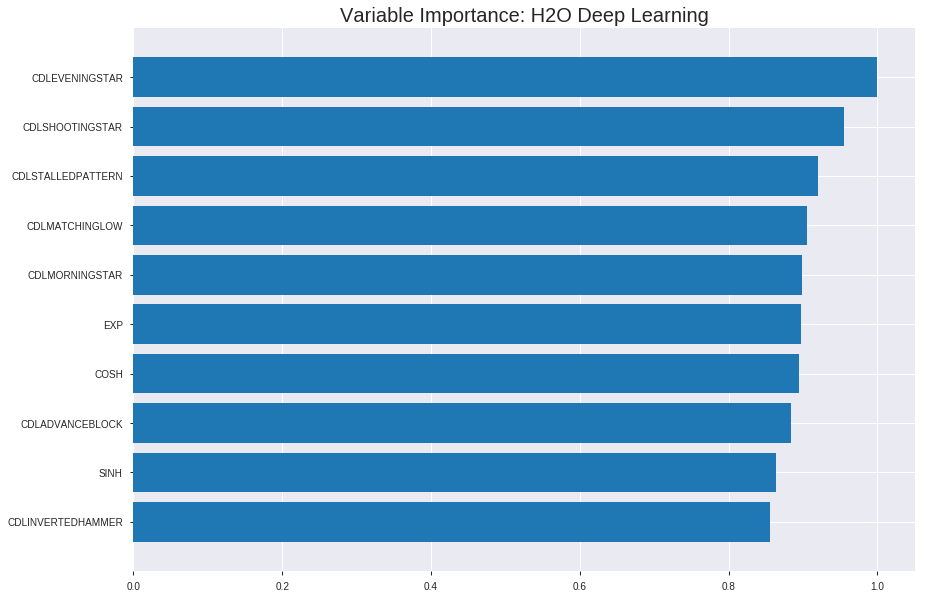

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_112311_model_1


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.2927540363055969
RMSE: 0.5410674969960743
LogLoss: 1.8916356178347826
Mean Per-Class Error: 0.39922922323891397
AUC: 0.6180876757225161
pr_auc: 0.6325458835957203
Gini: 0.2361753514450322
Confusion Matrix (Act/Pred) for max f1 @ threshold = 1.4520126762074034e-05: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      0    2124  1        (2124.0/2124.0)
1      0    2195  0        (0.0/2195.0)
Total  0    4319  0.4918   (2124.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       1.45201e-05  0.673933  399
max f2                       1.45201e-05  0.83785   399
max f0point5                 0.462182     0.59882   198
max accuracy                 0.478978     0.598287  193
max precision                0.99609      0.916667  1
max recall                   1.45201e-05  1         399
max specificity              0.999272     0.999058  0
max absolute_mcc             0.478978     0.211169  193
max min_per_class_accuracy   0.327349     0.587699  258
max mean_per_class_accuracy  0.478978     0.600771  193

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 35.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score        cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  -----------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.982194           1.74406   1.74406            0.886364         0.99414      0.886364                    0.99414             0.0177677       0.0177677                  74.4057   74.4057
    2        0.0201436                   0.951348           1.4643    1.60579            0.744186         0.966571     0.816092                    0.980514            0.0145786       0.0323462                  46.43     60.5786
    3        0.0300996                   0.918999           1.64734   1.61953            0.837209         0.933778     0.823077                    0.965055            0.0164009       0.0487472                  64.7338   61.953
    4        0.0400556                   0.891817           1.37278   1.5582             0.697674         0.904334     0.791908                    0.949963            0.0136674       0.0624146                  37.2782   55.82
    5        0.0500116                   0.862771           1.55582   1.55773            0.790698         0.876983     0.791667                    0.935434            0.0154897       0.0779043                  55.5819   55.7726
    6        0.100023                    0.766519           1.40286   1.4803             0.712963         0.813247     0.752315                    0.874341            0.0701595       0.148064                   40.2864   48.0295
    7        0.150035                    0.688146           1.30266   1.42108            0.662037         0.725194     0.722222                    0.824625            0.0651481       0.213212                   30.266    42.1083
    8        0.200046                    0.631247           1.20246   1.36643            0.611111         0.656255     0.694444                    0.782533            0.0601367       0.273349                   20.2455   36.6426
    9        0.300069                    0.528321           1.1979    1.31025            0.608796         0.578247     0.665895                    0.714437            0.119818        0.393166                   19.79     31.0251
    10       0.400093                    0.429634           1.00205   1.2332             0.509259         0.478296     0.626736                    0.655402            0.100228        0.493394                   0.20459   23.32
    11       0.500116                    0.327099           0.933725  1.1733             0.474537         0.374787     0.596296                    0.599279            0.0933941       0.586788                   -6.62754  17.3305
    12       0.599907                    0.22731            0.945022  1.13533            0.480278         0.277539     0.576997                    0.545759            0.0943052       0.681093                   -5.49784  13.5331
    13       0.699931                    0.133397           0.778863  1.08439            0.395833         0.179402     0.551108                    0.493405            0.0779043       0.758998                   -22.1137  8.43901
    14       0.799954                    0.0262857          0.660439  1.03138            0.335648         0.0817044    0.524168                    0.441928            0.0660592       0.825057                   -33.9561  3.13809
    15       0.899977                    1.35161e-07        0.865403  1.01293            0.439815         0.00457395   0.514793                    0.39332             0.0865604       0.911617                   -13.4597  1.29342
    16       1                           1.19252e-20        0.883622  1                  0.449074         1.71496e-



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.31470643196273845
RMSE: 0.5609870158593142
LogLoss: 0.9421705162664621
Mean Per-Class Error: 0.46775160768532764
AUC: 0.5214673662892386
pr_auc: 0.5280375394136552
Gini: 0.04293473257847724
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0005741283698856703: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    595   1        (595.0/595.0)
1      0    639   0        (0.0/639.0)
Total  0    1234  0.4822   (595.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.000574128  0.682328   399
max f2                       0.000574128  0.843008   399
max f0point5                 0.0593282    0.574903   384
max accuracy                 0.494054     0.529173   180
max precision                0.737209     0.563452   78
max recall                   0.000574128  1          399
max specificity              0.999727     0.994958   0
max absolute_mcc             0.494054     0.0654099  180
max min_per_class_accuracy   0.432322     0.511737   210
max mean_per_class_accuracy  0.494054     0.532248   180

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 44.21 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.991911           1.03985   1.03985            0.538462         0.996976   0.538462                    0.996976            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.978309           0.804643  0.926948           0.416667         0.986417   0.48                        0.991907            0.00782473      0.0187793                  -19.5357  -7.30516
    3        0.0299838                   0.958829           0.643714  0.835089           0.333333         0.971955   0.432432                    0.985436            0.00625978      0.0250391                  -35.6286  -16.4911
    4        0.0405186                   0.937853           1.03985   0.888326           0.538462         0.945707   0.46                        0.975107            0.0109546       0.0359937                  3.98459   -11.1674
    5        0.0502431                   0.90995            1.1265    0.934424           0.583333         0.924558   0.483871                    0.965323            0.0109546       0.0469484                  12.65     -6.55763
    6        0.100486                    0.81252            1.09016   1.01229            0.564516         0.861074   0.524194                    0.913199            0.0547731       0.101721                   9.0161    1.22924
    7        0.149919                    0.746218           1.20301   1.07518            0.622951         0.775786   0.556757                    0.86789             0.0594679       0.161189                   20.3007   7.51766
    8        0.200162                    0.689825           0.840981  1.01639            0.435484         0.716378   0.526316                    0.829858            0.0422535       0.203443                   -15.9019  1.63907
    9        0.299838                    0.588398           1.13042   1.0543             0.585366         0.637218   0.545946                    0.765818            0.112676        0.316119                   13.0425   5.42994
    10       0.400324                    0.503982           1.10573   1.06721            0.572581         0.546765   0.552632                    0.710833            0.111111        0.42723                    10.5735   6.72103
    11       0.5                         0.429326           0.847819  1.02347            0.439024         0.46956    0.529984                    0.662735            0.084507        0.511737                   -15.2181  2.34742
    12       0.599676                    0.3462             0.92632   1.00733            0.479675         0.387687   0.521622                    0.617018            0.0923318       0.604069                   -7.36797  0.732564
    13       0.700162                    0.253988           1.05901   1.01474            0.548387         0.300291   0.525463                    0.571561            0.106416        0.710485                   5.90136   1.47438
    14       0.799838                    0.171158           0.942021  1.00568            0.487805         0.211833   0.52077                     0.526732            0.0938967       0.804382                   -5.79793  0.568105
    15       0.899514                    0.106297           1.05192   1.01081            0.544715         0.139143   0.523423                    0.483783            0.104851        0.909233                   5.19231   1.08052
    16       1                           3.64741e-09        0.903276  1                  0.467742         0.0685375  0.517828             


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 11:23:22  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 11:23:25  6.939 sec         190 obs/sec       0.12526   1             541        0.694985         6.78407             -0.932539      0.493757        0.362019           0.996715         0.491781                         0.712241           5.26713               -1.03173         0.468458          0.479434             0.742747           0.482172
    2019-08-22 11:24:04  45.592 sec        230 obs/sec       2.02547   16            8748       0.641441         3.48246             -0.646234      0.563133        0.538108           1.20742          0.491781                         0.666486           2.23456               -0.779078        0.483475          0.480421             1.03985            0.482172
    2019-08-22 11:24:41  1 min 22.860 sec  236 obs/sec       3.91549   31            16911      0.671208         4.81634             -0.802566      0.538377        0.388874           1.20742          0.491781                         0.691047           6.93591               -0.912615        0.538997          0.273827             1.03985            0.481361
    2019-08-22 11:25:20  2 min  2.307 sec  242 obs/sec       6.02454   48            26020      0.602723         3.6692              -0.453493      0.563585        0.56436            1.52046          0.491781                         0.628138           1.42587               -0.58024         0.462715          0.492244             0.891296           0.482172
    2019-08-22 11:25:56  2 min 37.677 sec  247 obs/sec       7.9912    64            34514      0.564279         1.98217             -0.273989      0.604602        0.618926           1.78878          0.491781                         0.593922           1.15587               -0.412769        0.496699          0.505428             0.594198           0.482172
    2019-08-22 11:26:29  3 min 10.573 sec  252 obs/sec       9.87891   79            42667      0.573137         2.4722              -0.314301      0.595128        0.60105            1.52046          0.491781                         0.597987           1.33257               -0.432173        0.526183          0.528881             1.1884             0.482172
    2019-08-22 11:27:03  3 min 45.831 sec  256 obs/sec       11.8736   95            51282      0.553627         2.25228             -0.226341      0.603234        0.618442           1.65462          0.491781                         0.566324           0.99085               -0.284526        0.496035          0.509125             0.891296           0.482172
    2019-08-22 11:27:46  4 min 28.325 sec  262 obs/sec       14.4892   116           62579      0.574239         1.21747             -0.319357      0.619948        0.577767           1.56518          0.48414                          0.625982           1.55986               -0.569408        0.532514          0.53647              0.742747           0.482172
    2019-08-22 11:28:22

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLEVENINGSTAR            1.0                    1.0                  0.0030911074935313656
CDLSHOOTINGSTAR           0.9548069834709167     0.9548069834709167   0.0029514110214830295
CDLSTALLEDPATTERN         0.9204922914505005     0.9204922914505005   0.0028453406198405
CDLMATCHINGLOW            0.9051952958106995     0.9051952958106995   0.0027980559619897945
CDLMORNINGSTAR            0.8989659547805786     0.8989659547805786   0.0027788003992518253
---                       ---                    ---                  ---
BBANDS_middleband_12_2_5  0.26611265540122986    0.26611265540122986  0.0008225828232342717
BBANDS_upperband_24_0_5   0.26457762718200684    0.26457762718200684  0.0008178378860030493
BBANDS_upperband_12_5_4   0.2641476094722748     0.2641476094722748   0.0008165086550381453
T3_8_8                    0.26411014795303345    0.26411014795303345  0.0008163928574552993
BBANDS_upperband_14_5_2   0.26153281331062317    0.26153281331062317  0.000808426039028807


See the whole table with table.as_data_frame()


('accuracy', 0.5485436893203883)

('F1', 0.6281179138321996)

('auc', 0.5180262045646662)

('logloss', 0.9163817033952256)

('mean_per_class_error', 0.46429628064243444)

('rmse', 0.5580639716462964)

('mse', 0.3114353964496383)

deeplearning prediction progress: |███████████████████████████████████████| 100%


/usr/local/lib/python3.6/dist-packages/pandas/plotting/_matplotlib/converter.py:102: FutureWarning: Using an implicitly registered datetime converter for a matplotlib plotting method. The converter was registered by pandas on import. Future versions of pandas will require you to explicitly register matplotlib converters.

To register the converters:
	>>> from pandas.plotting import register_matplotlib_converters
	>>> register_matplotlib_converters()
  warnings.warn(msg, FutureWarning)


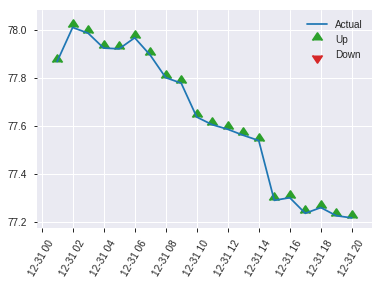


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3114353964496383
RMSE: 0.5580639716462964
LogLoss: 0.9163817033952256
Mean Per-Class Error: 0.46429628064243444
AUC: 0.5180262045646662
pr_auc: 0.4533869610615202
Gini: 0.036052409129332386
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.030229514617819513: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      13   325  0.9615   (325.0/338.0)
1      3    277  0.0107   (3.0/280.0)
Total  16   602  0.5307   (328.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0302295    0.628118   390
max f2                       0.000413895  0.805524   399
max f0point5                 0.0302295    0.515253   390
max accuracy                 0.999275     0.548544   0
max precision                0.999275     1          0
max recall                   0.000413895  1          399
max specificity              0.999275     1          0
max absolute_mcc             0.0302295    0.0869759  390
max min_per_class_accuracy   0.416746     0.528571   206
max mean_per_class_accuracy  0.479928     0.535704   180

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 43.33 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.975931           0.945918  0.945918           0.428571         0.988861  0.428571                    0.988861            0.0107143       0.0107143                  -5.40816   -5.40816
    2        0.0210356                   0.955521           1.47143   1.18846            0.666667         0.964859  0.538462                    0.977783            0.0142857       0.025                      47.1429    18.8462
    3        0.0307443                   0.930281           0.367857  0.929323           0.166667         0.942357  0.421053                    0.966596            0.00357143      0.0285714                  -63.2143   -7.06767
    4        0.0404531                   0.903308           0.735714  0.882857           0.333333         0.921326  0.4                         0.955731            0.00714286      0.0357143                  -26.4286   -11.7143
    5        0.0501618                   0.882517           0.735714  0.854378           0.333333         0.892054  0.387097                    0.943407            0.00714286      0.0428571                  -26.4286   -14.5622
    6        0.100324                    0.812072           0.78318   0.818779           0.354839         0.850367  0.370968                    0.896887            0.0392857       0.0821429                  -21.682    -18.1221
    7        0.150485                    0.739894           1.21037   0.949309           0.548387         0.77592   0.430108                    0.856565            0.0607143       0.142857                   21.0369    -5.06912
    8        0.200647                    0.690187           1.06797   0.978975           0.483871         0.714604  0.443548                    0.821074            0.0535714       0.196429                   6.79724    -2.10253
    9        0.300971                    0.5948             1.28157   1.07984            0.580645         0.644032  0.489247                    0.76206             0.128571        0.325                      28.1567    7.98387
    10       0.399676                    0.512287           1.15785   1.0991             0.52459          0.554279  0.497976                    0.710746            0.114286        0.439286                   15.7845    9.91035
    11       0.5                         0.412558           0.889977  1.05714            0.403226         0.46095   0.478964                    0.660625            0.0892857       0.528571                   -11.0023   5.71429
    12       0.600324                    0.324571           0.854378  1.02326            0.387097         0.363648  0.463612                    0.610996            0.0857143       0.614286                   -14.5622   2.32576
    13       0.699029                    0.247995           0.940749  1.01161            0.42623          0.283716  0.458333                    0.564782            0.0928571       0.707143                   -5.92506   1.16071
    14       0.799353                    0.170953           0.996774  1.00975            0.451613         0.204286  0.45749                     0.519538            0.1             0.807143                   -0.322581  0.974552
    15       0.899676                    0.090052           0.925576  1.00036            0.419355         0.1319    0.453237                    0.476312            0.0928571       0.9                        -7.4424    0.0359712
    16       1                           0.000115617        0.996774  1                  0.451613         0.048024  0.453074          

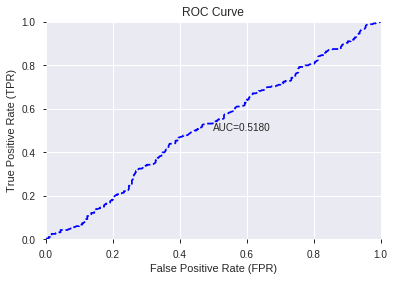

This function is available for GLM models only


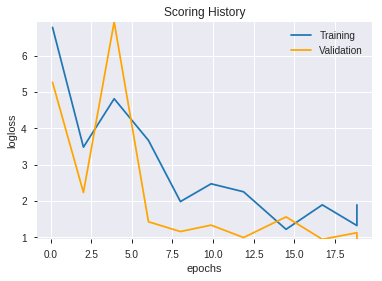

--2019-08-22 12:23:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.204.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.204.35|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 368257676 (351M) [application/zip]
Saving to: ‘h2o-3.24.0.5.zip’

h2o-3.24.0.5.zip    100%[===================>] 351.20M  51.3MB/s    in 7.3s    

2019-08-22 12:23:34 (48.0 MB/s) - ‘h2o-3.24.0.5.zip’ saved [368257676/368257676]

Archive:  h2o-3.24.0.5.zip
   creating: h2o-3.24.0.5/
   creating: h2o-3.24.0.5/bindings/
   creating: h2o-3.24.0.5/bindings/java/
 extracting: h2o-3.24.0.5/bindings/java/h2o-bindings-3.24.0.zip  
  inflating: h2o-3.24.0.5/h2o.jar    
   creating: h2o-3.24.0.5/python/
  inflating: h2o-3.24.0.5/python/h2o-3.24.0.5-py2.py3-none-any.whl  
   creating: h2o-3.24.0.5/R/
  inflating: h2o-3.24.0.5/R/h2o_3.24.0.5.tar.gz  
ERROR: Unk

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_112311_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_112311_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_2_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl

In [10]:
# DeepLearning
features_list = model_train(feature_name='All',model_algo="DeepLearning")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               DeepLearning_1_AutoML_20190822_122429  0.521698  0.700020              0.495562  0.503282  0.253293
1  DeepLearning_grid_1_AutoML_20190822_122429_model_4  0.509430  0.751651              0.500000  0.522353  0.272853
2  DeepLearning_grid_1_AutoML_20190822_122429_model_7  0.508733  0.711831              0.491431  0.504280  0.254298
3  DeepLearning_grid_1_AutoML_20190822_122429_model_2  0.503751  0.735910              0.498521  0.517968  0.268291
4  DeepLearning_grid_1_AutoML_20190822_122429_model_1  0.503371  0.774563              0.497041  0.523092  0.273625
5  DeepLearning_grid_1_AutoML_20190822_122429_model_9  0.500000  0.695206              0.500000  0.501028  0.251029
6  DeepLearning_grid_1_AutoML_20190822_122429_model_8  0.499688  0.690130              0.500000  0.498472  0.248474
7  DeepLearning_grid_1_AutoML_20190822_122429_model_6  0.496756  0.702376              0.495002  0.504681  0.254703
8  DeepLearning_grid_1_AutoML_20190822_122429_model_3  0.472469  0.724377              0.498521  0.510082  0.260183
9  DeepLearning_grid_1_AutoML_20190822_122429_model_5  0.462188  0.709132              0.500000  0.507806  0.257866

variable  relative_importance  scaled_importance  percentage
0      CDLSTICKSANDWICH             1.000000           1.000000    0.031645
1       CDLLADDERBOTTOM             0.937702           0.937702    0.029673
2             CDLONNECK             0.840150           0.840150    0.026586
3                   EXP             0.838805           0.838805    0.026544
4         CDLHANGINGMAN             0.799885           0.799885    0.025312
5                  SINH             0.794684           0.794684    0.025148
6      is_quarter_start             0.792536           0.792536    0.025080
7        CDLRICKSHAWMAN             0.773217           0.773217    0.024468
8          is_month_end             0.770612           0.770612    0.024386
9     CDLLONGLEGGEDDOJI             0.769211           0.769211    0.024341
10       CDL3LINESTRIKE             0.766212           0.766212    0.024247
11         CDLTHRUSTING             0.749419           0.749419    0.023715
12               VAR_30             0.745162           0.745162    0.023580
13   CDLEVENINGDOJISTAR             0.737997           0.737997    0.023354
14                  SIN             0.702626           0.702626    0.022234
15            CDLINNECK             0.702040           0.702040    0.022216
16               VAR_14             0.696332           0.696332    0.022035
17            CORREL_14             0.692504           0.692504    0.021914
18            CDLHAMMER             0.684040           0.684040    0.021646
19          CDLPIERCING             0.676520           0.676520    0.021408
20      CDLUNIQUE3RIVER             0.664908           0.664908    0.021041
21           CDL3INSIDE             0.661816           0.661816    0.020943
22     CDLDRAGONFLYDOJI             0.659026           0.659026    0.020855
23                 COSH             0.657776           0.657776    0.020815
24       CDLHARAMICROSS             0.654437           0.654437    0.020709
25               VAR_20             0.645926           0.645926    0.020440
26      CDLADVANCEBLOCK             0.631584           0.631584    0.019986
27            CORREL_30             0.630793           0.630793    0.019961
28    CDLSTALLEDPATTERN             0.607143           0.607143    0.019213
29        days_in_month             0.605767           0.605767    0.019169
30       is_month_start             0.600093           0.600093    0.018990
31    CDL3WHITESOLDIERS             0.595471           0.595471    0.018844
32            CORREL_24             0.594456           0.594456    0.018811
33       CDLMORNINGSTAR             0.566073           0.566073    0.017913
34  CDLGAPSIDESIDEWHITE             0.542563           0.542563    0.017169
35            CDLTAKURI             0.531483           0.531483    0.016819
36    CDLINVERTEDHAMMER             0.531164           0.531164    0.016809
37         CDLTASUKIGAP             0.516766           0.516766    0.016353
38          CDLDOJISTAR             0.513618           0.513618    0.016253
39   CDLSEPARATINGLINES             0.511612           0.511612    0.016190
40             CORREL_8             0.484728           0.484728    0.015339
41              CDLDOJI             0.469109           0.469109    0.014845
42   CDLMORNINGDOJISTAR             0.449272           0.449272    0.014217
43      CDLHOMINGPIGEON             0.441299           0.441299    0.013965
44    CDLGRAVESTONEDOJI             0.435765           0.435765    0.013790
45      CDLSHOOTINGSTAR             0.418460           0.418460    0.013242
46    CDLDARKCLOUDCOVER             0.397516           0.397516    0.012579
47       CDLEVENINGSTAR             0.387761           0.387761    0.012271
48   CDLIDENTICAL3CROWS             0.385909           0.385909    0.012212
49       CDLMATCHINGLOW             0.338890           0.338890    0.010724

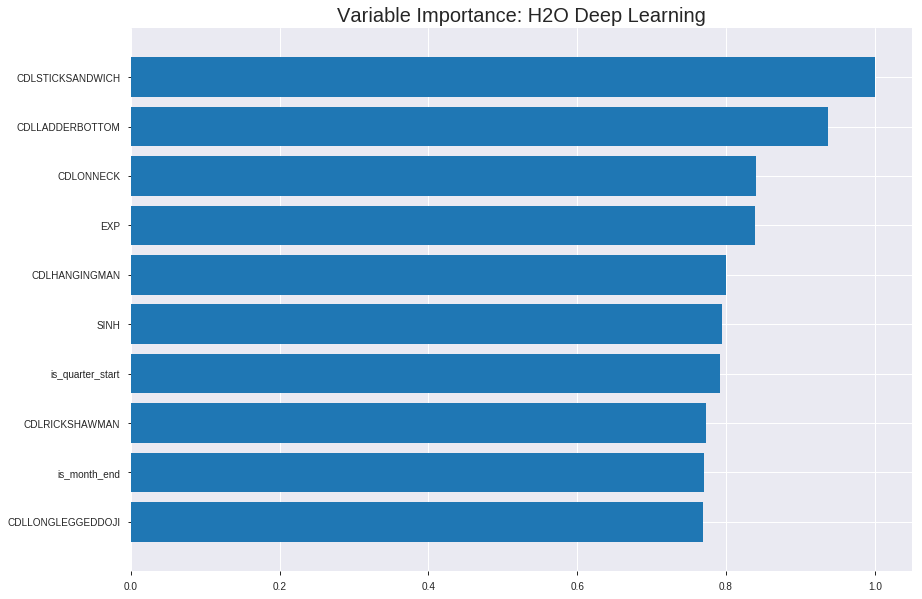

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_1_AutoML_20190822_122429


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.25248577043713694
RMSE: 0.5024796219123089
LogLoss: 0.6998327921961687
Mean Per-Class Error: 0.4533089670497492
AUC: 0.5662530189739564
pr_auc: 0.5759537404524991
Gini: 0.13250603794791282
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.15811277129140994: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      52   2072  0.9755   (2072.0/2124.0)
1      18   2177  0.0082   (18.0/2195.0)
Total  70   4249  0.4839   (2090.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.158113     0.675667  376
max f2                       0.0317793    0.83817   396
max f0point5                 0.383162     0.57526   262
max accuracy                 0.384146     0.550127  261
max precision                0.998874     1         0
max recall                   0.0317793    1         396
max specificity              0.998874     1         0
max absolute_mcc             0.383162     0.104958  262
max min_per_class_accuracy   0.436709     0.542844  208
max mean_per_class_accuracy  0.434135     0.546691  211

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 44.46 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0101875                   0.752203           1.6099    1.6099             0.818182         0.82165   0.818182                    0.82165             0.0164009       0.0164009                  60.9899    60.9899
    2        0.0201436                   0.699815           1.28126   1.44747            0.651163         0.722316  0.735632                    0.772554            0.0127563       0.0291572                  28.1263    44.7469
    3        0.0300996                   0.669111           1.28126   1.39249            0.651163         0.68378   0.707692                    0.74319             0.0127563       0.0419134                  28.1263    39.2493
    4        0.0400556                   0.652856           1.28126   1.36485            0.651163         0.659661  0.693642                    0.722429            0.0127563       0.0546697                  28.1263    36.4847
    5        0.0500116                   0.639035           1.28126   1.34821            0.651163         0.644863  0.685185                    0.706987            0.0127563       0.067426                   28.1263    34.8207
    6        0.100023                    0.581095           1.10225   1.22523            0.560185         0.604725  0.622685                    0.655856            0.0551253       0.122551                   10.225     22.5229
    7        0.150035                    0.550731           1.20246   1.21764            0.611111         0.565416  0.618827                    0.62571             0.0601367       0.182688                   20.2455    21.7638
    8        0.200046                    0.527093           1.09314   1.18651            0.555556         0.538482  0.603009                    0.603903            0.0546697       0.237358                   9.3141     18.6513
    9        0.300069                    0.493804           0.970163  1.1144             0.493056         0.509752  0.566358                    0.572519            0.0970387       0.334396                   -2.98374   11.4396
    10       0.400093                    0.464175           1.0977    1.11022            0.55787          0.478619  0.564236                    0.549044            0.109795        0.444191                   9.76957    11.0221
    11       0.500116                    0.436802           0.992936  1.08676            0.50463          0.450746  0.552315                    0.529384            0.0993166       0.543508                   -0.706361  8.67643
    12       0.599907                    0.411409           0.92676   1.06015            0.470998         0.42429   0.538788                    0.511903            0.0924829       0.635991                   -7.32396   6.01485
    13       0.699931                    0.390089           1.06126   1.06031            0.539352         0.400725  0.538869                    0.496015            0.10615         0.742141                   6.12577    6.0307
    14       0.799954                    0.368568           0.924615  1.04334            0.469907         0.379676  0.530246                    0.481468            0.0924829       0.834624                   -7.53849   4.33406
    15       0.899977                    0.330177           0.874513  1.02458            0.444444         0.353457  0.52071                     0.467241            0.0874715       0.922096                   -12.5487   2.45771
    16       1                           0.00210431         0.778863  1                  0.395833         0.240753  0.508219                    0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.25986097087789384
RMSE: 0.5097656038591598
LogLoss: 0.7186311282547736
Mean Per-Class Error: 0.47082100445812136
AUC: 0.521117555003222
pr_auc: 0.5272376218019935
Gini: 0.04223511000644398
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.012874841288617133: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    595   1        (595.0/595.0)
1      0    639   0        (0.0/639.0)
Total  0    1234  0.4822   (595.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0128748    0.682328   399
max f2                       0.0128748    0.843008   399
max f0point5                 0.0128748    0.573094   399
max accuracy                 0.432432     0.532415   259
max precision                0.663634     0.581395   33
max recall                   0.0128748    1          399
max specificity              0.910009     0.998319   0
max absolute_mcc             0.781631     0.0635051  6
max min_per_class_accuracy   0.502761     0.521008   189
max mean_per_class_accuracy  0.518204     0.529179   174

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 49.12 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.724465           0.742747  0.742747           0.384615         0.799289  0.384615                    0.799289            0.00782473      0.00782473                 -25.7253  -25.7253
    2        0.0202593                   0.694105           1.28743   1.00419            0.666667         0.71107   0.52                        0.756944            0.0125196       0.0203443                  28.7428   0.419405
    3        0.0299838                   0.667553           1.1265    1.04386            0.583333         0.680851  0.540541                    0.732265            0.0109546       0.0312989                  12.65     4.38608
    4        0.0405186                   0.65581            1.1884    1.08144            0.615385         0.661025  0.56                        0.713743            0.0125196       0.0438185                  18.8395   8.14397
    5        0.0502431                   0.647994           0.321857  0.934424           0.166667         0.651303  0.483871                    0.701657            0.00312989      0.0469484                  -67.8143  -6.55763
    6        0.100486                    0.610655           1.12131   1.02787            0.580645         0.626868  0.532258                    0.664262            0.056338        0.103286                   12.1308   2.78661
    7        0.149919                    0.591446           0.949742  1.00211            0.491803         0.600207  0.518919                    0.643142            0.0469484       0.150235                   -5.02578  0.210633
    8        0.200162                    0.578002           0.934424  0.985117           0.483871         0.585674  0.510121                    0.628717            0.0469484       0.197183                   -6.55763  -1.48828
    9        0.299838                    0.555              1.02052   0.996887           0.528455         0.566671  0.516216                    0.608091            0.101721        0.298905                   2.05224   -0.311297
    10       0.400324                    0.53182            1.1836    1.04376            0.612903         0.543869  0.540486                    0.59197             0.118936        0.41784                    18.3603   4.37551
    11       0.5                         0.502733           1.03622   1.04225            0.536585         0.519106  0.539708                    0.577445            0.103286        0.521127                   3.62228   4.22535
    12       0.599676                    0.462455           1.00482   1.03603            0.520325         0.479094  0.536486                    0.561097            0.100156        0.621283                   0.482207  3.60318
    13       0.700162                    0.429487           1.02787   1.03486            0.532258         0.44491   0.53588                     0.544422            0.103286        0.72457                    2.78661   3.48599
    14       0.799838                    0.401511           0.879219  1.01546            0.455285         0.414417  0.525836                    0.528221            0.0876369       0.812207                   -12.0781  1.54639
    15       0.899514                    0.376604           0.91062   1.00385            0.471545         0.389352  0.51982                     0.512833            0.0907668       0.902973                   -8.938    0.38461
    16       1                           0.0128748          0.965571  1                  0.5              0.297525  0.517828                    0.491197  


Scoring History: 


timestamp            duration    training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:24:30  0.000 sec                     0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:24:30  0.172 sec   64462 obs/sec     1         1             4319       0.520641         0.774528            -0.0845626     0.529105        0.531807           1.1627           0.491781                         0.538289           0.832866              -0.160497        0.523674          0.530138             1.03985            0.482172
    2019-08-22 12:24:31  0.765 sec   73327 obs/sec     10        10            43190      0.50248          0.699833            -0.0102161     0.566253        0.575954           1.6099           0.483908                         0.509766           0.718631              -0.0407671       0.521118          0.527238             0.742747           0.482172

Variable Importances: 


variable            relative_importance    scaled_importance    percentage
------------------  ---------------------  -------------------  --------------------
CDLSTICKSANDWICH    1.0                    1.0                  0.03164473004052858
CDLLADDERBOTTOM     0.9377016425132751     0.9377016425132751   0.029673315335892833
CDLONNECK           0.840149998664856      0.840149998664856    0.026586319901299817
EXP                 0.8388048410415649     0.8388048410415649   0.026543752751448813
CDLHANGINGMAN       0.7998849153518677     0.7998849153518677   0.02531214220980091
---                 ---                    ---                  ---
CDLSHOOTINGSTAR     0.41846030950546265    0.41846030950546265  0.013242063526976402
CDLDARKCLOUDCOVER   0.3975156843662262     0.3975156843662262   0.012579276518645197
CDLEVENINGSTAR      0.3877612352371216     0.3877612352371216   0.012270599609260613
CDLIDENTICAL3CROWS  0.3859091103076935     0.3859091103076935   0.012211989615867527
CDLMATCHINGLOW      0.3388896882534027     0.3388896882534027   0.01072407269829782


See the whole table with table.as_data_frame()


('accuracy', 0.5647249190938511)

('F1', 0.6256983240223464)

('auc', 0.5216980135249366)

('logloss', 0.7000202899522349)

('mean_per_class_error', 0.45400464919695693)

('rmse', 0.5032823774376964)

('mse', 0.25329315143933995)

deeplearning prediction progress: |███████████████████████████████████████| 100%


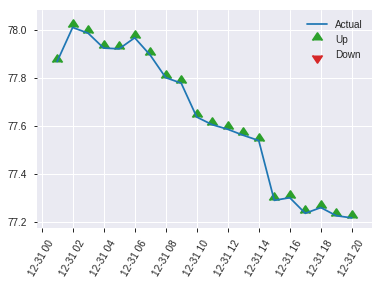


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.25329315143933995
RMSE: 0.5032823774376964
LogLoss: 0.7000202899522349
Mean Per-Class Error: 0.45400464919695693
AUC: 0.5216980135249366
pr_auc: 0.49057268707251445
Gini: 0.04339602704987322
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.2000996391603148: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      3    335  0.9911   (335.0/338.0)
1      0    280  0        (0.0/280.0)
Total  3    615  0.5421   (335.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.2001       0.625698  396
max f2                       0.2001       0.806916  396
max f0point5                 0.2001       0.510949  396
max accuracy                 0.656564     0.564725  17
max precision                0.940728     1         0
max recall                   0.2001       1         396
max specificity              0.940728     1         0
max absolute_mcc             0.656564     0.120356  17
max min_per_class_accuracy   0.484168     0.514286  200
max mean_per_class_accuracy  0.529352     0.545995  130

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 48.08 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.696209           1.57653   1.57653            0.714286         0.782679  0.714286                    0.782679            0.0178571       0.0178571                  57.6531   57.6531
    2        0.0210356                   0.673669           1.83929   1.6978             0.833333         0.681688  0.769231                    0.736068            0.0178571       0.0357143                  83.9286   69.7802
    3        0.0307443                   0.653432           1.83929   1.74248            0.833333         0.662297  0.789474                    0.712772            0.0178571       0.0535714                  83.9286   74.2481
    4        0.0404531                   0.640645           0.367857  1.41257            0.166667         0.648286  0.64                        0.697295            0.00357143      0.0571429                  -63.2143  41.2571
    5        0.0501618                   0.632827           0.735714  1.28157            0.333333         0.635713  0.580645                    0.685376            0.00714286      0.0642857                  -26.4286  28.1567
    6        0.100324                    0.589227           0.925576  1.10357            0.419355         0.611145  0.5                         0.648261            0.0464286       0.110714                   -7.4424   10.3571
    7        0.150485                    0.5622             1.13917   1.11544            0.516129         0.573711  0.505376                    0.623411            0.0571429       0.167857                   13.9171   11.5438
    8        0.200647                    0.548604           1.21037   1.13917            0.548387         0.555536  0.516129                    0.606442            0.0607143       0.228571                   21.0369   13.9171
    9        0.300971                    0.527832           1.17477   1.15104            0.532258         0.538003  0.521505                    0.583629            0.117857        0.346429                   17.477    15.1037
    10       0.399676                    0.502811           0.904567  1.09017            0.409836         0.515513  0.493927                    0.566807            0.0892857       0.435714                   -9.54333  9.01677
    11       0.5                         0.482896           0.78318   1.02857            0.354839         0.49331   0.466019                    0.55206             0.0785714       0.514286                   -21.682   2.85714
    12       0.600324                    0.459096           0.818779  0.993512           0.370968         0.472334  0.450135                    0.538736            0.0821429       0.596429                   -18.1221  -0.648826
    13       0.699029                    0.435439           1.0493    1.00139            0.47541          0.447585  0.453704                    0.525866            0.103571        0.7                        4.92974   0.138889
    14       0.799353                    0.404852           0.925576  0.991874           0.419355         0.421386  0.449393                    0.512753            0.0928571       0.792857                   -7.4424   -0.812608
    15       0.899676                    0.368574           0.925576  0.984481           0.419355         0.387089  0.446043                    0.49874             0.0928571       0.885714                   -7.4424   -1.5519
    16       1                           0.0210976          1.13917   1                  0.516129         0.32017   0.453074                    0.480825    

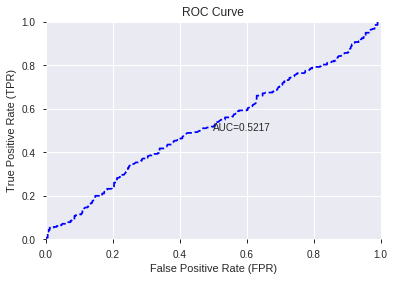

This function is available for GLM models only


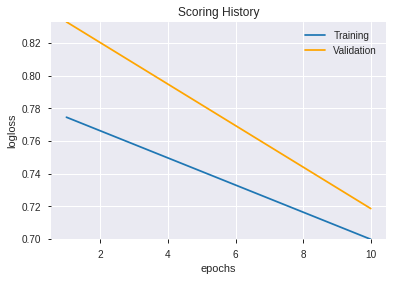

--2019-08-22 12:47:00--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.161.35
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.161.35|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_1_AutoML_20190822_122429',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_1_AutoML_20190822_122429',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_10_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_10_sid_848c'

['CDLSTICKSANDWICH',
 'CDLLADDERBOTTOM',
 'CDLONNECK',
 'EXP',
 'CDLHANGINGMAN',
 'SINH',
 'is_quarter_start',
 'CDLRICKSHAWMAN',
 'is_month_end',
 'CDLLONGLEGGEDDOJI',
 'CDL3LINESTRIKE',
 'CDLTHRUSTING',
 'VAR_30',
 'CDLEVENINGDOJISTAR',
 'SIN',
 'CDLINNECK',
 'VAR_14',
 'CORREL_14',
 'CDLHAMMER',
 'CDLPIERCING',
 'CDLUNIQUE3RIVER',
 'CDL3INSIDE',
 'CDLDRAGONFLYDOJI',
 'COSH',
 'CDLHARAMICROSS',
 'VAR_20',
 'CDLADVANCEBLOCK',
 'CORREL_30',
 'CDLSTALLEDPATTERN',
 'days_in_month',
 'is_month_start',
 'CDL3WHITESOLDIERS',
 'CORREL_24',
 'CDLMORNINGSTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLTAKURI',
 'CDLINVERTEDHAMMER',
 'CDLTASUKIGAP',
 'CDLDOJISTAR',
 'CDLSEPARATINGLINES',
 'CORREL_8',
 'CDLDOJI',
 'CDLMORNINGDOJISTAR',
 'CDLHOMINGPIGEON',
 'CDLGRAVESTONEDOJI',
 'CDLSHOOTINGSTAR',
 'CDLDARKCLOUDCOVER',
 'CDLEVENINGSTAR',
 'CDLIDENTICAL3CROWS',
 'CDLMATCHINGLOW']

In [11]:
# DeepLearning with top DeepLearning features
model_train(feature_name='DLF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190822_124757_model_1  0.50951  0.694467              0.497041  0.50066  0.25066

variable  relative_importance  scaled_importance  percentage
0       CDLSHOOTINGSTAR             0.009043           1.000000    0.073622
1        CDLMORNINGSTAR             0.006058           0.669925    0.049321
2    CDLIDENTICAL3CROWS             0.005204           0.575529    0.042371
3        is_month_start             0.005037           0.556977    0.041006
4        CDLMATCHINGLOW             0.004848           0.536141    0.039472
5             CDLHAMMER             0.004753           0.525591    0.038695
6      CDLSTICKSANDWICH             0.004704           0.520233    0.038300
7           CDLPIERCING             0.004562           0.504550    0.037146
8       CDLLADDERBOTTOM             0.004561           0.504337    0.037130
9    CDLEVENINGDOJISTAR             0.004483           0.495812    0.036502
10      CDLADVANCEBLOCK             0.004365           0.482726    0.035539
11            CORREL_14             0.004072           0.450257    0.033149
12          CDLDOJISTAR             0.003656           0.404267    0.029763
13       CDL3LINESTRIKE             0.003466           0.383323    0.028221
14            CDLONNECK             0.003318           0.366873    0.027010
15         CDLTASUKIGAP             0.003225           0.356604    0.026254
16      CDLUNIQUE3RIVER             0.003223           0.356387    0.026238
17    CDLSTALLEDPATTERN             0.003209           0.354905    0.026129
18    CDL3WHITESOLDIERS             0.003173           0.350906    0.025834
19   CDLMORNINGDOJISTAR             0.003162           0.349658    0.025742
20  CDLGAPSIDESIDEWHITE             0.003140           0.347227    0.025563
21               VAR_30             0.002788           0.308319    0.022699
22            CORREL_30             0.002622           0.289948    0.021346
23     is_quarter_start             0.002402           0.265679    0.019560
24    CDLGRAVESTONEDOJI             0.002323           0.256904    0.018914
25                  SIN             0.002114           0.233757    0.017210
26    CDLINVERTEDHAMMER             0.002062           0.228030    0.016788
27           CDL3INSIDE             0.002060           0.227844    0.016774
28             CORREL_8             0.001728           0.191050    0.014065
29    CDLDARKCLOUDCOVER             0.001584           0.175201    0.012899
30               VAR_20             0.001413           0.156243    0.011503
31         CDLTHRUSTING             0.001348           0.149090    0.010976
32        days_in_month             0.001306           0.144410    0.010632
33       CDLHARAMICROSS             0.001303           0.144108    0.010609
34               VAR_14             0.000949           0.104920    0.007724
35       CDLRICKSHAWMAN             0.000916           0.101283    0.007457
36       CDLEVENINGSTAR             0.000747           0.082618    0.006082
37            CDLTAKURI             0.000598           0.066148    0.004870
38        CDLHANGINGMAN             0.000565           0.062459    0.004598
39                  EXP             0.000547           0.060532    0.004456
40                 SINH             0.000544           0.060213    0.004433
41                 COSH             0.000542           0.059975    0.004415
42            CORREL_24             0.000261           0.028825    0.002122
43         is_month_end             0.000193           0.021355    0.001572
44            CDLINNECK             0.000188           0.020785    0.001530
45     CDLDRAGONFLYDOJI             0.000176           0.019474    0.001434
46      CDLHOMINGPIGEON             0.000127           0.014054    0.001035
47              CDLDOJI             0.000116           0.012881    0.000948
48    CDLLONGLEGGEDDOJI             0.000042           0.004645    0.000342
49   CDLSEPARATINGLINES             0.000000           0.000000    0.000000

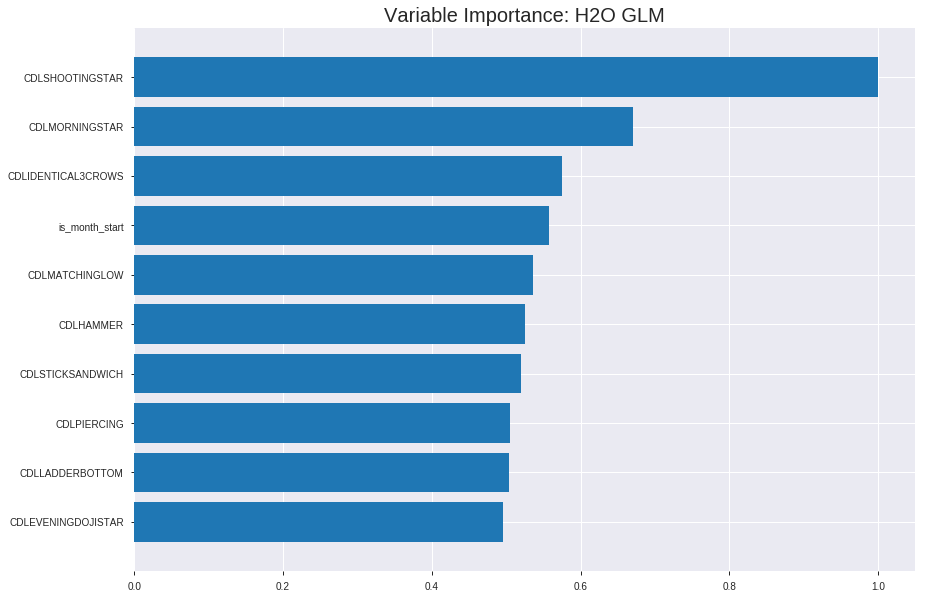

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_124757_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2493948310392985
RMSE: 0.4993944643658943
LogLoss: 0.6919351093670122
Null degrees of freedom: 4318
Residual degrees of freedom: 4269
Null deviance: 5986.238124775795
Residual deviance: 5976.935474712251
AIC: 6076.935474712251
AUC: 0.5377281657936845
pr_auc: 0.551913074156986
Gini: 0.07545633158736909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4821851926721659: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      29   2095  0.9863   (2095.0/2124.0)
1      6    2189  0.0027   (6.0/2195.0)
Total  35   4284  0.4865   (2101.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.482185     0.675722   373
max f2                       0.48042      0.838495   381
max f0point5                 0.505389     0.569555   286
max accuracy                 0.509525     0.527437   165
max precision                0.560669     1          0
max recall                   0.471613     1          395
max specificity              0.560669     1          0
max absolute_mcc             0.509958     0.0790259  155
max min_per_class_accuracy   0.507912     0.514351   213
max mean_per_class_accuracy  0.509525     0.532034   165

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.520488           1.43102   1.43102            0.727273         0.534116  0.727273                    0.534116            0.0145786       0.0145786                  43.1021   43.1021
    2        0.0201436                   0.517983           1.28126   1.357              0.651163         0.518845  0.689655                    0.526568            0.0127563       0.0273349                  28.1263   35.7003
    3        0.0300996                   0.517002           1.14398   1.28654            0.581395         0.517428  0.653846                    0.523545            0.0113895       0.0387244                  14.3985   28.6543
    4        0.0400556                   0.516337           1.14398   1.25111            0.581395         0.516674  0.635838                    0.521837            0.0113895       0.0501139                  14.3985   25.1109
    5        0.0500116                   0.515584           0.869428  1.17513            0.44186          0.516004  0.597222                    0.520676            0.00865604      0.0587699                  -13.0572  17.5127
    6        0.100023                    0.512707           1.22067   1.1979             0.62037          0.514273  0.608796                    0.517474            0.0610478       0.119818                   22.0674   19.79
    7        0.150035                    0.51059            1.08403   1.15994            0.550926         0.511447  0.589506                    0.515465            0.0542141       0.174032                   8.40315   15.9944
    8        0.200046                    0.509724           1.12047   1.15008            0.569444         0.510096  0.584491                    0.514123            0.0560364       0.230068                   12.047    15.0075
    9        0.300069                    0.508897           0.915506  1.07189            0.465278         0.509271  0.544753                    0.512506            0.0915718       0.32164                    -8.44944  7.18855
    10       0.400093                    0.508367           1.04304   1.06467            0.530093         0.508625  0.541088                    0.511536            0.104328        0.425968                   4.30387   6.46738
    11       0.500116                    0.507887           0.906396  1.03302            0.460648         0.50812   0.525                       0.510852            0.0906606       0.516629                   -9.36039  3.30182
    12       0.599907                    0.50746            1.0135    1.02977            0.515081         0.507669  0.52335                     0.510323            0.101139        0.617768                   1.35015   2.97717
    13       0.699931                    0.507007           1.0066    1.02646            0.511574         0.507218  0.521667                    0.509879            0.100683        0.718451                   0.660065  2.64605
    14       0.799954                    0.506575           0.979272  1.02056            0.497685         0.506808  0.518669                    0.509495            0.0979499       0.816401                   -2.07279  2.05602
    15       0.899977                    0.505886           0.988382  1.01698            0.502315         0.506271  0.516851                    0.509137            0.098861        0.915262                   -1.16184  1.69839
    16       1                           0.430695           0.847184  1                  0.430556         0.499966  0.508219                    0.508219           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24998311468902762
RMSE: 0.49998311440390425
LogLoss: 0.6931144295656074
Null degrees of freedom: 1233
Residual degrees of freedom: 1184
Null deviance: 1709.574001855587
Residual deviance: 1710.6064121679192
AIC: 1810.6064121679192
AUC: 0.49686879446614324
pr_auc: 0.5093225347521226
Gini: -0.006262411067713525
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42934929144859885: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    595   1        (595.0/595.0)
1      0    639   0        (0.0/639.0)
Total  0    1234  0.4822   (595.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.429349     0.682328   399
max f2                       0.429349     0.843008   399
max f0point5                 0.48223      0.573283   392
max accuracy                 0.507201     0.518639   285
max precision                0.584283     1          0
max recall                   0.429349     1          399
max specificity              0.584283     1          0
max absolute_mcc             0.511343     0.0468072  130
max min_per_class_accuracy   0.508496     0.500782   227
max mean_per_class_accuracy  0.509765     0.510447   173

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.532378           1.03985   1.03985            0.538462         0.545786  0.538462                    0.545786            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.530809           0.643714  0.849703           0.333333         0.531327  0.44                        0.538846            0.00625978      0.0172144                  -35.6286  -15.0297
    3        0.0299838                   0.521528           1.1265    0.939475           0.583333         0.525871  0.486486                    0.534638            0.0109546       0.028169                   12.65     -6.05253
    4        0.0405186                   0.51906            0.445648  0.81108            0.230769         0.519916  0.42                        0.53081             0.00469484      0.0328638                  -55.4352  -18.892
    5        0.0502431                   0.518177           1.28743   0.903276           0.666667         0.518628  0.467742                    0.528452            0.0125196       0.0453834                  28.7428   -9.67237
    6        0.100486                    0.513518           0.903276  0.903276           0.467742         0.515943  0.467742                    0.522198            0.0453834       0.0907668                  -9.67237  -9.67237
    7        0.149919                    0.511321           0.854768  0.887282           0.442623         0.512076  0.459459                    0.51886             0.0422535       0.13302                    -14.5232  -11.2718
    8        0.200162                    0.510201           1.37049   1.00857            0.709677         0.510718  0.522267                    0.516817            0.0688576       0.201878                   37.0488   0.857235
    9        0.299838                    0.50943            0.973421  0.996887           0.504065         0.509779  0.516216                    0.514477            0.0970266       0.298905                   -2.65786  -0.311297
    10       0.400324                    0.508976           1.02787   1.00466            0.532258         0.509211  0.520243                    0.513155            0.103286        0.402191                   2.78661   0.466316
    11       0.5                         0.50847            0.989122  1.00156            0.512195         0.508718  0.518639                    0.512271            0.0985915       0.500782                   -1.08783  0.156495
    12       0.599676                    0.508053           0.942021  0.991668           0.487805         0.508293  0.513514                    0.51161             0.0938967       0.594679                   -5.79793  -0.833228
    13       0.700162                    0.507594           1.02787   0.996863           0.532258         0.50782   0.516204                    0.511066            0.103286        0.697966                   2.78661   -0.313714
    14       0.799838                    0.507042           1.03622   1.00177            0.536585         0.507321  0.518744                    0.510599            0.103286        0.801252                   3.62228   0.17679
    15       0.899514                    0.506504           0.91062   0.991668           0.471545         0.506814  0.513514                    0.51018             0.0907668       0.892019                   -8.938    -0.833228
    16       1                           0.429349           1.07459   1                  0.556452         0.500585  0.517828                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 12:47:58  0.000 sec   2            2.1       50            1.38387           1.38623
    2019-08-22 12:47:58  0.050 sec   4            1.3       51            1.38286           1.3868
    2019-08-22 12:47:58  0.096 sec   6            0.8       51            1.38158           1.38775
    2019-08-22 12:47:58  0.140 sec   8            0.5       51            1.38007           1.38923
    2019-08-22 12:47:58  0.186 sec   10           0.31      51            1.3785            1.39135

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5598705501618123)

('F1', 0.625)

('auc', 0.5095097210481826)

('logloss', 0.6944667288625486)

('mean_per_class_error', 0.47579247675401515)

('rmse', 0.5006596507091006)

('mse', 0.2506600858481586)

glm prediction progress: |████████████████████████████████████████████████| 100%


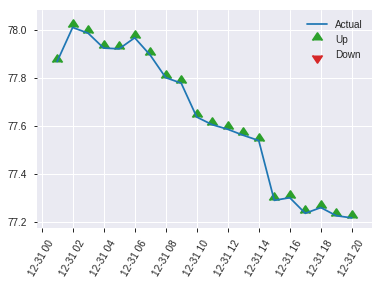


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2506600858481586
RMSE: 0.5006596507091006
LogLoss: 0.6944667288625486
Null degrees of freedom: 617
Residual degrees of freedom: 568
Null deviance: 858.8040410176391
Residual deviance: 858.3608768741101
AIC: 958.3608768741101
AUC: 0.5095097210481826
pr_auc: 0.4869803265280592
Gini: 0.01901944209636519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47956054238960866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    336  0.9941   (336.0/338.0)
1      0    280  0        (0.0/280.0)
Total  2    616  0.5437   (336.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479561     0.625     397
max f2                       0.479561     0.806452  397
max f0point5                 0.479561     0.510204  397
max accuracy                 0.512353     0.559871  41
max precision                0.543868     1         0
max recall                   0.479561     1         397
max specificity              0.543868     1         0
max absolute_mcc             0.51947      0.1176    6
max min_per_class_accuracy   0.508357     0.497041  217
max mean_per_class_accuracy  0.50969      0.524208  129

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.519457           2.20714   2.20714            1                0.527869  1                           0.527869            0.025           0.025                      120.714   120.714
    2        0.0210356                   0.518456           1.10357   1.6978             0.5              0.519014  0.769231                    0.523782            0.0107143       0.0357143                  10.3571   69.7802
    3        0.0307443                   0.516855           0.735714  1.39398            0.333333         0.517462  0.631579                    0.521786            0.00714286      0.0428571                  -26.4286  39.3985
    4        0.0404531                   0.515299           1.10357   1.32429            0.5              0.516166  0.6                         0.520437            0.0107143       0.0535714                  10.3571   32.4286
    5        0.0501618                   0.51408            1.10357   1.28157            0.5              0.514849  0.580645                    0.519355            0.0107143       0.0642857                  10.3571   28.1567
    6        0.100324                    0.511541           1.06797   1.17477            0.483871         0.512354  0.532258                    0.515855            0.0535714       0.117857                   6.79724   17.477
    7        0.150485                    0.510949           1.06797   1.13917            0.483871         0.511265  0.516129                    0.514325            0.0535714       0.171429                   6.79724   13.9171
    8        0.200647                    0.510234           0.925576  1.08577            0.419355         0.510519  0.491935                    0.513374            0.0464286       0.217857                   -7.4424   8.57719
    9        0.300971                    0.509336           0.925576  1.03237            0.419355         0.509748  0.467742                    0.512165            0.0928571       0.310714                   -7.4424   3.23733
    10       0.399676                    0.508763           0.940749  1.00975            0.42623          0.509021  0.45749                     0.511389            0.0928571       0.403571                   -5.92506  0.974552
    11       0.5                         0.508357           0.925576  0.992857           0.419355         0.50857   0.449838                    0.510823            0.0928571       0.496429                   -7.4424   -0.714286
    12       0.600324                    0.508001           1.03237   0.999461           0.467742         0.508192  0.45283                     0.510383            0.103571        0.6                        3.23733   -0.0539084
    13       0.699029                    0.507622           1.01311   1.00139            0.459016         0.507807  0.453704                    0.51002             0.1             0.7                        1.31148   0.138889
    14       0.799353                    0.507182           0.889977  0.987406           0.403226         0.507424  0.447368                    0.509694            0.0892857       0.789286                   -11.0023  -1.2594
    15       0.899676                    0.506585           1.03237   0.99242            0.467742         0.506941  0.44964                     0.509387            0.103571        0.892857                   3.23733   -0.757965
    16       1                           0.473078           1.06797   1                  0.483871         0.502246  0.453074                    0.50867  

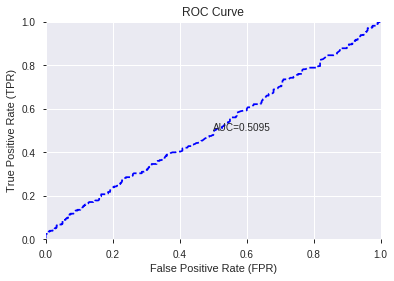

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


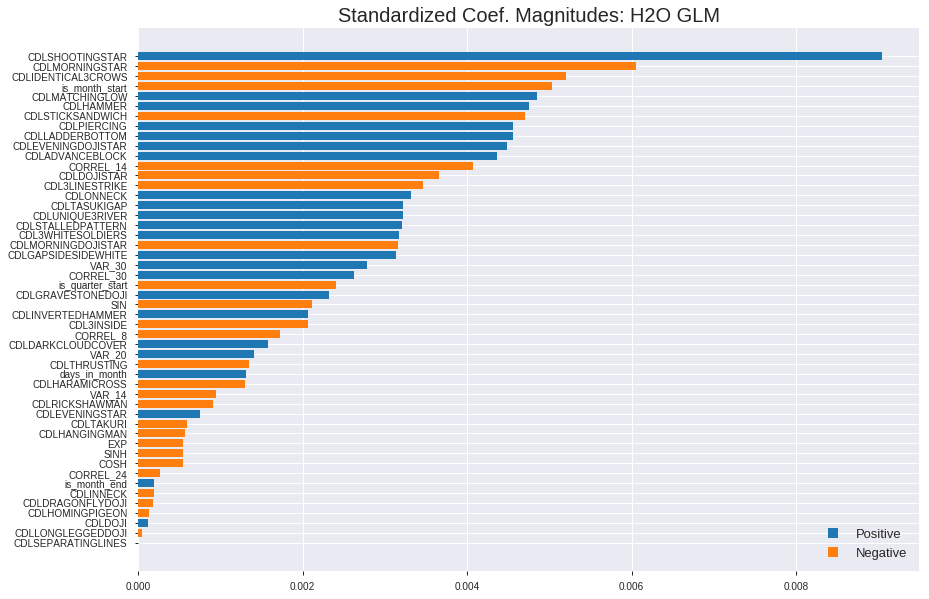

'log_likelihood'
--2019-08-22 12:48:09--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.105.99
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.105.99|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_124757_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_124757_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_18_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_18_s

['CDLSHOOTINGSTAR',
 'CDLMORNINGSTAR',
 'CDLIDENTICAL3CROWS',
 'is_month_start',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'CDLSTICKSANDWICH',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'CORREL_14',
 'CDLDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLONNECK',
 'CDLTASUKIGAP',
 'CDLUNIQUE3RIVER',
 'CDLSTALLEDPATTERN',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'VAR_30',
 'CORREL_30',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'SIN',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CORREL_8',
 'CDLDARKCLOUDCOVER',
 'VAR_20',
 'CDLTHRUSTING',
 'days_in_month',
 'CDLHARAMICROSS',
 'VAR_14',
 'CDLRICKSHAWMAN',
 'CDLEVENINGSTAR',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'EXP',
 'SINH',
 'COSH',
 'CORREL_24',
 'is_month_end',
 'CDLINNECK',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLSEPARATINGLINES']

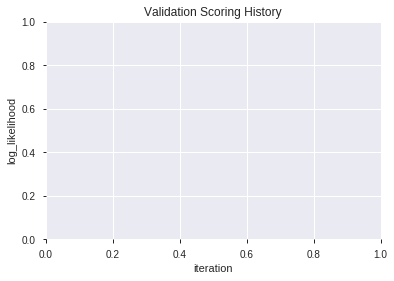

In [12]:
# GLM with top DeepLearning features
model_train(feature_name='DLF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_124906  0.515638  0.703729              0.497041  0.505092  0.255118
1  XGBoost_grid_1_AutoML_20190822_124906_model_5  0.493555  0.736611              0.498521  0.519793  0.270185
2  XGBoost_grid_1_AutoML_20190822_124906_model_4  0.492572  0.702099              0.494083  0.504411  0.254431
3  XGBoost_grid_1_AutoML_20190822_124906_model_7  0.490971  0.712709              0.495869  0.509423  0.259512
4  XGBoost_grid_1_AutoML_20190822_124906_model_2  0.484547  0.702211              0.494389  0.504471  0.254491
5               XGBoost_2_AutoML_20190822_124906  0.482888  0.714160              0.500000  0.510038  0.260138
6  XGBoost_grid_1_AutoML_20190822_124906_model_3  0.477848  0.713927              0.500000  0.510058  0.260159
7  XGBoost_grid_1_AutoML_20190822_124906_model_1  0.467049  0.709073              0.497041  0.507737  0.257797
8  XGBoost_grid_1_AutoML_20190822_124906_model_6  0.463810  0.709750              0.495562  0.508107  0.258173
9               XGBoost_3_AutoML_20190822_124906  0.456725  0.712599              0.494083  0.509481  0.259571

variable  relative_importance  scaled_importance  percentage
0           CORREL_14          1171.553101           1.000000    0.127244
1           CORREL_30          1067.126587           0.910865    0.115902
2            CORREL_8          1014.714355           0.866127    0.110209
3              VAR_14           983.715088           0.839668    0.106842
4           CORREL_24           940.147705           0.802480    0.102111
5              VAR_30           924.022827           0.788716    0.100359
6                COSH           878.686890           0.750019    0.095435
7              VAR_20           803.536255           0.685873    0.087273
8                 SIN           778.232056           0.664274    0.084525
9                 EXP           259.013580           0.221086    0.028132
10      days_in_month           111.490883           0.095165    0.012109
11               SINH            99.751137           0.085144    0.010834
12            CDLDOJI            48.584961           0.041471    0.005277
13     CDLMATCHINGLOW            24.496653           0.020910    0.002661
14          CDLHAMMER            24.415607           0.020840    0.002652
15     is_month_start            18.022903           0.015384    0.001957
16     CDLRICKSHAWMAN            17.750090           0.015151    0.001928
17    CDLADVANCEBLOCK            14.289270           0.012197    0.001552
18  CDLLONGLEGGEDDOJI            10.248856           0.008748    0.001113
19    CDLSHOOTINGSTAR             6.090463           0.005199    0.000661
20       is_month_end             5.851241           0.004994    0.000636
21      CDLHANGINGMAN             5.418504           0.004625    0.000589

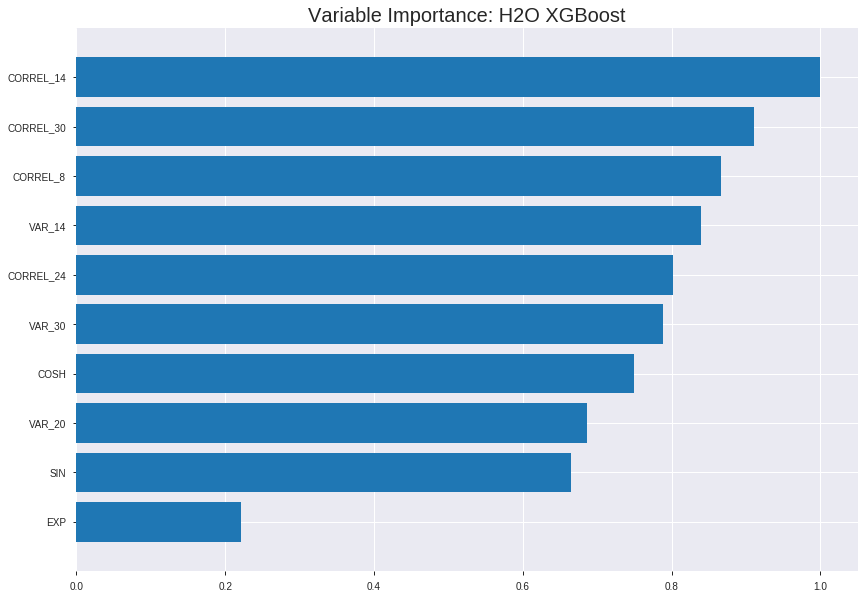

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_124906


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2039323144199416
RMSE: 0.45158865621264405
LogLoss: 0.5992674459732529
Mean Per-Class Error: 0.2044506003629204
AUC: 0.8756903422862266
pr_auc: 0.8767327911613326
Gini: 0.7513806845724531
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4913700342178345: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1516  608   0.2863   (608.0/2124.0)
1      312   1883  0.1421   (312.0/2195.0)
Total  1828  2491  0.213    (920.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49137      0.803671  222
max f2                       0.447407     0.876894  275
max f0point5                 0.527857     0.810782  175
max accuracy                 0.510668     0.795323  196
max precision                0.763822     1         0
max recall                   0.31897      1         385
max specificity              0.763822     1         0
max absolute_mcc             0.510668     0.591113  196
max min_per_class_accuracy   0.508219     0.791344  199
max mean_per_class_accuracy  0.510668     0.795549  196

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.690046           1.96765    1.96765            1                0.711503  1                           0.711503            0.0200456       0.0200456                  96.7654   96.7654
    2        0.0201436                   0.672522           1.96765    1.96765            1                0.679995  1                           0.69593             0.01959         0.0396355                  96.7654   96.7654
    3        0.0300996                   0.658918           1.96765    1.96765            1                0.665338  1                           0.685811            0.01959         0.0592255                  96.7654   96.7654
    4        0.0400556                   0.650016           1.92189    1.95628            0.976744         0.654569  0.99422                     0.678046            0.0191344       0.0783599                  92.1894   95.628
    5        0.0500116                   0.642278           1.92189    1.94943            0.976744         0.646272  0.990741                    0.67172             0.0191344       0.0974943                  92.1894   94.9435
    6        0.100023                    0.616063           1.85834    1.90389            0.944444         0.627763  0.967593                    0.649742            0.0929385       0.190433                   85.834    90.3887
    7        0.150035                    0.596657           1.84012    1.88263            0.935185         0.6061    0.95679                     0.635195            0.0920273       0.28246                    84.0121   88.2632
    8        0.200046                    0.579923           1.69437    1.83557            0.861111         0.58793   0.93287                     0.623378            0.084738        0.367198                   69.4369   83.5566
    9        0.300069                    0.55515            1.63516    1.76876            0.831019         0.567848  0.89892                     0.604868            0.163554        0.530752                   63.5157   76.8763
    10       0.400093                    0.53117            1.3892     1.67387            0.706019         0.543168  0.850694                    0.589443            0.138952        0.669704                   38.92     67.3872
    11       0.500116                    0.508374           1.19335    1.57777            0.606481         0.520015  0.801852                    0.575557            0.119362        0.789066                   19.3346   57.7767
    12       0.599907                    0.48539            0.844585   1.45581            0.429234         0.497125  0.739869                    0.562511            0.0842825       0.873349                   -15.5415  45.5806
    13       0.699931                    0.459848           0.664994   1.3428             0.337963         0.473245  0.682435                    0.549754            0.0665148       0.939863                   -33.5006  34.2795
    14       0.799954                    0.433398           0.37349    1.2216             0.189815         0.446594  0.620839                    0.536855            0.0373576       0.977221                   -62.651   22.1597
    15       0.899977                    0.397072           0.168526   1.10456            0.0856481        0.416301  0.561358                    0.523457            0.0168565       0.994077                   -83.1474  10.4559
    16       1                           0.266237           0.0592118  1                  0.0300926        0.362586  0.508219                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25451242291845055
RMSE: 0.5044922426742066
LogLoss: 0.702447306924584
Mean Per-Class Error: 0.4819413211293907
AUC: 0.5014452729448587
pr_auc: 0.5124470858262119
Gini: 0.0028905458897174885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31322336196899414: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    595   1        (595.0/595.0)
1      0    639   0        (0.0/639.0)
Total  0    1234  0.4822   (595.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.313223     0.682328   399
max f2                       0.313223     0.843008   399
max f0point5                 0.313223     0.573094   399
max accuracy                 0.492842     0.52107    215
max precision                0.660821     0.714286   5
max recall                   0.313223     1          399
max specificity              0.690091     0.998319   0
max absolute_mcc             0.613343     0.0517291  34
max min_per_class_accuracy   0.506603     0.508607   188
max mean_per_class_accuracy  0.492842     0.518059   215

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 50.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.645629           1.03985   1.03985            0.538462         0.663482  0.538462                    0.663482            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.631594           0.321857  0.695211           0.166667         0.63655   0.36                        0.650554            0.00312989      0.0140845                  -67.8143  -30.4789
    3        0.0299838                   0.624461           0.965571  0.782896           0.5              0.628349  0.405405                    0.643353            0.00938967      0.0234742                  -3.44288  -21.7104
    4        0.0405186                   0.61845            1.33694   0.926948           0.692308         0.622105  0.48                        0.637828            0.0140845       0.0375587                  33.6945   -7.30516
    5        0.0502431                   0.614426           0.482786  0.840981           0.25             0.61606   0.435484                    0.633615            0.00469484      0.0422535                  -51.7214  -15.9019
    6        0.100486                    0.589788           1.05901   0.949997           0.548387         0.6012    0.491935                    0.617408            0.0532081       0.0954617                  5.90136   -5.00025
    7        0.149919                    0.575373           1.07637   0.991668           0.557377         0.58299   0.513514                    0.606059            0.0532081       0.14867                    7.63745   -0.833228
    8        0.200162                    0.564155           0.934424  0.977299           0.483871         0.569892  0.506073                    0.596981            0.0469484       0.195618                   -6.55763  -2.27012
    9        0.299838                    0.542325           0.989122  0.981229           0.512195         0.553562  0.508108                    0.582547            0.0985915       0.29421                    -1.08783  -1.87709
    10       0.400324                    0.523814           1.13688   1.0203             0.58871          0.532115  0.52834                     0.569888            0.114241        0.408451                   13.6882   2.02999
    11       0.5                         0.506184           1.00482   1.01721            0.520325         0.515555  0.526742                    0.559057            0.100156        0.508607                   0.482207  1.72144
    12       0.599676                    0.489598           1.03622   1.02037            0.536585         0.498209  0.528378                    0.548943            0.103286        0.611894                   3.62228   2.03739
    13       0.700162                    0.470319           0.903276  1.00357            0.467742         0.479888  0.519676                    0.539032            0.0907668       0.70266                    -9.67237  0.356822
    14       0.799838                    0.449349           0.989122  1.00177            0.512195         0.459927  0.518744                    0.529174            0.0985915       0.801252                   -1.08783  0.17679
    15       0.899514                    0.418023           0.957721  0.996887           0.495935         0.433644  0.516216                    0.518588            0.0954617       0.896714                   -4.2279   -0.311297
    16       1                           0.313223           1.02787   1                  0.532258         0.383989  0.517828                    0.505


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:49:16  8.572 sec   0                  0.5              0.693147            0.5             0                  1                0.491781                         0.5                0.693147              0.5               0                    1                  0.482172
    2019-08-22 12:49:16  8.810 sec   5                  0.494817         0.682825            0.688749        0.68397            1.65462          0.408659                         0.500489           0.694127              0.486606          0.521106             1.03985            0.47893
    2019-08-22 12:49:16  8.965 sec   10                 0.489045         0.671423            0.747711        0.74873            1.8802           0.353786                         0.500681           0.694515              0.50059           0.518792             0.742747           0.481361
    2019-08-22 12:49:16  9.119 sec   15                 0.483431         0.66042             0.784372        0.78637            1.87821          0.30771                          0.501234           0.695624              0.48658           0.509339             0.891296           0.47893
    2019-08-22 12:49:16  9.294 sec   20                 0.478134         0.650102            0.809985        0.811479           1.92293          0.281547                         0.501425           0.696011              0.490278          0.51381              0.891296           0.47812
    2019-08-22 12:49:17  9.471 sec   25                 0.474447         0.642954            0.821174        0.823086           1.96765          0.270201                         0.501608           0.696388              0.493782          0.512934             1.03985            0.479741
    2019-08-22 12:49:17  9.695 sec   30                 0.469682         0.633761            0.833954        0.833725           1.96765          0.247048                         0.50172            0.696623              0.499271          0.517621             1.1884             0.481361
    2019-08-22 12:49:17  9.866 sec   35                 0.466064         0.626819            0.843222        0.84234            1.96765          0.24126                          0.502209           0.697639              0.501236          0.519761             0.891296           0.481361
    2019-08-22 12:49:17  10.070 sec  40                 0.460288         0.615804            0.85924         0.860537           1.96765          0.223431                         0.502581           0.698439              0.504892          0.520158             1.03985            0.480551
    2019-08-22 12:49:17  10.340 sec  45                 0.455842         0.607323            0.867048        0.868908           1.96765          0.225515                         0.503366           0.700077              0.504366          0.518654             1.1884             0.480551
    2019-08-22 12:49:18  10.547 sec  50                 0.451589         0.599267            0.87569         0.876733           1.96765          0.213012                         0.504492           0.702447              0.501445          0.512447             1.03985            0.482172

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CORREL_14          1171.5531005859375     1.0                   0.12724371318875535
CORREL_30          1067.1265869140625     0.910864890699664     0.11590183090589505
CORREL_8           1014.71435546875       0.8661274977303661    0.11020927890609707
VAR_14             983.715087890625       0.839667521172222     0.10684241323795138
CORREL_24          940.147705078125       0.8024798061717578    0.10211051029628714
---                ---                    ---                   ---
CDLADVANCEBLOCK    14.289270401000977     0.012196861067461968  0.0015519738914712272
CDLLONGLEGGEDDOJI  10.248855590820312     0.00874809309598897   0.0011131398488545515
CDLSHOOTINGSTAR    6.090463161468506      0.005198623227937716  0.0006614921229921082
is_month_end       5.851241111755371      0.004994430989793759  0.0006355099444063486
CDLHANGINGMAN      5.418504238128662      0.00462506072957228   0.0005885099009542707


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5469255663430421)

('F1', 0.625)

('auc', 0.5156382079459002)

('logloss', 0.7037292315963504)

('mean_per_class_error', 0.4722633136094674)

('rmse', 0.5050921844676026)

('mse', 0.25511811481025476)

xgboost prediction progress: |████████████████████████████████████████████| 100%


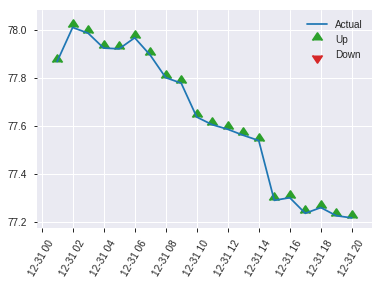


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25511811481025476
RMSE: 0.5050921844676026
LogLoss: 0.7037292315963504
Mean Per-Class Error: 0.4722633136094674
AUC: 0.5156382079459002
pr_auc: 0.4571805980548855
Gini: 0.03127641589180041
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33335456252098083: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    336  0.9941   (336.0/338.0)
1      0    280  0        (0.0/280.0)
Total  2    616  0.5437   (336.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.333355     0.625      397
max f2                       0.333355     0.806452   397
max f0point5                 0.390057     0.511533   384
max accuracy                 0.673331     0.546926   6
max precision                0.673331     0.5        6
max recall                   0.333355     1          397
max specificity              0.69087      0.997041   0
max absolute_mcc             0.679456     0.0734626  3
max min_per_class_accuracy   0.519654     0.511834   200
max mean_per_class_accuracy  0.541582     0.527737   155

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 51.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.673365           0.945918  0.945918           0.428571         0.68022   0.428571                    0.68022             0.0107143       0.0107143                  -5.40816   -5.40816
    2        0.0210356                   0.655814           1.10357   1.01868            0.5              0.663432  0.461538                    0.672472            0.0107143       0.0214286                  10.3571    1.86813
    3        0.0307443                   0.646235           0.735714  0.929323           0.333333         0.649387  0.421053                    0.665182            0.00714286      0.0285714                  -26.4286   -7.06767
    4        0.0404531                   0.642371           1.10357   0.971143           0.5              0.643975  0.44                        0.660092            0.0107143       0.0392857                  10.3571    -2.88571
    5        0.0501618                   0.634815           0.367857  0.854378           0.166667         0.639792  0.387097                    0.656163            0.00357143      0.0428571                  -63.2143   -14.5622
    6        0.100324                    0.606376           0.996774  0.925576           0.451613         0.6193    0.419355                    0.637731            0.05            0.0928571                  -0.322581  -7.4424
    7        0.150485                    0.590336           1.13917   0.996774           0.516129         0.597731  0.451613                    0.624398            0.0571429       0.15                       13.9171    -0.322581
    8        0.200647                    0.575922           1.21037   1.05017            0.548387         0.582772  0.475806                    0.613991            0.0607143       0.210714                   21.0369    5.01728
    9        0.300971                    0.550361           1.06797   1.05611            0.483871         0.562033  0.478495                    0.596672            0.107143        0.317857                   6.79724    5.6106
    10       0.399676                    0.535239           0.976932  1.03655            0.442623         0.541431  0.469636                    0.583029            0.0964286       0.414286                   -2.30679   3.65529
    11       0.5                         0.519493           0.996774  1.02857            0.451613         0.526717  0.466019                    0.57173             0.1             0.514286                   -0.322581  2.85714
    12       0.600324                    0.500539           1.06797   1.03516            0.483871         0.509723  0.469003                    0.561368            0.107143        0.621429                   6.79724    3.51559
    13       0.699029                    0.482521           0.940749  1.02183            0.42623          0.490535  0.462963                    0.551366            0.0928571       0.714286                   -5.92506   2.18254
    14       0.799353                    0.45895            0.854378  1.00081            0.387097         0.47117   0.453441                    0.541301            0.0857143       0.8                        -14.5622   0.0809717
    15       0.899676                    0.429072           1.06797   1.0083             0.483871         0.444364  0.456835                    0.530491            0.107143        0.907143                   6.79724    0.829908
    16       1                           0.298381           0.925576  1                  0.419355         0.398705  0.453074            

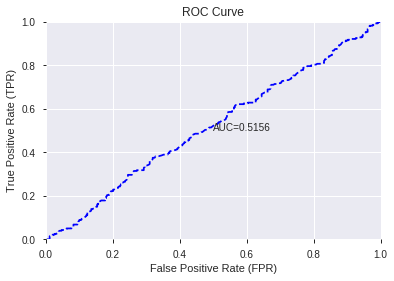

This function is available for GLM models only


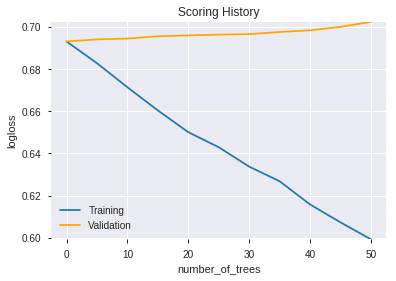

--2019-08-22 12:49:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.179
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.179|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:112)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoMo

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_124906',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_124906',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_26_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_26_sid_848c',
   'type

['CORREL_14',
 'CORREL_30',
 'CORREL_8',
 'VAR_14',
 'CORREL_24',
 'VAR_30',
 'COSH',
 'VAR_20',
 'SIN',
 'EXP',
 'days_in_month',
 'SINH',
 'CDLDOJI',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'CDLADVANCEBLOCK',
 'CDLLONGLEGGEDDOJI',
 'CDLSHOOTINGSTAR',
 'is_month_end',
 'CDLHANGINGMAN']

In [13]:
# XGBoost with top DeepLearning features
model_train(feature_name='DLF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190822_125044_model_1  0.499783  0.695974              0.494083  0.501408  0.25141

variable  relative_importance  scaled_importance  percentage
0          CDLXSIDEGAP3METHODS             0.007474           1.000000    0.017159
1                          BOP             0.006800           0.909881    0.015613
2                    CDLHARAMI             0.006739           0.901783    0.015474
3              CDLSHOOTINGSTAR             0.006617           0.885389    0.015193
4                 CDLSHORTLINE             0.005820           0.778771    0.013363
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_24_2_4             0.000000           0.000000    0.000000
1036  BBANDS_middleband_24_2_5             0.000000           0.000000    0.000000
1037  BBANDS_middleband_30_2_3             0.000000           0.000000    0.000000
1038  BBANDS_middleband_30_2_4             0.000000           0.000000    0.000000
1039  BBANDS_middleband_30_2_5             0.000000           0.000000    0.000000

[1040 rows x 4 columns]

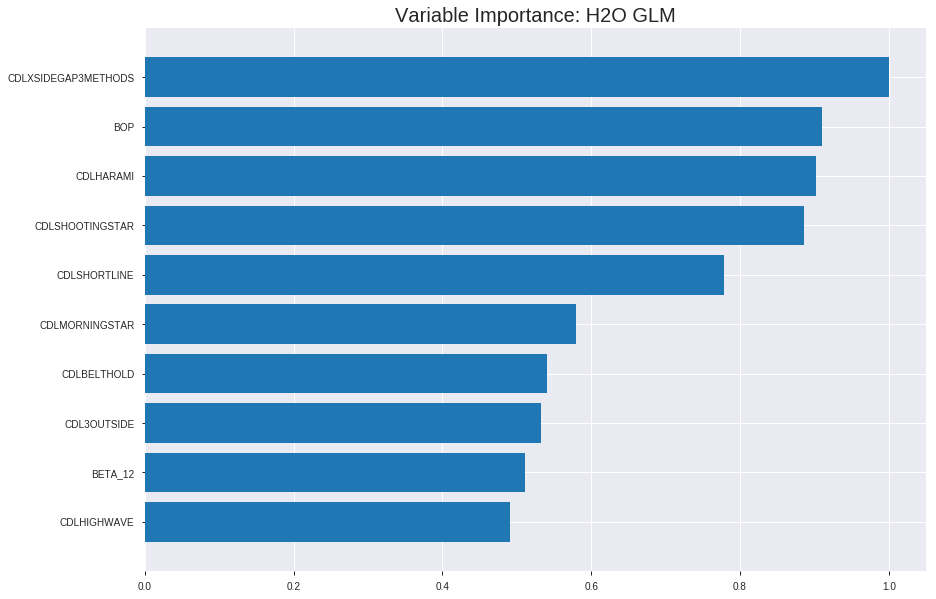

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_125044_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2482246318375439
RMSE: 0.49822146866383016
LogLoss: 0.6895894835121869
Null degrees of freedom: 4318
Residual degrees of freedom: 3298
Null deviance: 5986.238124775795
Residual deviance: 5956.67395857827
AIC: 7998.67395857827
AUC: 0.5585322746011523
pr_auc: 0.5616284279901821
Gini: 0.11706454920230458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4617277384903839: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      20   2104  0.9906   (2104.0/2124.0)
1      4    2191  0.0018   (4.0/2195.0)
Total  24   4295  0.4881   (2108.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.461728     0.675193   385
max f2                       0.454398     0.838044   392
max f0point5                 0.48415      0.571027   319
max accuracy                 0.513613     0.546886   175
max precision                0.583162     1          0
max recall                   0.440234     1          398
max specificity              0.583162     1          0
max absolute_mcc             0.513613     0.0987599  175
max min_per_class_accuracy   0.508681     0.54123    202
max mean_per_class_accuracy  0.513613     0.548473   175

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.555066           1.52046   1.52046            0.772727         0.562727  0.772727                    0.562727            0.0154897       0.0154897                  52.046    52.046
    2        0.0201436                   0.548845           1.05247   1.28915            0.534884         0.551663  0.655172                    0.557259            0.0104784       0.0259681                  5.2466    28.9152
    3        0.0300996                   0.545619           1.14398   1.24114            0.581395         0.547177  0.630769                    0.553924            0.0113895       0.0373576                  14.3985   24.1135
    4        0.0400556                   0.542374           1.14398   1.21699            0.581395         0.543963  0.618497                    0.551448            0.0113895       0.0487472                  14.3985   21.6988
    5        0.0500116                   0.540062           1.14398   1.20246            0.581395         0.541173  0.611111                    0.549403            0.0113895       0.0601367                  14.3985   20.2455
    6        0.100023                    0.53248            1.12047   1.16146            0.569444         0.536107  0.590278                    0.542755            0.0560364       0.116173                   12.047    16.1462
    7        0.150035                    0.528234           1.17513   1.16602            0.597222         0.530319  0.592593                    0.53861             0.0587699       0.174943                   17.5127   16.6017
    8        0.200046                    0.524324           1.10225   1.15008            0.560185         0.526358  0.584491                    0.535547            0.0551253       0.230068                   10.225    15.0075
    9        0.300069                    0.5189             1.08403   1.12806            0.550926         0.521587  0.573302                    0.530893            0.108428        0.338497                   8.40315   12.8061
    10       0.400093                    0.513763           1.09314   1.11933            0.555556         0.516276  0.568866                    0.527239            0.109339        0.447836                   9.3141    11.9331
    11       0.500116                    0.508506           0.942834  1.08403            0.479167         0.511169  0.550926                    0.524025            0.0943052       0.542141                   -5.71659  8.40315
    12       0.599907                    0.503266           0.949587  1.06167            0.482599         0.505975  0.53956                     0.521023            0.0947608       0.636902                   -5.0413   6.16673
    13       0.699931                    0.497765           0.92006   1.04143            0.467593         0.500673  0.529276                    0.518114            0.0920273       0.728929                   -7.99397  4.1431
    14       0.799954                    0.49154            0.942834  1.0291             0.479167         0.494608  0.52301                     0.515175            0.0943052       0.823235                   -5.71659  2.91028
    15       0.899977                    0.482033           0.974717  1.02306            0.49537          0.487249  0.519938                    0.512072            0.0974943       0.920729                   -2.52826  2.30585
    16       1                           0.432598           0.792527  1                  0.402778         0.473559  0.508219                    0.508219           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25010966776280236
RMSE: 0.5001096557384214
LogLoss: 0.6933656504237403
Null degrees of freedom: 1233
Residual degrees of freedom: 213
Null deviance: 1709.574001855587
Residual deviance: 1711.226425245791
AIC: 3753.226425245791
AUC: 0.4988203732197104
pr_auc: 0.5214548906483873
Gini: -0.0023592535605791998
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.458478137080364: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    590   0.9916   (590.0/595.0)
1      2    637   0.0031   (2.0/639.0)
Total  7    1227  0.4797   (592.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.458478     0.682744   392
max f2                       0.444047     0.843008   399
max f0point5                 0.471391     0.575089   357
max accuracy                 0.472101     0.525122   354
max precision                0.562138     1          0
max recall                   0.444047     1          399
max specificity              0.562138     1          0
max absolute_mcc             0.553588     0.0441356  5
max min_per_class_accuracy   0.50374      0.485714   197
max mean_per_class_accuracy  0.513406     0.512943   141

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.550385           1.03985   1.03985            0.538462         0.553677  0.538462                    0.553677            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.542146           1.44836   1.23593            0.75             0.545522  0.64                        0.549763            0.0140845       0.0250391                  44.8357   23.5931
    3        0.0299838                   0.539336           0.965571  1.14825            0.5              0.540899  0.594595                    0.546888            0.00938967      0.0344288                  -3.44288  14.8247
    4        0.0405186                   0.536293           1.03985   1.12006            0.538462         0.538111  0.58                        0.544606            0.0109546       0.0453834                  3.98459   12.0063
    5        0.0502431                   0.534703           0.804643  1.05901            0.416667         0.535255  0.548387                    0.542796            0.00782473      0.0532081                  -19.5357  5.90136
    6        0.100486                    0.52819            0.903276  0.981145           0.467742         0.530674  0.508065                    0.536735            0.0453834       0.0985915                  -9.67237  -1.88551
    7        0.149919                    0.523813           1.10803   1.02298            0.57377          0.525941  0.52973                     0.533176            0.0547731       0.153365                   10.8033   2.29835
    8        0.200162                    0.520448           0.903276  0.992936           0.467742         0.522109  0.51417                     0.530398            0.0453834       0.198748                   -9.67237  -0.706443
    9        0.299838                    0.51425            1.09902   1.0282             0.569106         0.517135  0.532432                    0.525989            0.109546        0.308294                   9.90241   2.82029
    10       0.400324                    0.508698           0.949997  1.00857            0.491935         0.511626  0.522267                    0.522384            0.0954617       0.403756                   -5.00025  0.857235
    11       0.5                         0.503721           0.847819  0.976526           0.439024         0.506266  0.505673                    0.519171            0.084507        0.488263                   -15.2181  -2.34742
    12       0.599676                    0.498795           0.942021  0.970791           0.487805         0.501352  0.502703                    0.516209            0.0938967       0.58216                    -5.79793  -2.92095
    13       0.700162                    0.493626           1.12131   0.992393           0.580645         0.496468  0.513889                    0.513376            0.112676        0.694836                   12.1308   -0.760737
    14       0.799838                    0.486969           1.08332   1.00372            0.560976         0.490144  0.519757                    0.510481            0.107981        0.802817                   8.33238   0.372447
    15       0.899514                    0.478785           1.05192   1.00907            0.544715         0.483143  0.522523                    0.507451            0.104851        0.907668                   5.19231   0.90654
    16       1                           0.444047           0.91885   1                  0.475806         0.469945  0.517828                    0.503682


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 12:50:52  0.000 sec   2            2.9       1021          1.37918           1.38673
    2019-08-22 12:50:57  4.888 sec   4            2.1       1027          1.37766           1.38746
    2019-08-22 12:51:02  9.733 sec   6            1.5       1030          1.37585           1.38835
    2019-08-22 12:51:07  14.957 sec  8            1.1       1034          1.37371           1.38954
    2019-08-22 12:51:12  19.777 sec  10           0.81      1035          1.37129           1.39123

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5501618122977346)

('F1', 0.6263982102908278)

('auc', 0.4997833896872359)

('logloss', 0.6959741824084548)

('mean_per_class_error', 0.47952240067624685)

('rmse', 0.5014082717237665)

('mse', 0.2514102549530144)

glm prediction progress: |████████████████████████████████████████████████| 100%


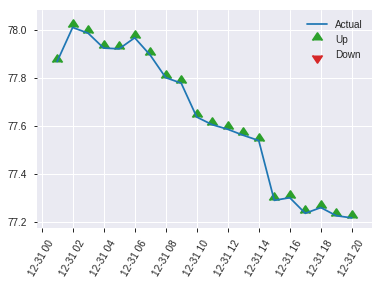


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2514102549530144
RMSE: 0.5014082717237665
LogLoss: 0.6959741824084548
Null degrees of freedom: 617
Residual degrees of freedom: -403
Null deviance: 858.8040410176391
Residual deviance: 860.2240894568502
AIC: 2902.2240894568504
AUC: 0.4997833896872359
pr_auc: 0.4487272123137639
Gini: -0.00043322062552819673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4498667159388986: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    334  0.9882   (334.0/338.0)
1      0    280  0        (0.0/280.0)
Total  4    614  0.5405   (334.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.449867     0.626398   395
max f2                       0.449867     0.807382   395
max f0point5                 0.484937     0.513029   340
max accuracy                 0.550867     0.550162   9
max precision                0.554716     0.666667   2
max recall                   0.449867     1          395
max specificity              0.557156     0.997041   0
max absolute_mcc             0.449867     0.0734626  395
max min_per_class_accuracy   0.510198     0.497041   193
max mean_per_class_accuracy  0.499095     0.520478   263

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 50.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.551337           1.26122   1.26122            0.571429         0.553864  0.571429                    0.553864            0.0142857       0.0142857                  26.1224   26.1224
    2        0.0210356                   0.549892           1.10357   1.18846            0.5              0.550626  0.538462                    0.55237             0.0107143       0.025                      10.3571   18.8462
    3        0.0307443                   0.547868           0.735714  1.04549            0.333333         0.549238  0.473684                    0.551381            0.00714286      0.0321429                  -26.4286  4.54887
    4        0.0404531                   0.54608            1.10357   1.05943            0.5              0.546892  0.48                        0.550303            0.0107143       0.0428571                  10.3571   5.94286
    5        0.0501618                   0.544255           0.367857  0.925576           0.166667         0.545346  0.419355                    0.549344            0.00357143      0.0464286                  -63.2143  -7.4424
    6        0.100324                    0.538278           1.06797   0.996774           0.483871         0.540973  0.451613                    0.545159            0.0535714       0.1                        6.79724   -0.322581
    7        0.150485                    0.533433           0.925576  0.973041           0.419355         0.535797  0.44086                     0.542038            0.0464286       0.146429                   -7.4424   -2.69585
    8        0.200647                    0.527338           0.78318   0.925576           0.354839         0.530121  0.419355                    0.539059            0.0392857       0.185714                   -21.682   -7.4424
    9        0.300971                    0.520252           0.961175  0.937442           0.435484         0.523461  0.424731                    0.533859            0.0964286       0.282143                   -3.88249  -6.25576
    10       0.399676                    0.515434           1.12166   0.982938           0.508197         0.517647  0.445344                    0.529856            0.110714        0.392857                   12.1663   -1.70619
    11       0.5                         0.510182           1.03237   0.992857           0.467742         0.512962  0.449838                    0.526466            0.103571        0.496429                   3.23733   -0.714286
    12       0.600324                    0.504867           1.17477   1.02326            0.532258         0.507527  0.463612                    0.523301            0.117857        0.614286                   17.477    2.32576
    13       0.699029                    0.498954           1.08548   1.03204            0.491803         0.502169  0.467593                    0.520317            0.107143        0.721429                   8.54801   3.20437
    14       0.799353                    0.492219           0.925576  1.01868            0.419355         0.495362  0.461538                    0.517185            0.0928571       0.814286                   -7.4424   1.86813
    15       0.899676                    0.482055           0.961175  1.01227            0.435484         0.487585  0.458633                    0.513884            0.0964286       0.910714                   -3.88249  1.22688
    16       1                           0.444107           0.889977  1                  0.403226         0.46985   0.453074                    0.509467  

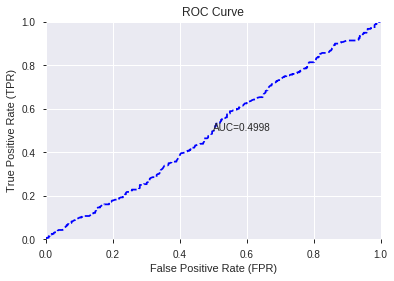

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


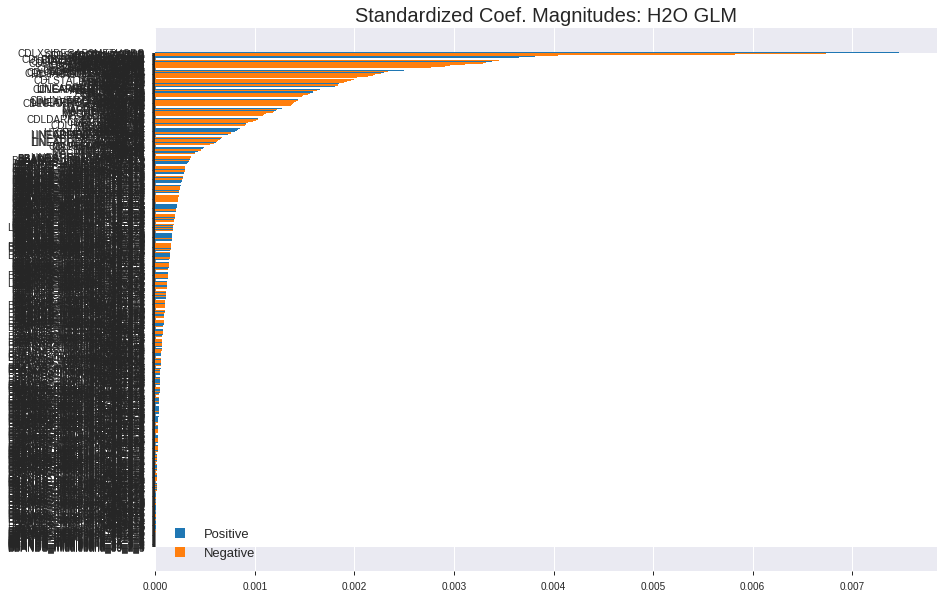

'log_likelihood'
--2019-08-22 12:51:40--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.99.163
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.99.163|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_125044_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_125044_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_34_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_34_s

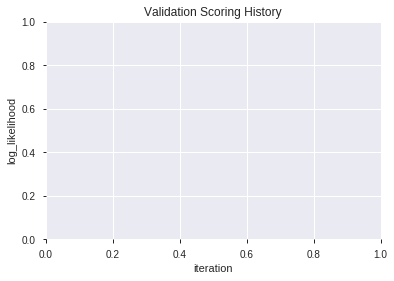

In [14]:
# GLM
glm_features = model_train(feature_name='All',model_algo="GLM")

In [15]:
# DeepLearning with top GLM features
model_train(feature_name='GLMF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

[]

In [16]:
# GLM with top GLM features
model_train(feature_name='GLMF',model_algo="GLM",features_list = features_list[:model_selected_features])

[]

In [17]:
# XGBoost with top GLM features
model_train(feature_name='GLMF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_125238_model_3  0.499583  0.726972              0.497041  0.515591  0.265834
1  XGBoost_grid_1_AutoML_20190822_125238_model_4  0.497158  0.712326              0.500000  0.509194  0.259279
2  XGBoost_grid_1_AutoML_20190822_125238_model_7  0.486655  0.742511              0.498521  0.522182  0.272674
3               XGBoost_2_AutoML_20190822_125238  0.486369  0.727284              0.492604  0.515771  0.266019
4  XGBoost_grid_1_AutoML_20190822_125238_model_5  0.485672  0.763836              0.495869  0.530196  0.281108
5  XGBoost_grid_1_AutoML_20190822_125238_model_1  0.485297  0.735663              0.482608  0.519276  0.269647
6               XGBoost_1_AutoML_20190822_125238  0.482544  0.741056              0.500000  0.521501  0.271963
7  XGBoost_grid_1_AutoML_20190822_125238_model_2  0.468190  0.719271              0.497041  0.512483  0.262638
8  XGBoost_grid_1_AutoML_20190822_125238_model_6  0.466394  0.722647              0.497041  0.513955  0.264149
9               XGBoost_3_AutoML_20190822_125238  0.465976  0.731142              0.500000  0.517716  0.268029

variable  relative_importance  scaled_importance  percentage
0                        BOP           160.774582           1.000000    0.022284
1                         AD           148.550629           0.923968    0.020589
2       HT_PHASOR_quadrature           118.537323           0.737289    0.016429
3                    BETA_12           118.457870           0.736795    0.016418
4                     MFI_20           108.637123           0.675711    0.015057
..                       ...                  ...                ...         ...
295   BBANDS_lowerband_8_7_4             2.360713           0.014683    0.000327
296   BBANDS_lowerband_8_2_5             2.134306           0.013275    0.000296
297            days_in_month             1.681822           0.010461    0.000233
298                 MAVP_8_5             0.630056           0.003919    0.000087
299  BBANDS_lowerband_14_0_3             0.387436           0.002410    0.000054

[300 rows x 4 columns]

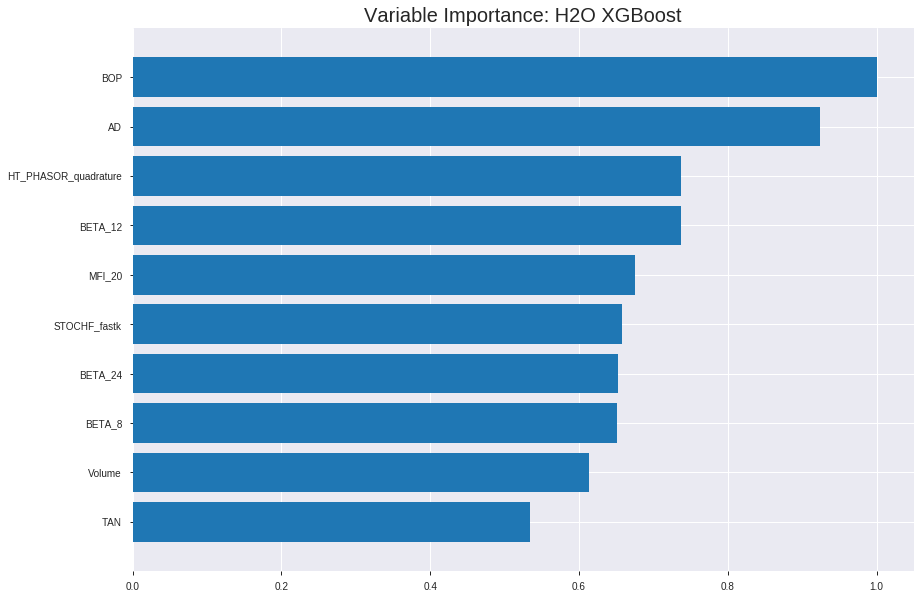

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_125238_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21313360620958216
RMSE: 0.4616639537689532
LogLoss: 0.6184332260944212
Mean Per-Class Error: 0.2073459197199593
AUC: 0.8787185393957334
pr_auc: 0.8806307591592182
Gini: 0.7574370787914668
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48970697075128555: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1425  699   0.3291   (699.0/2124.0)
1      241   1954  0.1098   (241.0/2195.0)
Total  1666  2653  0.2176   (940.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.489707     0.806106  229
max f2                       0.451388     0.877315  283
max f0point5                 0.526683     0.819513  169
max accuracy                 0.502141     0.793239  209
max precision                0.807157     1         0
max recall                   0.381167     1         360
max specificity              0.807157     1         0
max absolute_mcc             0.502141     0.587149  209
max min_per_class_accuracy   0.507398     0.789548  200
max mean_per_class_accuracy  0.502141     0.792654  209

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.662696           1.96765   1.96765            1                0.690748  1                           0.690748            0.0200456       0.0200456                  96.7654   96.7654
    2        0.0201436                   0.643597           1.92189   1.94504            0.976744         0.653095  0.988506                    0.672138            0.0191344       0.03918                    92.1894   94.5037
    3        0.0300996                   0.631487           1.96765   1.95252            1                0.636843  0.992308                    0.660463            0.01959         0.0587699                  96.7654   95.2518
    4        0.0400556                   0.622526           1.87613   1.93353            0.953488         0.62651   0.982659                    0.652024            0.0186788       0.0774487                  87.6135   93.3533
    5        0.0500116                   0.615907           1.78462   1.90389            0.906977         0.619552  0.967593                    0.64556             0.0177677       0.0952164                  78.4616   90.3887
    6        0.100023                    0.592279           1.88567   1.89478            0.958333         0.603308  0.962963                    0.624434            0.0943052       0.189522                   88.5668   89.4778
    7        0.150035                    0.574585           1.913     1.90085            0.972222         0.582994  0.966049                    0.61062             0.095672        0.285194                   91.2997   90.0851
    8        0.200046                    0.55996            1.78546   1.872              0.907407         0.566748  0.951389                    0.599652            0.0892938       0.374487                   78.5464   87.2004
    9        0.300069                    0.538993           1.61238   1.78546            0.819444         0.549426  0.907407                    0.58291             0.161276        0.535763                   61.2383   78.5464
    10       0.400093                    0.523271           1.40286   1.68981            0.712963         0.530699  0.858796                    0.569857            0.140319        0.676082                   40.2864   68.9814
    11       0.500116                    0.508027           1.0977    1.57139            0.55787          0.515569  0.798611                    0.559               0.109795        0.785877                   9.76957   57.139
    12       0.599907                    0.492004           0.903934  1.46036            0.459397         0.500351  0.742184                    0.549244            0.090205        0.876082                   -9.60663  46.0362
    13       0.699931                    0.473746           0.587563  1.33564            0.298611         0.482977  0.678796                    0.539774            0.0587699       0.934852                   -41.2437  33.5635
    14       0.799954                    0.452328           0.419037  1.22103            0.212963         0.463696  0.62055                     0.530262            0.0419134       0.976765                   -58.0963  22.1027
    15       0.899977                    0.425296           0.177635  1.10507            0.0902778        0.440109  0.561616                    0.520242            0.0177677       0.994533                   -82.2365  10.5065
    16       1                           0.269347           0.054657  1                  0.0277778        0.390518  0.508219                    0.507267          



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25577055032768164
RMSE: 0.5057376299304627
LogLoss: 0.7048422606081355
Mean Per-Class Error: 0.49281440275640775
AUC: 0.48168356544495733
pr_auc: 0.5040443106294542
Gini: -0.03663286911008534
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3468325436115265: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    586   0.9849   (586.0/595.0)
1      1    638   0.0016   (1.0/639.0)
Total  10   1224  0.4757   (587.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.346833     0.684917   391
max f2                       0.346833     0.843915   391
max f0point5                 0.346833     0.576332   391
max accuracy                 0.364154     0.524311   379
max precision                0.670328     1          0
max recall                   0.334036     1          395
max specificity              0.670328     1          0
max absolute_mcc             0.346833     0.0755811  391
max min_per_class_accuracy   0.476288     0.491393   197
max mean_per_class_accuracy  0.364154     0.507186   379

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 47.58 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.59907            0.891296  0.891296           0.461538         0.624146  0.461538                    0.624146            0.00938967      0.00938967                 -10.8704  -10.8704
    2        0.0202593                   0.583414           0.965571  0.926948           0.5              0.590231  0.48                        0.607867            0.00938967      0.0187793                  -3.44288  -7.30516
    3        0.0299838                   0.576665           0.965571  0.939475           0.5              0.579936  0.486486                    0.598808            0.00938967      0.028169                   -3.44288  -6.05253
    4        0.0405186                   0.568185           1.63404   1.12006            0.846154         0.57189   0.58                        0.59181             0.0172144       0.0453834                  63.4044   12.0063
    5        0.0502431                   0.563774           0.482786  0.996719           0.25             0.565702  0.516129                    0.586757            0.00469484      0.0500782                  -51.7214  -0.328134
    6        0.100486                    0.545833           0.840981  0.91885            0.435484         0.554047  0.475806                    0.570402            0.0422535       0.0923318                  -15.9019  -8.115
    7        0.149919                    0.531764           1.01306   0.949913           0.52459          0.538232  0.491892                    0.559794            0.0500782       0.14241                    1.30583   -5.00867
    8        0.200162                    0.521256           0.965571  0.953844           0.5              0.526741  0.493927                    0.551498            0.0485133       0.190923                   -3.44288  -4.61564
    9        0.299838                    0.502297           0.942021  0.949913           0.487805         0.512158  0.491892                    0.53842             0.0938967       0.28482                    -5.79793  -5.00867
    10       0.400324                    0.488277           1.07459   0.981208           0.556452         0.495187  0.508097                    0.527568            0.107981        0.392801                   7.45873   -1.8792
    11       0.5                         0.475796           1.00482   0.985915           0.520325         0.482206  0.510535                    0.518525            0.100156        0.492958                   0.482207  -1.40845
    12       0.599676                    0.462991           0.942021  0.978619           0.487805         0.469572  0.506757                    0.510388            0.0938967       0.586854                   -5.79793  -2.13805
    13       0.700162                    0.447491           1.02787   0.985687           0.532258         0.455108  0.510417                    0.502454            0.103286        0.690141                   2.78661   -1.43127
    14       0.799838                    0.430488           1.05192   0.993942           0.544715         0.438814  0.514691                    0.494523            0.104851        0.794992                   5.19231   -0.605842
    15       0.899514                    0.408843           0.942021  0.988188           0.487805         0.420564  0.511712                    0.486328            0.0938967       0.888889                   -5.79793  -1.18118
    16       1                           0.295034           1.10573   1                  0.572581         0.381501  0.517828                    0.47


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:53:27  11.995 sec  0                  0.5              0.693147            0.5             0                  1                0.491781                         0.5                0.693147              0.5               0                    1                  0.482172
    2019-08-22 12:53:29  13.545 sec  5                  0.495645         0.684466            0.67261         0.673342           1.78878          0.416069                         0.499534           0.692214              0.535731          0.554626             1.1884             0.481361
    2019-08-22 12:53:30  14.241 sec  10                 0.491165         0.675591            0.730903        0.736494           1.8335           0.370688                         0.500155           0.693453              0.506794          0.529942             1.1884             0.47812
    2019-08-22 12:53:30  14.961 sec  15                 0.486328         0.666071            0.771881        0.77146            1.74406          0.341746                         0.500444           0.694029              0.501452          0.528395             1.48549            0.475689
    2019-08-22 12:53:31  15.689 sec  20                 0.482108         0.657818            0.799319        0.799359           1.87821          0.291966                         0.501077           0.695305              0.495623          0.51617              0.891296           0.476499
    2019-08-22 12:53:32  16.411 sec  25                 0.478379         0.650557            0.817513        0.818149           1.92293          0.263718                         0.501992           0.697157              0.495614          0.515665             1.03985            0.475689
    2019-08-22 12:53:32  17.177 sec  30                 0.474873         0.643761            0.832244        0.832954           1.92293          0.264182                         0.501959           0.697087              0.493868          0.514324             0.891296           0.475689
    2019-08-22 12:53:33  18.009 sec  35                 0.471178         0.636623            0.846636        0.848318           1.96765          0.236397                         0.503741           0.700733              0.486878          0.511819             1.1884             0.479741
    2019-08-22 12:53:34  18.728 sec  40                 0.468393         0.631268            0.854745        0.856639           1.96765          0.230609                         0.504159           0.701595              0.487708          0.510069             1.03985            0.479741
    2019-08-22 12:53:35  19.447 sec  45                 0.464884         0.624558            0.867656        0.869202           1.96765          0.223431                         0.505181           0.703705              0.486777          0.504369             0.891296           0.47812
    2019-08-22 12:53:35  20.194 sec  50                 0.461664         0.618433            0.878719        0.880631           1.96765          0.217643                         0.505738           0.704842              0.481684          0.504044             0.891296           0.475689

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      160.7745819091797      1.0                   0.022283526138816706
AD                       148.55062866210938     0.9239683717294596    0.020589273362873323
HT_PHASOR_quadrature     118.53732299804688     0.7372889519626161    0.016429397632919732
BETA_12                  118.45787048339844     0.7367947661671692    0.01641838543082946
MFI_20                   108.63712310791016     0.675710810862369     0.01505721951613263
---                      ---                    ---                   ---
BBANDS_lowerband_8_7_4   2.360713005065918      0.01468337206685735   0.00032719730525778687
BBANDS_lowerband_8_2_5   2.134305953979492      0.013275145415617657  0.00029581704986550883
days_in_month            1.6818222999572754     0.01046074746384552   0.00023310233954216224
MAVP_8_5                 0.6300563812255859     0.003918880545318413  8.732647706650312e-05
BBANDS_lowerband_14_0_3  0.3874359130859375     0.002409808245091858  5.369902501904044e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5501618122977346)

('F1', 0.625)

('auc', 0.499582628909552)

('logloss', 0.7269718889407045)

('mean_per_class_error', 0.48051563820794585)

('rmse', 0.5155909357443309)

('mse', 0.2658340130217148)

xgboost prediction progress: |████████████████████████████████████████████| 100%


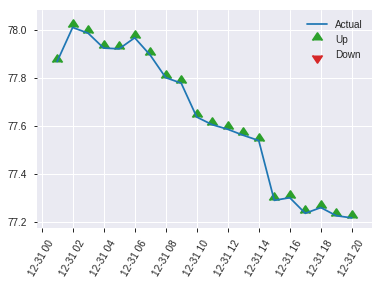


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2658340130217148
RMSE: 0.5155909357443309
LogLoss: 0.7269718889407045
Mean Per-Class Error: 0.48051563820794585
AUC: 0.499582628909552
pr_auc: 0.4446543237260995
Gini: -0.0008347421808959643
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31809866428375244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    336  0.9941   (336.0/338.0)
1      0    280  0        (0.0/280.0)
Total  2    616  0.5437   (336.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.318099     0.625      397
max f2                       0.318099     0.806452   397
max f0point5                 0.452202     0.511905   350
max accuracy                 0.770217     0.550162   3
max precision                0.780942     1          0
max recall                   0.318099     1          397
max specificity              0.780942     1          0
max absolute_mcc             0.730046     0.0609938  15
max min_per_class_accuracy   0.542125     0.511834   208
max mean_per_class_accuracy  0.547249     0.519484   196

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 55.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.756165           0.945918  0.945918           0.428571         0.768575  0.428571                    0.768575            0.0107143       0.0107143                  -5.40816   -5.40816
    2        0.0210356                   0.734577           0.367857  0.679121           0.166667         0.745774  0.307692                    0.758052            0.00357143      0.0142857                  -63.2143   -32.0879
    3        0.0307443                   0.728381           0.735714  0.696992           0.333333         0.731549  0.315789                    0.749683            0.00714286      0.0214286                  -26.4286   -30.3008
    4        0.0404531                   0.712051           1.47143   0.882857           0.666667         0.716984  0.4                         0.741835            0.0142857       0.0357143                  47.1429    -11.7143
    5        0.0501618                   0.707588           1.47143   0.996774           0.666667         0.710344  0.451613                    0.73574             0.0142857       0.05                       47.1429    -0.322581
    6        0.100324                    0.680067           1.06797   1.03237            0.483871         0.692699  0.467742                    0.71422             0.0535714       0.103571                   6.79724    3.23733
    7        0.150485                    0.658112           0.640783  0.901843           0.290323         0.6684    0.408602                    0.698947            0.0321429       0.135714                   -35.9217   -9.81567
    8        0.200647                    0.631444           0.925576  0.907776           0.419355         0.643817  0.41129                     0.685164            0.0464286       0.182143                   -7.4424    -9.22235
    9        0.300971                    0.589081           0.996774  0.937442           0.451613         0.607846  0.424731                    0.659391            0.1             0.282143                   -0.322581  -6.25576
    10       0.399676                    0.563776           1.08548   0.974002           0.491803         0.575575  0.441296                    0.638692            0.107143        0.389286                   8.54801    -2.59977
    11       0.5                         0.541999           1.24597   1.02857            0.564516         0.551418  0.466019                    0.621181            0.125           0.514286                   24.5968    2.85714
    12       0.600324                    0.518399           0.996774  1.02326            0.451613         0.530536  0.463612                    0.606032            0.1             0.614286                   -0.322581  2.32576
    13       0.699029                    0.502488           0.904567  1.0065             0.409836         0.510492  0.456019                    0.592542            0.0892857       0.703571                   -9.54333   0.649802
    14       0.799353                    0.484448           0.996774  1.00528            0.451613         0.494158  0.455466                    0.580194            0.1             0.803571                   -0.322581  0.527762
    15       0.899676                    0.454264           1.06797   1.01227            0.483871         0.46881   0.458633                    0.567773            0.107143        0.910714                   6.79724    1.22688
    16       1                           0.314181           0.889977  1                  0.403226         0.42111   0.453074        

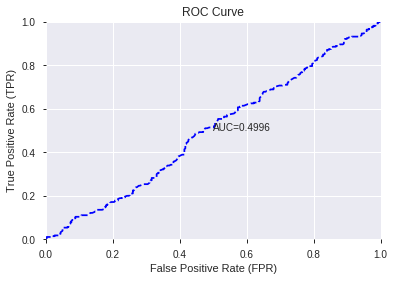

This function is available for GLM models only


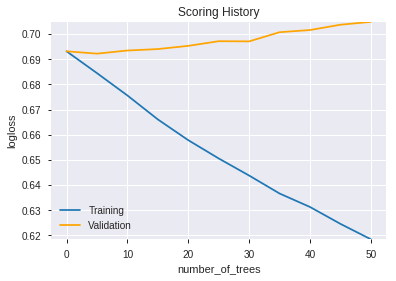

--2019-08-22 12:54:26--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.163.83
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.163.83|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_125238_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_125238_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_42_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

In [18]:
# XGBoost
xgb_features = model_train(feature_name='All',model_algo="XGBoost")

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_125523_model_4  0.522675  0.728425              0.498521  0.512360  0.262513
1  DeepLearning_grid_1_AutoML_20190822_125523_model_6  0.519463  0.689789              0.500000  0.498188  0.248191
2               DeepLearning_1_AutoML_20190822_125523  0.514788  0.753243              0.498521  0.526042  0.276720
3  DeepLearning_grid_1_AutoML_20190822_125523_model_5  0.513768  0.697373              0.500000  0.502071  0.252075
4  DeepLearning_grid_1_AutoML_20190822_125523_model_1  0.509267  0.808749              0.498521  0.540253  0.291874
5  DeepLearning_grid_1_AutoML_20190822_125523_model_7  0.502319  0.699077              0.497041  0.501492  0.251494
6  DeepLearning_grid_1_AutoML_20190822_125523_model_8  0.500000  0.700342              0.500000  0.503580  0.253593
7  DeepLearning_grid_1_AutoML_20190822_125523_model_9  0.500000  0.699871              0.500000  0.503347  0.253358
8  DeepLearning_grid_1_AutoML_20190822_125523_model_2  0.497533  0.747453              0.490871  0.521894  0.272373
9  DeepLearning_grid_1_AutoML_20190822_125523_model_3  0.481942  0.721484              0.498521  0.512444  0.262599

variable  relative_importance  scaled_importance  percentage
0      CDLSTICKSANDWICH             1.000000           1.000000    0.030775
1    CDLEVENINGDOJISTAR             0.994761           0.994761    0.030614
2       CDLLADDERBOTTOM             0.955354           0.955354    0.029401
3     CDL3WHITESOLDIERS             0.948212           0.948212    0.029181
4   CDLGAPSIDESIDEWHITE             0.945994           0.945994    0.029113
5    CDLIDENTICAL3CROWS             0.939706           0.939706    0.028920
6             CDLINNECK             0.938044           0.938044    0.028869
7           CDLPIERCING             0.925345           0.925345    0.028478
8     CDLDARKCLOUDCOVER             0.923161           0.923161    0.028410
9    CDLMORNINGDOJISTAR             0.915884           0.915884    0.028187
10     is_quarter_start             0.909496           0.909496    0.027990
11         CDLTHRUSTING             0.887776           0.887776    0.027321
12            CDLONNECK             0.887191           0.887191    0.027304
13      CDLHOMINGPIGEON             0.874329           0.874329    0.026908
14      CDLUNIQUE3RIVER             0.872146           0.872146    0.026840
15         CDLTASUKIGAP             0.860687           0.860687    0.026488
16       CDLMORNINGSTAR             0.813246           0.813246    0.025028
17       CDLEVENINGSTAR             0.778687           0.778687    0.023964
18       CDL3LINESTRIKE             0.769844           0.769844    0.023692
19    CDLSTALLEDPATTERN             0.759458           0.759458    0.023373
20           CDL3INSIDE             0.724536           0.724536    0.022298
21      CDLSHOOTINGSTAR             0.688583           0.688583    0.021191
22   CDLSEPARATINGLINES             0.682911           0.682911    0.021017
23    CDLINVERTEDHAMMER             0.657298           0.657298    0.020229
24          CDLDOJISTAR             0.604465           0.604465    0.018603
25       CDLHARAMICROSS             0.579412           0.579412    0.017832
26       CDLMATCHINGLOW             0.578722           0.578722    0.017810
27    CDLGRAVESTONEDOJI             0.571097           0.571097    0.017576
28        CDLHANGINGMAN             0.561879           0.561879    0.017292
29            CDLTAKURI             0.544063           0.544063    0.016744
30     CDLDRAGONFLYDOJI             0.528229           0.528229    0.016256
31       is_month_start             0.512949           0.512949    0.015786
32      CDLADVANCEBLOCK             0.494085           0.494085    0.015206
33            CDLHAMMER             0.485048           0.485048    0.014927
34         is_month_end             0.479134           0.479134    0.014745
35        days_in_month             0.460326           0.460326    0.014167
36               VAR_14             0.455981           0.455981    0.014033
37                 SINH             0.449037           0.449037    0.013819
38                  EXP             0.437395           0.437395    0.013461
39            CORREL_30             0.429660           0.429660    0.013223
40                 COSH             0.427413           0.427413    0.013154
41                  SIN             0.402725           0.402725    0.012394
42               VAR_20             0.394569           0.394569    0.012143
43             CORREL_8             0.386112           0.386112    0.011883
44               VAR_30             0.372964           0.372964    0.011478
45            CORREL_14             0.357017           0.357017    0.010987
46       CDLRICKSHAWMAN             0.343536           0.343536    0.010572
47            CORREL_24             0.330552           0.330552    0.010173
48              CDLDOJI             0.329778           0.329778    0.010149
49    CDLLONGLEGGEDDOJI             0.324868           0.324868    0.009998

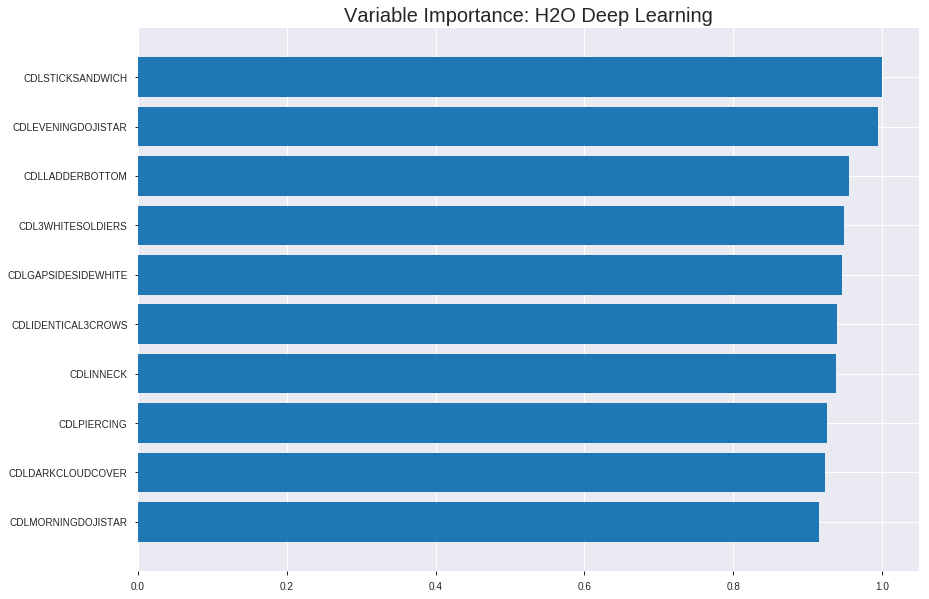

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_125523_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.24290756779019887
RMSE: 0.49285653875159136
LogLoss: 0.6787164025776989
Mean Per-Class Error: 0.4406586618277286
AUC: 0.5885967508761996
pr_auc: 0.5943031463765567
Gini: 0.17719350175239912
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3163716055930887: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      126  1998  0.9407   (1998.0/2124.0)
1      41   2154  0.0187   (41.0/2195.0)
Total  167  4152  0.4721   (2039.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.316372     0.678746  334
max f2                       0.17321      0.838764  372
max f0point5                 0.485785     0.581215  245
max accuracy                 0.521815     0.55962   203
max precision                0.990906     1         0
max recall                   0.0433995    1         394
max specificity              0.990906     1         0
max absolute_mcc             0.579297     0.126172  142
max min_per_class_accuracy   0.523176     0.555556  201
max mean_per_class_accuracy  0.521815     0.559341  203

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 52.76 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.812308           1.69934   1.69934            0.863636         0.895305  0.863636                    0.895305            0.0173121       0.0173121                  69.9337   69.9337
    2        0.0201436                   0.766857           1.51006   1.60579            0.767442         0.790548  0.816092                    0.843528            0.0150342       0.0323462                  51.006    60.5786
    3        0.0300996                   0.733368           1.00671   1.40763            0.511628         0.747627  0.715385                    0.811807            0.0100228       0.042369                   0.670657  40.7629
    4        0.0400556                   0.710911           1.41854   1.41034            0.72093          0.721177  0.716763                    0.78928             0.014123        0.056492                   41.8541   41.0341
    5        0.0500116                   0.691217           1.05247   1.3391             0.534884         0.70196   0.680556                    0.771897            0.0104784       0.0669704                  5.2466    33.9098
    6        0.100023                    0.633906           1.30266   1.32088            0.662037         0.659299  0.671296                    0.715598            0.0651481       0.132118                   30.266    32.0879
    7        0.150035                    0.606227           1.16602   1.26926            0.592593         0.618688  0.645062                    0.683295            0.0583144       0.190433                   16.6017   26.9258
    8        0.200046                    0.584945           1.17513   1.24573            0.597222         0.594815  0.633102                    0.661175            0.0587699       0.249203                   17.5127   24.5725
    9        0.300069                    0.552556           1.02937   1.17361            0.523148         0.566788  0.596451                    0.629712            0.102961        0.352164                   2.93744   17.3608
    10       0.400093                    0.532813           1.02026   1.13527            0.518519         0.541985  0.576968                    0.607781            0.10205         0.454214                   2.02649   13.5272
    11       0.500116                    0.523119           1.02937   1.11409            0.523148         0.527249  0.566204                    0.591674            0.102961        0.557175                   2.93744   11.4093
    12       0.599907                    0.516686           0.967848  1.08977            0.491879         0.519671  0.55384                     0.579697            0.0965831       0.653759                   -3.21517  8.97658
    13       0.699931                    0.506782           0.979272  1.07398            0.497685         0.512703  0.545815                    0.570123            0.0979499       0.751708                   -2.07279  7.39758
    14       0.802269                    0.485792           0.96602   1.0602             0.49095          0.493852  0.538817                    0.560394            0.098861        0.850569                   -3.39799  6.02048
    15       0.899977                    0.443409           0.848609  1.03723            0.43128          0.468854  0.527142                    0.550456            0.0829157       0.933485                   -15.1391  3.72325
    16       1                           0.0213614          0.664994  1                  0.337963         0.321813  0.508219                    0.527586         



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.26227468530536713
RMSE: 0.5121276064667547
LogLoss: 0.7249409670947062
Mean Per-Class Error: 0.494088715298326
AUC: 0.48411909364684835
pr_auc: 0.49654214172024136
Gini: -0.031761812706303294
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0928039595125348: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      4    591   0.9933   (591.0/595.0)
1      1    638   0.0016   (1.0/639.0)
Total  5    1229  0.4797   (592.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.092804     0.683084   394
max f2                       0.0348077    0.843008   399
max f0point5                 0.092804     0.574257   394
max accuracy                 0.092804     0.520259   394
max precision                0.537923     0.52381    223
max recall                   0.0348077    1          399
max specificity              0.951472     0.998319   0
max absolute_mcc             0.819641     0.0803874  12
max min_per_class_accuracy   0.537508     0.50084    224
max mean_per_class_accuracy  0.537923     0.505911   223

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 54.40 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.821578           0.297099  0.297099           0.153846         0.880811  0.153846                    0.880811            0.00312989      0.00312989                 -70.2901  -70.2901
    2        0.0202593                   0.737855           0.804643  0.54072            0.416667         0.779289  0.28                        0.83208             0.00782473      0.0109546                  -19.5357  -45.928
    3        0.0299838                   0.716277           0.965571  0.678509           0.5              0.725737  0.351351                    0.797591            0.00938967      0.0203443                  -3.44288  -32.1491
    4        0.0405186                   0.688399           1.1884    0.81108            0.615385         0.705061  0.42                        0.773533            0.0125196       0.0328638                  18.8395   -18.892
    5        0.0502431                   0.678906           1.1265    0.872129           0.583333         0.684448  0.451613                    0.756291            0.0109546       0.0438185                  12.65     -12.7871
    6        0.100486                    0.629366           0.965571  0.91885            0.5              0.649952  0.475806                    0.703122            0.0485133       0.0923318                  -3.44288  -8.115
    7        0.149919                    0.603957           0.82311   0.887282           0.42623          0.615649  0.459459                    0.674279            0.0406886       0.13302                    -17.689   -11.2718
    8        0.200162                    0.586454           0.965571  0.906933           0.5              0.595641  0.469636                    0.65454             0.0485133       0.181534                   -3.44288  -9.30667
    9        0.299838                    0.564758           1.05192   0.955133           0.544715         0.574053  0.494595                    0.627783            0.104851        0.286385                   5.19231   -4.48674
    10       0.400324                    0.547245           1.10573   0.992936           0.572581         0.555346  0.51417                     0.609601            0.111111        0.397496                   10.5735   -0.706443
    11       0.5                         0.537357           1.05192   1.00469            0.544715         0.541752  0.520259                    0.596075            0.104851        0.502347                   5.19231   0.469484
    12       0.599676                    0.529784           0.957721  0.996887           0.495935         0.534111  0.516216                    0.585776            0.0954617       0.597809                   -4.2279   -0.311297
    13       0.700162                    0.520695           0.965571  0.992393           0.5              0.52512   0.513889                    0.57707             0.0970266       0.694836                   -3.44288  -0.760737
    14       0.799838                    0.513304           0.942021  0.986115           0.487805         0.517199  0.510638                    0.569609            0.0938967       0.788732                   -5.79793  -1.38847
    15       0.908428                    0.485792           1.05204   0.993996           0.544776         0.501457  0.514719                    0.561463            0.114241        0.902973                   5.20403   -0.600431
    16       1                           0.0348077          1.05956   1                  0.548673         0.370675  0.517828                    0.


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 12:58:37  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 12:58:44  8.907 sec         334 obs/sec       0.551285  1             2381       0.669612         2.45236             -0.794005      0.511143        0.4722             1.1627           0.489465                         0.663695           2.44868               -0.764205        0.516099          0.500447             0.594198           0.482172
    2019-08-22 12:59:04  28.572 sec        464 obs/sec       2.69437   5             11637      0.604999         1.1314              -0.46449       0.531456        0.53927            1.20742          0.491781                         0.619967           1.19049               -0.539393        0.474149          0.501649             1.03985            0.482172
    2019-08-22 12:59:23  47.562 sec        610 obs/sec       5.97754   11            25817      0.540188         0.864616            -0.167526      0.527332        0.542555           1.47574          0.491781                         0.536454           0.893139              -0.152596        0.509436          0.526451             1.1884             0.482172
    2019-08-22 12:59:40  1 min  5.192 sec  764 obs/sec       10.294    19            44460      0.50268          0.706536            -0.0110204     0.556125        0.563662           1.43102          0.480204                         0.515777           0.749778              -0.0654569       0.509753          0.523562             0.891296           0.481361
    2019-08-22 12:59:59  1 min 23.361 sec  911 obs/sec       15.7423   29            67991      0.49985          0.696505            0.000327958    0.56594         0.571859           1.3863           0.477425                         0.516235           0.738897              -0.0673501       0.503737          0.532308             1.03985            0.482172
    2019-08-22 13:00:17  1 min 41.249 sec  1034 obs/sec      21.749    40            93934      0.498636         0.691899            0.0051778      0.573777        0.584059           1.56518          0.48113                          0.518234           0.74772               -0.0756352       0.47284           0.498685             0.891296           0.481361
    2019-08-22 13:00:35  1 min 59.514 sec  1136 obs/sec      28.247    52            121999     0.492857         0.678716            0.0281071      0.588597        0.594303           1.69934          0.4721                           0.512128           0.724941              -0.0504342       0.484119          0.496542             0.297099           0.479741
    2019-08-22 13:00:52  2 min 16.587 sec  1205 obs/sec      34.2343   63            147858     0.493559         0.683793            0.0253349      0.606574        0.609394           1.6099           0.463533                         0.524453           0.777785              -0.101605        0.466672          0.494848             0.891296           0.479741
    2019-08-22 13:01:11

Variable Importances: 


variable             relative_importance    scaled_importance    percentage
-------------------  ---------------------  -------------------  --------------------
CDLSTICKSANDWICH     1.0                    1.0                  0.030775225441422364
CDLEVENINGDOJISTAR   0.994761049747467      0.994761049747467    0.030613995566324267
CDLLADDERBOTTOM      0.9553536176681519     0.9553536176681519   0.0294012229600158
CDL3WHITESOLDIERS    0.9482123851776123     0.9482123851776123   0.029181449920189836
CDLGAPSIDESIDEWHITE  0.9459935426712036     0.9459935426712036   0.029113164541836097
---                  ---                    ---                  ---
CORREL_14            0.35701659321784973    0.35701659321784973  0.010987266142607907
CDLRICKSHAWMAN       0.3435358703136444     0.3435358703136444   0.010572393856117643
CORREL_24            0.3305523097515106     0.3305523097515106   0.010172821852785615
CDLDOJI              0.32977771759033203    0.32977771759033203  0.010148983604400186
CDLLONGLEGGEDDOJI    0.3248680531978607     0.3248680531978607   0.009997887575880157


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5566343042071198)

('F1', 0.6243032329988851)

('auc', 0.5226754015215553)

('logloss', 0.7284248696177285)

('mean_per_class_error', 0.468121301775148)

('rmse', 0.5123604279191191)

('mse', 0.26251320809746276)

deeplearning prediction progress: |███████████████████████████████████████| 100%


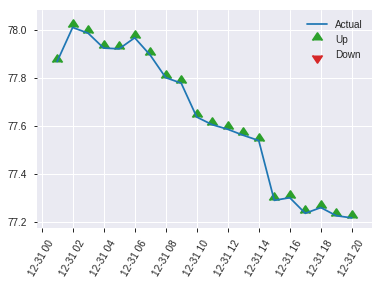


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.26251320809746276
RMSE: 0.5123604279191191
LogLoss: 0.7284248696177285
Mean Per-Class Error: 0.468121301775148
AUC: 0.5226754015215553
pr_auc: 0.4758521187038023
Gini: 0.04535080304311068
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04547101137576473: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    337  0.997    (337.0/338.0)
1      0    280  0        (0.0/280.0)
Total  1    617  0.5453   (337.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.045471     0.624303   398
max f2                       0.045471     0.805987   398
max f0point5                 0.506943     0.515654   297
max accuracy                 0.721419     0.556634   25
max precision                0.848284     0.666667   8
max recall                   0.045471     1          398
max specificity              0.988285     0.997041   0
max absolute_mcc             0.506943     0.0743738  297
max min_per_class_accuracy   0.52974      0.523669   226
max mean_per_class_accuracy  0.535852     0.531879   205

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 54.44 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.860842           1.26122   1.26122            0.571429         0.909272  0.571429                    0.909272            0.0142857       0.0142857                  26.1224    26.1224
    2        0.0210356                   0.794031           1.47143   1.35824            0.666667         0.825203  0.615385                    0.870471            0.0142857       0.0285714                  47.1429    35.8242
    3        0.0307443                   0.751279           1.10357   1.27782            0.5              0.766695  0.578947                    0.837699            0.0107143       0.0392857                  10.3571    27.782
    4        0.0404531                   0.723983           1.47143   1.32429            0.666667         0.742149  0.6                         0.814767            0.0142857       0.0535714                  47.1429    32.4286
    5        0.0501618                   0.706156           0.735714  1.21037            0.333333         0.715061  0.548387                    0.795469            0.00714286      0.0607143                  -26.4286   21.0369
    6        0.100324                    0.646415           0.78318   0.996774           0.354839         0.670296  0.451613                    0.732883            0.0392857       0.1                        -21.682    -0.322581
    7        0.150485                    0.61422            0.996774  0.996774           0.451613         0.629019  0.451613                    0.698261            0.05            0.15                       -0.322581  -0.322581
    8        0.200647                    0.593118           1.49516   1.12137            0.677419         0.604822  0.508065                    0.674902            0.075           0.225                      49.5161    12.1371
    9        0.300971                    0.561395           0.925576  1.05611            0.419355         0.57579   0.478495                    0.641865            0.0928571       0.317857                   -7.4424    5.6106
    10       0.399676                    0.542552           1.08548   1.06336            0.491803         0.551421  0.481781                    0.619528            0.107143        0.425                      8.54801    6.33603
    11       0.5                         0.529417           0.996774  1.05               0.451613         0.535211  0.475728                    0.60261             0.1             0.525                      -0.322581  5
    12       0.600324                    0.52019            0.818779  1.01136            0.370968         0.524375  0.458221                    0.589536            0.0821429       0.607143                   -18.1221   1.13593
    13       0.699029                    0.513477           0.976932  1.0065             0.442623         0.516606  0.456019                    0.579238            0.0964286       0.703571                   -2.30679   0.649802
    14       0.799353                    0.497503           1.13917   1.02315            0.516129         0.508324  0.463563                    0.570338            0.114286        0.817857                   13.9171    2.31492
    15       0.899676                    0.476785           0.78318   0.99639            0.354839         0.486881  0.451439                    0.561031            0.0785714       0.896429                   -21.682    -0.360997
    16       1                           0.0422414          1.03237   1                  0.467742         0.394762  0.453074                    0

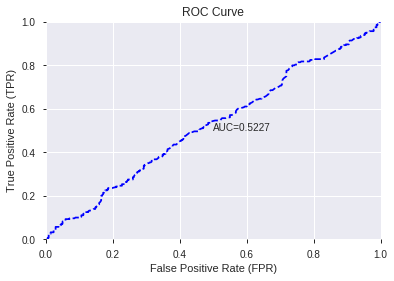

This function is available for GLM models only


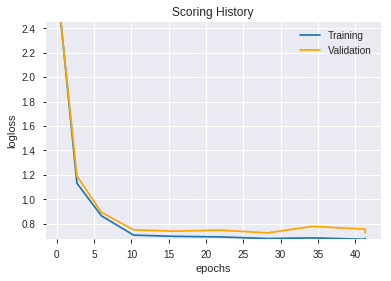

--2019-08-22 13:15:59--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 54.231.40.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|54.231.40.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_125523_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_125523_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_50_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLSTICKSANDWICH',
 'CDLEVENINGDOJISTAR',
 'CDLLADDERBOTTOM',
 'CDL3WHITESOLDIERS',
 'CDLGAPSIDESIDEWHITE',
 'CDLIDENTICAL3CROWS',
 'CDLINNECK',
 'CDLPIERCING',
 'CDLDARKCLOUDCOVER',
 'CDLMORNINGDOJISTAR',
 'is_quarter_start',
 'CDLTHRUSTING',
 'CDLONNECK',
 'CDLHOMINGPIGEON',
 'CDLUNIQUE3RIVER',
 'CDLTASUKIGAP',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLSTALLEDPATTERN',
 'CDL3INSIDE',
 'CDLSHOOTINGSTAR',
 'CDLSEPARATINGLINES',
 'CDLINVERTEDHAMMER',
 'CDLDOJISTAR',
 'CDLHARAMICROSS',
 'CDLMATCHINGLOW',
 'CDLGRAVESTONEDOJI',
 'CDLHANGINGMAN',
 'CDLTAKURI',
 'CDLDRAGONFLYDOJI',
 'is_month_start',
 'CDLADVANCEBLOCK',
 'CDLHAMMER',
 'is_month_end',
 'days_in_month',
 'VAR_14',
 'SINH',
 'EXP',
 'CORREL_30',
 'COSH',
 'SIN',
 'VAR_20',
 'CORREL_8',
 'VAR_30',
 'CORREL_14',
 'CDLRICKSHAWMAN',
 'CORREL_24',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI']

In [19]:
# DeepLearning with top XGBoost features
model_train(feature_name='XGBF',model_algo="DeepLearning",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id      auc   logloss  mean_per_class_error     rmse      mse
0  GLM_grid_1_AutoML_20190822_131656_model_1  0.50951  0.694467              0.497041  0.50066  0.25066

variable  relative_importance  scaled_importance  percentage
0       CDLSHOOTINGSTAR             0.009043           1.000000    0.073622
1        CDLMORNINGSTAR             0.006058           0.669925    0.049321
2    CDLIDENTICAL3CROWS             0.005204           0.575529    0.042371
3        is_month_start             0.005037           0.556977    0.041006
4        CDLMATCHINGLOW             0.004848           0.536141    0.039472
5             CDLHAMMER             0.004753           0.525591    0.038695
6      CDLSTICKSANDWICH             0.004704           0.520233    0.038300
7           CDLPIERCING             0.004562           0.504550    0.037146
8       CDLLADDERBOTTOM             0.004561           0.504337    0.037130
9    CDLEVENINGDOJISTAR             0.004483           0.495812    0.036502
10      CDLADVANCEBLOCK             0.004365           0.482726    0.035539
11            CORREL_14             0.004072           0.450257    0.033149
12          CDLDOJISTAR             0.003656           0.404267    0.029763
13       CDL3LINESTRIKE             0.003466           0.383323    0.028221
14            CDLONNECK             0.003318           0.366873    0.027010
15         CDLTASUKIGAP             0.003225           0.356604    0.026254
16      CDLUNIQUE3RIVER             0.003223           0.356387    0.026238
17    CDLSTALLEDPATTERN             0.003209           0.354905    0.026129
18    CDL3WHITESOLDIERS             0.003173           0.350906    0.025834
19   CDLMORNINGDOJISTAR             0.003162           0.349658    0.025742
20  CDLGAPSIDESIDEWHITE             0.003140           0.347227    0.025563
21               VAR_30             0.002788           0.308319    0.022699
22            CORREL_30             0.002622           0.289948    0.021346
23     is_quarter_start             0.002402           0.265679    0.019560
24    CDLGRAVESTONEDOJI             0.002323           0.256904    0.018914
25                  SIN             0.002114           0.233757    0.017210
26    CDLINVERTEDHAMMER             0.002062           0.228030    0.016788
27           CDL3INSIDE             0.002060           0.227844    0.016774
28             CORREL_8             0.001728           0.191050    0.014065
29    CDLDARKCLOUDCOVER             0.001584           0.175201    0.012899
30               VAR_20             0.001413           0.156243    0.011503
31         CDLTHRUSTING             0.001348           0.149090    0.010976
32        days_in_month             0.001306           0.144410    0.010632
33       CDLHARAMICROSS             0.001303           0.144108    0.010609
34               VAR_14             0.000949           0.104920    0.007724
35       CDLRICKSHAWMAN             0.000916           0.101283    0.007457
36       CDLEVENINGSTAR             0.000747           0.082618    0.006082
37            CDLTAKURI             0.000598           0.066148    0.004870
38        CDLHANGINGMAN             0.000565           0.062459    0.004598
39                  EXP             0.000547           0.060532    0.004456
40                 SINH             0.000544           0.060213    0.004433
41                 COSH             0.000542           0.059975    0.004415
42            CORREL_24             0.000261           0.028825    0.002122
43         is_month_end             0.000193           0.021355    0.001572
44            CDLINNECK             0.000188           0.020785    0.001530
45     CDLDRAGONFLYDOJI             0.000176           0.019474    0.001434
46      CDLHOMINGPIGEON             0.000127           0.014054    0.001035
47              CDLDOJI             0.000116           0.012881    0.000948
48    CDLLONGLEGGEDDOJI             0.000042           0.004645    0.000342
49   CDLSEPARATINGLINES             0.000000           0.000000    0.000000

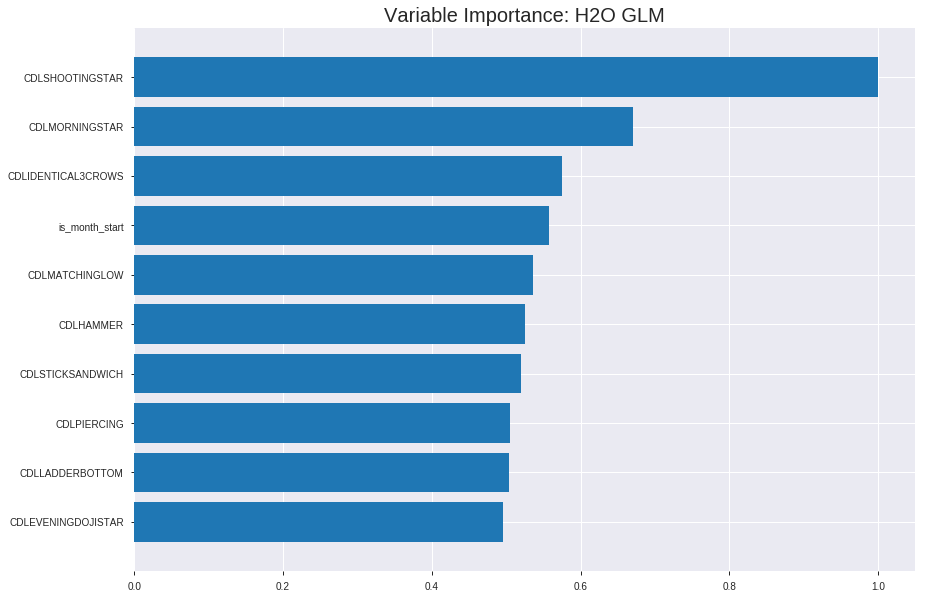

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_131656_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2493948310392985
RMSE: 0.4993944643658943
LogLoss: 0.6919351093670122
Null degrees of freedom: 4318
Residual degrees of freedom: 4269
Null deviance: 5986.238124775795
Residual deviance: 5976.935474712251
AIC: 6076.935474712251
AUC: 0.5377281657936845
pr_auc: 0.551913074156986
Gini: 0.07545633158736909
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4821851926721659: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      29   2095  0.9863   (2095.0/2124.0)
1      6    2189  0.0027   (6.0/2195.0)
Total  35   4284  0.4865   (2101.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.482185     0.675722   373
max f2                       0.48042      0.838495   381
max f0point5                 0.505389     0.569555   286
max accuracy                 0.509525     0.527437   165
max precision                0.560669     1          0
max recall                   0.471613     1          395
max specificity              0.560669     1          0
max absolute_mcc             0.509958     0.0790259  155
max min_per_class_accuracy   0.507912     0.514351   213
max mean_per_class_accuracy  0.509525     0.532034   165

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.520488           1.43102   1.43102            0.727273         0.534116  0.727273                    0.534116            0.0145786       0.0145786                  43.1021   43.1021
    2        0.0201436                   0.517983           1.28126   1.357              0.651163         0.518845  0.689655                    0.526568            0.0127563       0.0273349                  28.1263   35.7003
    3        0.0300996                   0.517002           1.14398   1.28654            0.581395         0.517428  0.653846                    0.523545            0.0113895       0.0387244                  14.3985   28.6543
    4        0.0400556                   0.516337           1.14398   1.25111            0.581395         0.516674  0.635838                    0.521837            0.0113895       0.0501139                  14.3985   25.1109
    5        0.0500116                   0.515584           0.869428  1.17513            0.44186          0.516004  0.597222                    0.520676            0.00865604      0.0587699                  -13.0572  17.5127
    6        0.100023                    0.512707           1.22067   1.1979             0.62037          0.514273  0.608796                    0.517474            0.0610478       0.119818                   22.0674   19.79
    7        0.150035                    0.51059            1.08403   1.15994            0.550926         0.511447  0.589506                    0.515465            0.0542141       0.174032                   8.40315   15.9944
    8        0.200046                    0.509724           1.12047   1.15008            0.569444         0.510096  0.584491                    0.514123            0.0560364       0.230068                   12.047    15.0075
    9        0.300069                    0.508897           0.915506  1.07189            0.465278         0.509271  0.544753                    0.512506            0.0915718       0.32164                    -8.44944  7.18855
    10       0.400093                    0.508367           1.04304   1.06467            0.530093         0.508625  0.541088                    0.511536            0.104328        0.425968                   4.30387   6.46738
    11       0.500116                    0.507887           0.906396  1.03302            0.460648         0.50812   0.525                       0.510852            0.0906606       0.516629                   -9.36039  3.30182
    12       0.599907                    0.50746            1.0135    1.02977            0.515081         0.507669  0.52335                     0.510323            0.101139        0.617768                   1.35015   2.97717
    13       0.699931                    0.507007           1.0066    1.02646            0.511574         0.507218  0.521667                    0.509879            0.100683        0.718451                   0.660065  2.64605
    14       0.799954                    0.506575           0.979272  1.02056            0.497685         0.506808  0.518669                    0.509495            0.0979499       0.816401                   -2.07279  2.05602
    15       0.899977                    0.505886           0.988382  1.01698            0.502315         0.506271  0.516851                    0.509137            0.098861        0.915262                   -1.16184  1.69839
    16       1                           0.430695           0.847184  1                  0.430556         0.499966  0.508219                    0.508219           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24998311468902762
RMSE: 0.49998311440390425
LogLoss: 0.6931144295656074
Null degrees of freedom: 1233
Residual degrees of freedom: 1184
Null deviance: 1709.574001855587
Residual deviance: 1710.6064121679192
AIC: 1810.6064121679192
AUC: 0.49686879446614324
pr_auc: 0.5093225347521226
Gini: -0.006262411067713525
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.42934929144859885: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    595   1        (595.0/595.0)
1      0    639   0        (0.0/639.0)
Total  0    1234  0.4822   (595.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.429349     0.682328   399
max f2                       0.429349     0.843008   399
max f0point5                 0.48223      0.573283   392
max accuracy                 0.507201     0.518639   285
max precision                0.584283     1          0
max recall                   0.429349     1          399
max specificity              0.584283     1          0
max absolute_mcc             0.511343     0.0468072  130
max min_per_class_accuracy   0.508496     0.500782   227
max mean_per_class_accuracy  0.509765     0.510447   173

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 50.92 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.532378           1.03985   1.03985            0.538462         0.545786  0.538462                    0.545786            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.530809           0.643714  0.849703           0.333333         0.531327  0.44                        0.538846            0.00625978      0.0172144                  -35.6286  -15.0297
    3        0.0299838                   0.521528           1.1265    0.939475           0.583333         0.525871  0.486486                    0.534638            0.0109546       0.028169                   12.65     -6.05253
    4        0.0405186                   0.51906            0.445648  0.81108            0.230769         0.519916  0.42                        0.53081             0.00469484      0.0328638                  -55.4352  -18.892
    5        0.0502431                   0.518177           1.28743   0.903276           0.666667         0.518628  0.467742                    0.528452            0.0125196       0.0453834                  28.7428   -9.67237
    6        0.100486                    0.513518           0.903276  0.903276           0.467742         0.515943  0.467742                    0.522198            0.0453834       0.0907668                  -9.67237  -9.67237
    7        0.149919                    0.511321           0.854768  0.887282           0.442623         0.512076  0.459459                    0.51886             0.0422535       0.13302                    -14.5232  -11.2718
    8        0.200162                    0.510201           1.37049   1.00857            0.709677         0.510718  0.522267                    0.516817            0.0688576       0.201878                   37.0488   0.857235
    9        0.299838                    0.50943            0.973421  0.996887           0.504065         0.509779  0.516216                    0.514477            0.0970266       0.298905                   -2.65786  -0.311297
    10       0.400324                    0.508976           1.02787   1.00466            0.532258         0.509211  0.520243                    0.513155            0.103286        0.402191                   2.78661   0.466316
    11       0.5                         0.50847            0.989122  1.00156            0.512195         0.508718  0.518639                    0.512271            0.0985915       0.500782                   -1.08783  0.156495
    12       0.599676                    0.508053           0.942021  0.991668           0.487805         0.508293  0.513514                    0.51161             0.0938967       0.594679                   -5.79793  -0.833228
    13       0.700162                    0.507594           1.02787   0.996863           0.532258         0.50782   0.516204                    0.511066            0.103286        0.697966                   2.78661   -0.313714
    14       0.799838                    0.507042           1.03622   1.00177            0.536585         0.507321  0.518744                    0.510599            0.103286        0.801252                   3.62228   0.17679
    15       0.899514                    0.506504           0.91062   0.991668           0.471545         0.506814  0.513514                    0.51018             0.0907668       0.892019                   -8.938    -0.833228
    16       1                           0.429349           1.07459   1                  0.556452         0.500585  0.517828                    0


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 13:16:56  0.000 sec   2            2.1       50            1.38387           1.38623
    2019-08-22 13:16:56  0.030 sec   4            1.3       51            1.38286           1.3868
    2019-08-22 13:16:56  0.056 sec   6            0.8       51            1.38158           1.38775
    2019-08-22 13:16:56  0.081 sec   8            0.5       51            1.38007           1.38923
    2019-08-22 13:16:56  0.101 sec   10           0.31      51            1.3785            1.39135

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5598705501618123)

('F1', 0.625)

('auc', 0.5095097210481826)

('logloss', 0.6944667288625486)

('mean_per_class_error', 0.47579247675401515)

('rmse', 0.5006596507091006)

('mse', 0.2506600858481586)

glm prediction progress: |████████████████████████████████████████████████| 100%


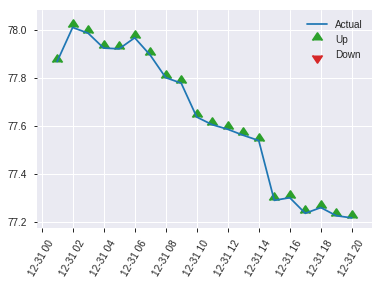


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2506600858481586
RMSE: 0.5006596507091006
LogLoss: 0.6944667288625486
Null degrees of freedom: 617
Residual degrees of freedom: 568
Null deviance: 858.8040410176391
Residual deviance: 858.3608768741101
AIC: 958.3608768741101
AUC: 0.5095097210481826
pr_auc: 0.4869803265280592
Gini: 0.01901944209636519
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.47956054238960866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    336  0.9941   (336.0/338.0)
1      0    280  0        (0.0/280.0)
Total  2    616  0.5437   (336.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.479561     0.625     397
max f2                       0.479561     0.806452  397
max f0point5                 0.479561     0.510204  397
max accuracy                 0.512353     0.559871  41
max precision                0.543868     1         0
max recall                   0.479561     1         397
max specificity              0.543868     1         0
max absolute_mcc             0.51947      0.1176    6
max min_per_class_accuracy   0.508357     0.497041  217
max mean_per_class_accuracy  0.50969      0.524208  129

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 50.87 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.519457           2.20714   2.20714            1                0.527869  1                           0.527869            0.025           0.025                      120.714   120.714
    2        0.0210356                   0.518456           1.10357   1.6978             0.5              0.519014  0.769231                    0.523782            0.0107143       0.0357143                  10.3571   69.7802
    3        0.0307443                   0.516855           0.735714  1.39398            0.333333         0.517462  0.631579                    0.521786            0.00714286      0.0428571                  -26.4286  39.3985
    4        0.0404531                   0.515299           1.10357   1.32429            0.5              0.516166  0.6                         0.520437            0.0107143       0.0535714                  10.3571   32.4286
    5        0.0501618                   0.51408            1.10357   1.28157            0.5              0.514849  0.580645                    0.519355            0.0107143       0.0642857                  10.3571   28.1567
    6        0.100324                    0.511541           1.06797   1.17477            0.483871         0.512354  0.532258                    0.515855            0.0535714       0.117857                   6.79724   17.477
    7        0.150485                    0.510949           1.06797   1.13917            0.483871         0.511265  0.516129                    0.514325            0.0535714       0.171429                   6.79724   13.9171
    8        0.200647                    0.510234           0.925576  1.08577            0.419355         0.510519  0.491935                    0.513374            0.0464286       0.217857                   -7.4424   8.57719
    9        0.300971                    0.509336           0.925576  1.03237            0.419355         0.509748  0.467742                    0.512165            0.0928571       0.310714                   -7.4424   3.23733
    10       0.399676                    0.508763           0.940749  1.00975            0.42623          0.509021  0.45749                     0.511389            0.0928571       0.403571                   -5.92506  0.974552
    11       0.5                         0.508357           0.925576  0.992857           0.419355         0.50857   0.449838                    0.510823            0.0928571       0.496429                   -7.4424   -0.714286
    12       0.600324                    0.508001           1.03237   0.999461           0.467742         0.508192  0.45283                     0.510383            0.103571        0.6                        3.23733   -0.0539084
    13       0.699029                    0.507622           1.01311   1.00139            0.459016         0.507807  0.453704                    0.51002             0.1             0.7                        1.31148   0.138889
    14       0.799353                    0.507182           0.889977  0.987406           0.403226         0.507424  0.447368                    0.509694            0.0892857       0.789286                   -11.0023  -1.2594
    15       0.899676                    0.506585           1.03237   0.99242            0.467742         0.506941  0.44964                     0.509387            0.103571        0.892857                   3.23733   -0.757965
    16       1                           0.473078           1.06797   1                  0.483871         0.502246  0.453074                    0.50867  

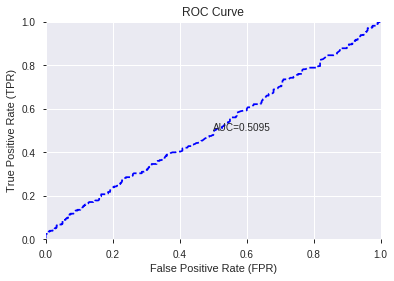

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


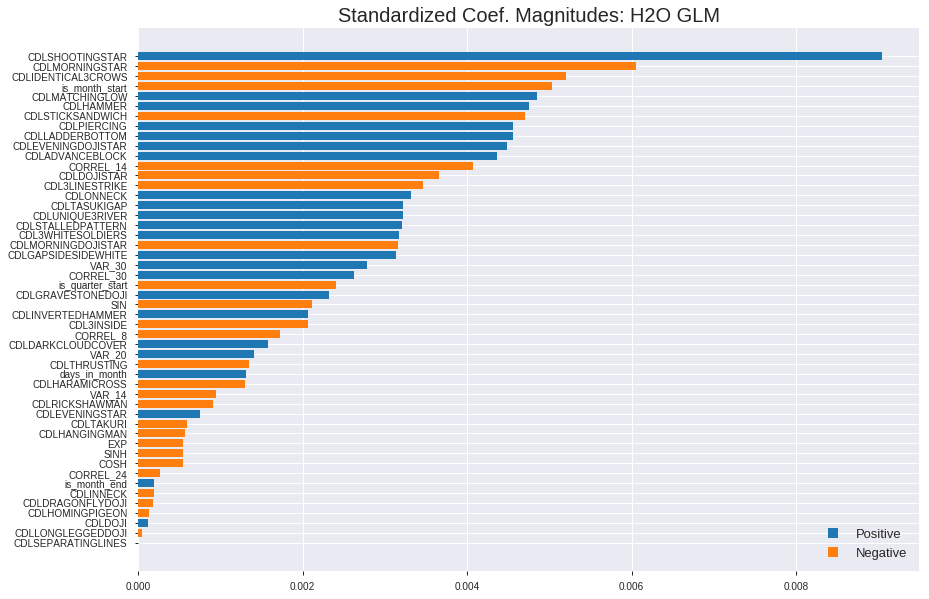

'log_likelihood'
--2019-08-22 13:17:06--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.162.155
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.162.155|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_131656_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_131656_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_58_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_58_s

['CDLSHOOTINGSTAR',
 'CDLMORNINGSTAR',
 'CDLIDENTICAL3CROWS',
 'is_month_start',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'CDLSTICKSANDWICH',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDLADVANCEBLOCK',
 'CORREL_14',
 'CDLDOJISTAR',
 'CDL3LINESTRIKE',
 'CDLONNECK',
 'CDLTASUKIGAP',
 'CDLUNIQUE3RIVER',
 'CDLSTALLEDPATTERN',
 'CDL3WHITESOLDIERS',
 'CDLMORNINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'VAR_30',
 'CORREL_30',
 'is_quarter_start',
 'CDLGRAVESTONEDOJI',
 'SIN',
 'CDLINVERTEDHAMMER',
 'CDL3INSIDE',
 'CORREL_8',
 'CDLDARKCLOUDCOVER',
 'VAR_20',
 'CDLTHRUSTING',
 'days_in_month',
 'CDLHARAMICROSS',
 'VAR_14',
 'CDLRICKSHAWMAN',
 'CDLEVENINGSTAR',
 'CDLTAKURI',
 'CDLHANGINGMAN',
 'EXP',
 'SINH',
 'COSH',
 'CORREL_24',
 'is_month_end',
 'CDLINNECK',
 'CDLDRAGONFLYDOJI',
 'CDLHOMINGPIGEON',
 'CDLDOJI',
 'CDLLONGLEGGEDDOJI',
 'CDLSEPARATINGLINES']

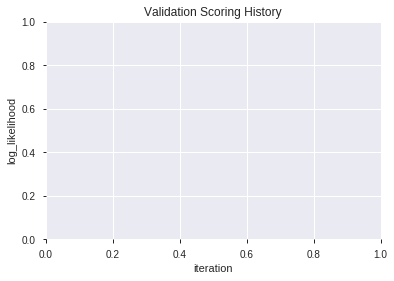

In [20]:
# GLM with top XGBoost features
model_train(feature_name='XGBF',model_algo="GLM",features_list = features_list[:model_selected_features])

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0               XGBoost_1_AutoML_20190822_131804  0.515638  0.703729              0.497041  0.505092  0.255118
1  XGBoost_grid_1_AutoML_20190822_131804_model_5  0.493555  0.736611              0.498521  0.519793  0.270185
2  XGBoost_grid_1_AutoML_20190822_131804_model_4  0.492572  0.702099              0.494083  0.504411  0.254431
3  XGBoost_grid_1_AutoML_20190822_131804_model_7  0.490971  0.712709              0.495869  0.509423  0.259512
4  XGBoost_grid_1_AutoML_20190822_131804_model_2  0.484547  0.702211              0.494389  0.504471  0.254491
5               XGBoost_2_AutoML_20190822_131804  0.482888  0.714160              0.500000  0.510038  0.260138
6  XGBoost_grid_1_AutoML_20190822_131804_model_3  0.477848  0.713927              0.500000  0.510058  0.260159
7  XGBoost_grid_1_AutoML_20190822_131804_model_1  0.467049  0.709073              0.497041  0.507737  0.257797
8  XGBoost_grid_1_AutoML_20190822_131804_model_6  0.463810  0.709750              0.495562  0.508107  0.258173
9               XGBoost_3_AutoML_20190822_131804  0.456725  0.712599              0.494083  0.509481  0.259571

variable  relative_importance  scaled_importance  percentage
0           CORREL_14          1171.553101           1.000000    0.127244
1           CORREL_30          1067.126587           0.910865    0.115902
2            CORREL_8          1014.714355           0.866127    0.110209
3              VAR_14           983.715088           0.839668    0.106842
4           CORREL_24           940.147705           0.802480    0.102111
5              VAR_30           924.022827           0.788716    0.100359
6                COSH           878.686890           0.750019    0.095435
7              VAR_20           803.536255           0.685873    0.087273
8                 SIN           778.232056           0.664274    0.084525
9                 EXP           259.013580           0.221086    0.028132
10      days_in_month           111.490883           0.095165    0.012109
11               SINH            99.751137           0.085144    0.010834
12            CDLDOJI            48.584961           0.041471    0.005277
13     CDLMATCHINGLOW            24.496653           0.020910    0.002661
14          CDLHAMMER            24.415607           0.020840    0.002652
15     is_month_start            18.022903           0.015384    0.001957
16     CDLRICKSHAWMAN            17.750090           0.015151    0.001928
17    CDLADVANCEBLOCK            14.289270           0.012197    0.001552
18  CDLLONGLEGGEDDOJI            10.248856           0.008748    0.001113
19    CDLSHOOTINGSTAR             6.090463           0.005199    0.000661
20       is_month_end             5.851241           0.004994    0.000636
21      CDLHANGINGMAN             5.418504           0.004625    0.000589

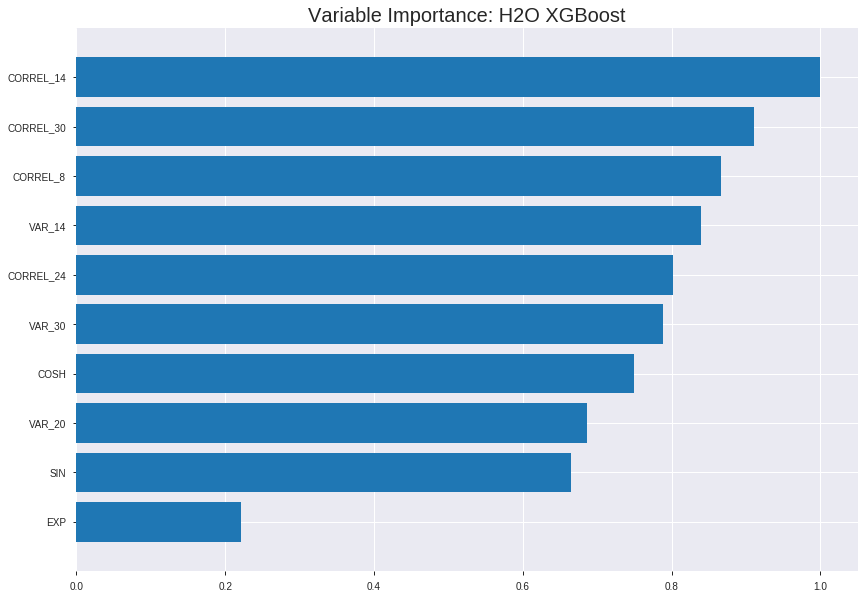

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_1_AutoML_20190822_131804


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.2039323144199416
RMSE: 0.45158865621264405
LogLoss: 0.5992674459732529
Mean Per-Class Error: 0.2044506003629204
AUC: 0.8756903422862266
pr_auc: 0.8767327911613326
Gini: 0.7513806845724531
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4913700342178345: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1516  608   0.2863   (608.0/2124.0)
1      312   1883  0.1421   (312.0/2195.0)
Total  1828  2491  0.213    (920.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.49137      0.803671  222
max f2                       0.447407     0.876894  275
max f0point5                 0.527857     0.810782  175
max accuracy                 0.510668     0.795323  196
max precision                0.763822     1         0
max recall                   0.31897      1         385
max specificity              0.763822     1         0
max absolute_mcc             0.510668     0.591113  196
max min_per_class_accuracy   0.508219     0.791344  199
max mean_per_class_accuracy  0.510668     0.795549  196

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.74 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.690046           1.96765    1.96765            1                0.711503  1                           0.711503            0.0200456       0.0200456                  96.7654   96.7654
    2        0.0201436                   0.672522           1.96765    1.96765            1                0.679995  1                           0.69593             0.01959         0.0396355                  96.7654   96.7654
    3        0.0300996                   0.658918           1.96765    1.96765            1                0.665338  1                           0.685811            0.01959         0.0592255                  96.7654   96.7654
    4        0.0400556                   0.650016           1.92189    1.95628            0.976744         0.654569  0.99422                     0.678046            0.0191344       0.0783599                  92.1894   95.628
    5        0.0500116                   0.642278           1.92189    1.94943            0.976744         0.646272  0.990741                    0.67172             0.0191344       0.0974943                  92.1894   94.9435
    6        0.100023                    0.616063           1.85834    1.90389            0.944444         0.627763  0.967593                    0.649742            0.0929385       0.190433                   85.834    90.3887
    7        0.150035                    0.596657           1.84012    1.88263            0.935185         0.6061    0.95679                     0.635195            0.0920273       0.28246                    84.0121   88.2632
    8        0.200046                    0.579923           1.69437    1.83557            0.861111         0.58793   0.93287                     0.623378            0.084738        0.367198                   69.4369   83.5566
    9        0.300069                    0.55515            1.63516    1.76876            0.831019         0.567848  0.89892                     0.604868            0.163554        0.530752                   63.5157   76.8763
    10       0.400093                    0.53117            1.3892     1.67387            0.706019         0.543168  0.850694                    0.589443            0.138952        0.669704                   38.92     67.3872
    11       0.500116                    0.508374           1.19335    1.57777            0.606481         0.520015  0.801852                    0.575557            0.119362        0.789066                   19.3346   57.7767
    12       0.599907                    0.48539            0.844585   1.45581            0.429234         0.497125  0.739869                    0.562511            0.0842825       0.873349                   -15.5415  45.5806
    13       0.699931                    0.459848           0.664994   1.3428             0.337963         0.473245  0.682435                    0.549754            0.0665148       0.939863                   -33.5006  34.2795
    14       0.799954                    0.433398           0.37349    1.2216             0.189815         0.446594  0.620839                    0.536855            0.0373576       0.977221                   -62.651   22.1597
    15       0.899977                    0.397072           0.168526   1.10456            0.0856481        0.416301  0.561358                    0.523457            0.0168565       0.994077                   -83.1474  10.4559
    16       1                           0.266237           0.0592118  1                  0.0300926        0.362586  0.508219                    



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25451242291845055
RMSE: 0.5044922426742066
LogLoss: 0.702447306924584
Mean Per-Class Error: 0.4819413211293907
AUC: 0.5014452729448587
pr_auc: 0.5124470858262119
Gini: 0.0028905458897174885
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31322336196899414: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      0    595   1        (595.0/595.0)
1      0    639   0        (0.0/639.0)
Total  0    1234  0.4822   (595.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.313223     0.682328   399
max f2                       0.313223     0.843008   399
max f0point5                 0.313223     0.573094   399
max accuracy                 0.492842     0.52107    215
max precision                0.660821     0.714286   5
max recall                   0.313223     1          399
max specificity              0.690091     0.998319   0
max absolute_mcc             0.613343     0.0517291  34
max min_per_class_accuracy   0.506603     0.508607   188
max mean_per_class_accuracy  0.492842     0.518059   215

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 50.51 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.645629           1.03985   1.03985            0.538462         0.663482  0.538462                    0.663482            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.631594           0.321857  0.695211           0.166667         0.63655   0.36                        0.650554            0.00312989      0.0140845                  -67.8143  -30.4789
    3        0.0299838                   0.624461           0.965571  0.782896           0.5              0.628349  0.405405                    0.643353            0.00938967      0.0234742                  -3.44288  -21.7104
    4        0.0405186                   0.61845            1.33694   0.926948           0.692308         0.622105  0.48                        0.637828            0.0140845       0.0375587                  33.6945   -7.30516
    5        0.0502431                   0.614426           0.482786  0.840981           0.25             0.61606   0.435484                    0.633615            0.00469484      0.0422535                  -51.7214  -15.9019
    6        0.100486                    0.589788           1.05901   0.949997           0.548387         0.6012    0.491935                    0.617408            0.0532081       0.0954617                  5.90136   -5.00025
    7        0.149919                    0.575373           1.07637   0.991668           0.557377         0.58299   0.513514                    0.606059            0.0532081       0.14867                    7.63745   -0.833228
    8        0.200162                    0.564155           0.934424  0.977299           0.483871         0.569892  0.506073                    0.596981            0.0469484       0.195618                   -6.55763  -2.27012
    9        0.299838                    0.542325           0.989122  0.981229           0.512195         0.553562  0.508108                    0.582547            0.0985915       0.29421                    -1.08783  -1.87709
    10       0.400324                    0.523814           1.13688   1.0203             0.58871          0.532115  0.52834                     0.569888            0.114241        0.408451                   13.6882   2.02999
    11       0.5                         0.506184           1.00482   1.01721            0.520325         0.515555  0.526742                    0.559057            0.100156        0.508607                   0.482207  1.72144
    12       0.599676                    0.489598           1.03622   1.02037            0.536585         0.498209  0.528378                    0.548943            0.103286        0.611894                   3.62228   2.03739
    13       0.700162                    0.470319           0.903276  1.00357            0.467742         0.479888  0.519676                    0.539032            0.0907668       0.70266                    -9.67237  0.356822
    14       0.799838                    0.449349           0.989122  1.00177            0.512195         0.459927  0.518744                    0.529174            0.0985915       0.801252                   -1.08783  0.17679
    15       0.899514                    0.418023           0.957721  0.996887           0.495935         0.433644  0.516216                    0.518588            0.0954617       0.896714                   -4.2279   -0.311297
    16       1                           0.313223           1.02787   1                  0.532258         0.383989  0.517828                    0.505


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:18:04  0.009 sec   0                  0.5              0.693147            0.5             0                  1                0.491781                         0.5                0.693147              0.5               0                    1                  0.482172
    2019-08-22 13:18:04  0.154 sec   5                  0.494817         0.682825            0.688749        0.68397            1.65462          0.408659                         0.500489           0.694127              0.486606          0.521106             1.03985            0.47893
    2019-08-22 13:18:04  0.277 sec   10                 0.489045         0.671423            0.747711        0.74873            1.8802           0.353786                         0.500681           0.694515              0.50059           0.518792             0.742747           0.481361
    2019-08-22 13:18:05  0.399 sec   15                 0.483431         0.66042             0.784372        0.78637            1.87821          0.30771                          0.501234           0.695624              0.48658           0.509339             0.891296           0.47893
    2019-08-22 13:18:05  0.527 sec   20                 0.478134         0.650102            0.809985        0.811479           1.92293          0.281547                         0.501425           0.696011              0.490278          0.51381              0.891296           0.47812
    2019-08-22 13:18:05  0.656 sec   25                 0.474447         0.642954            0.821174        0.823086           1.96765          0.270201                         0.501608           0.696388              0.493782          0.512934             1.03985            0.479741
    2019-08-22 13:18:05  0.818 sec   30                 0.469682         0.633761            0.833954        0.833725           1.96765          0.247048                         0.50172            0.696623              0.499271          0.517621             1.1884             0.481361
    2019-08-22 13:18:05  0.954 sec   35                 0.466064         0.626819            0.843222        0.84234            1.96765          0.24126                          0.502209           0.697639              0.501236          0.519761             0.891296           0.481361
    2019-08-22 13:18:05  1.111 sec   40                 0.460288         0.615804            0.85924         0.860537           1.96765          0.223431                         0.502581           0.698439              0.504892          0.520158             1.03985            0.480551
    2019-08-22 13:18:05  1.257 sec   45                 0.455842         0.607323            0.867048        0.868908           1.96765          0.225515                         0.503366           0.700077              0.504366          0.518654             1.1884             0.480551
    2019-08-22 13:18:06  1.406 sec   50                 0.451589         0.599267            0.87569         0.876733           1.96765          0.213012                         0.504492           0.702447              0.501445          0.512447             1.03985            0.482172

Variable Importances: 


variable           relative_importance    scaled_importance     percentage
-----------------  ---------------------  --------------------  ---------------------
CORREL_14          1171.5531005859375     1.0                   0.12724371318875535
CORREL_30          1067.1265869140625     0.910864890699664     0.11590183090589505
CORREL_8           1014.71435546875       0.8661274977303661    0.11020927890609707
VAR_14             983.715087890625       0.839667521172222     0.10684241323795138
CORREL_24          940.147705078125       0.8024798061717578    0.10211051029628714
---                ---                    ---                   ---
CDLADVANCEBLOCK    14.289270401000977     0.012196861067461968  0.0015519738914712272
CDLLONGLEGGEDDOJI  10.248855590820312     0.00874809309598897   0.0011131398488545515
CDLSHOOTINGSTAR    6.090463161468506      0.005198623227937716  0.0006614921229921082
is_month_end       5.851241111755371      0.004994430989793759  0.0006355099444063486
CDLHANGINGMAN      5.418504238128662      0.00462506072957228   0.0005885099009542707


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5469255663430421)

('F1', 0.625)

('auc', 0.5156382079459002)

('logloss', 0.7037292315963504)

('mean_per_class_error', 0.4722633136094674)

('rmse', 0.5050921844676026)

('mse', 0.25511811481025476)

xgboost prediction progress: |████████████████████████████████████████████| 100%


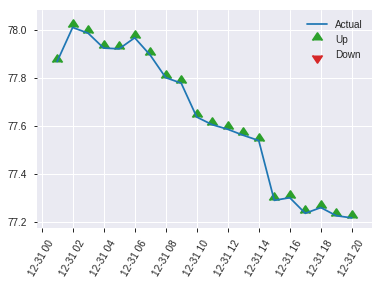


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.25511811481025476
RMSE: 0.5050921844676026
LogLoss: 0.7037292315963504
Mean Per-Class Error: 0.4722633136094674
AUC: 0.5156382079459002
pr_auc: 0.4571805980548855
Gini: 0.03127641589180041
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.33335456252098083: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    336  0.9941   (336.0/338.0)
1      0    280  0        (0.0/280.0)
Total  2    616  0.5437   (336.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.333355     0.625      397
max f2                       0.333355     0.806452   397
max f0point5                 0.390057     0.511533   384
max accuracy                 0.673331     0.546926   6
max precision                0.673331     0.5        6
max recall                   0.333355     1          397
max specificity              0.69087      0.997041   0
max absolute_mcc             0.679456     0.0734626  3
max min_per_class_accuracy   0.519654     0.511834   200
max mean_per_class_accuracy  0.541582     0.527737   155

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 51.73 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.673365           0.945918  0.945918           0.428571         0.68022   0.428571                    0.68022             0.0107143       0.0107143                  -5.40816   -5.40816
    2        0.0210356                   0.655814           1.10357   1.01868            0.5              0.663432  0.461538                    0.672472            0.0107143       0.0214286                  10.3571    1.86813
    3        0.0307443                   0.646235           0.735714  0.929323           0.333333         0.649387  0.421053                    0.665182            0.00714286      0.0285714                  -26.4286   -7.06767
    4        0.0404531                   0.642371           1.10357   0.971143           0.5              0.643975  0.44                        0.660092            0.0107143       0.0392857                  10.3571    -2.88571
    5        0.0501618                   0.634815           0.367857  0.854378           0.166667         0.639792  0.387097                    0.656163            0.00357143      0.0428571                  -63.2143   -14.5622
    6        0.100324                    0.606376           0.996774  0.925576           0.451613         0.6193    0.419355                    0.637731            0.05            0.0928571                  -0.322581  -7.4424
    7        0.150485                    0.590336           1.13917   0.996774           0.516129         0.597731  0.451613                    0.624398            0.0571429       0.15                       13.9171    -0.322581
    8        0.200647                    0.575922           1.21037   1.05017            0.548387         0.582772  0.475806                    0.613991            0.0607143       0.210714                   21.0369    5.01728
    9        0.300971                    0.550361           1.06797   1.05611            0.483871         0.562033  0.478495                    0.596672            0.107143        0.317857                   6.79724    5.6106
    10       0.399676                    0.535239           0.976932  1.03655            0.442623         0.541431  0.469636                    0.583029            0.0964286       0.414286                   -2.30679   3.65529
    11       0.5                         0.519493           0.996774  1.02857            0.451613         0.526717  0.466019                    0.57173             0.1             0.514286                   -0.322581  2.85714
    12       0.600324                    0.500539           1.06797   1.03516            0.483871         0.509723  0.469003                    0.561368            0.107143        0.621429                   6.79724    3.51559
    13       0.699029                    0.482521           0.940749  1.02183            0.42623          0.490535  0.462963                    0.551366            0.0928571       0.714286                   -5.92506   2.18254
    14       0.799353                    0.45895            0.854378  1.00081            0.387097         0.47117   0.453441                    0.541301            0.0857143       0.8                        -14.5622   0.0809717
    15       0.899676                    0.429072           1.06797   1.0083             0.483871         0.444364  0.456835                    0.530491            0.107143        0.907143                   6.79724    0.829908
    16       1                           0.298381           0.925576  1                  0.419355         0.398705  0.453074            

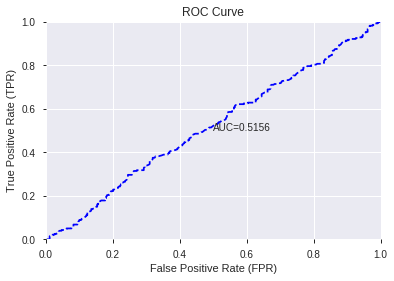

This function is available for GLM models only


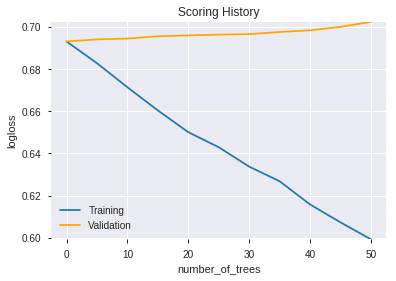

--2019-08-22 13:18:32--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.130.123
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.130.123|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.indexOf(String.java:1578)
	at java.base/java.lang.String.indexOf(String.java:1535)
	at java.base/java.lang.String.split(String.java:2274)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:106)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_1_AutoML_20190822_131804',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_1_AutoML_20190822_131804',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_66_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_66_sid_848c',
   'type

['CORREL_14',
 'CORREL_30',
 'CORREL_8',
 'VAR_14',
 'CORREL_24',
 'VAR_30',
 'COSH',
 'VAR_20',
 'SIN',
 'EXP',
 'days_in_month',
 'SINH',
 'CDLDOJI',
 'CDLMATCHINGLOW',
 'CDLHAMMER',
 'is_month_start',
 'CDLRICKSHAWMAN',
 'CDLADVANCEBLOCK',
 'CDLLONGLEGGEDDOJI',
 'CDLSHOOTINGSTAR',
 'is_month_end',
 'CDLHANGINGMAN']

In [21]:
# XGBoost with top XGBoost features
model_train(feature_name='XGBF',model_algo="XGBoost",features_list = features_list[:model_selected_features])

In [0]:
# PCA
try:
  del xgb_features,glm_features,dl_features
except:
  pass
gc.collect()

if features_to_include is True or 'PCA' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.pca import H2OPrincipalComponentAnalysisEstimator
      h2o_model = H2OPrincipalComponentAnalysisEstimator(seed=1, k=PCA_k, pca_method="GramSVD", max_iterations=10000)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OPrincipalComponentAnalysisEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [23]:
# DeepLearning with PCA
model_train(feature_name='PCA',model_algo="DeepLearning",training_frame=training_frame)

[]

In [24]:
# GLM with PCA
model_train(feature_name='PCA',model_algo="GLM",training_frame=training_frame)

[]

In [25]:
# XGBoost with PCA
model_train(feature_name='PCA',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# Generalized Low Rank
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'GLRM' in features_to_include:
  for _ in range(3):
    try:
      from h2o.estimators.glrm import H2OGeneralizedLowRankEstimator

      h2o_model = H2OGeneralizedLowRankEstimator(seed=1, k=GLRM_k)
      h2o_model.train(x=list(train_hf.columns[:-1]), training_frame=train_hf[:index_splits[0],:])

      display(h2o_model.varimp(use_pandas=True))
      display(h2o_model)

      training_frame = h2o_model.predict(train_hf)
      del h2o_model, H2OGeneralizedLowRankEstimator
      gc.collect()

      training_frame = training_frame.cbind(train_hf[data_label_name])
      break
    except KeyboardInterrupt:
      break
    except Exception as e:
      print(e)
      load_h2o()
else:
  training_frame = []

In [27]:
# DeepLearning with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="DeepLearning",training_frame=training_frame)

[]

In [28]:
# GLM with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="GLM",training_frame=training_frame)

[]

In [29]:
# XGBoost with Generalized Low Rank
model_train(feature_name='GLRM',model_algo="XGBoost",training_frame=training_frame)

[]

In [0]:
# High Correlation Filter 
try:
  del training_frame
except:
  pass
gc.collect()

if features_to_include is True or 'HCF' in features_to_include:
  corr_matrix = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).corr().abs()

  upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

  features_list = [column for column in upper.columns if not any(upper[column] > HCF_threshold)]

  del corr_matrix, upper
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [31]:
# DeepLearning with low correlation features
model_train(feature_name='HCF',model_algo="DeepLearning",features_list=features_list)

[]

In [32]:
# GLM with low correlation features
model_train(feature_name='HCF',model_algo="GLM",features_list=features_list)

[]

In [33]:
# XGBoost with low correlation features
model_train(feature_name='HCF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
#	Low Variance Filter  
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'LVF' in features_to_include:
  df_variance = pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1).var()
  features_list = [column for column in df_variance.index if df_variance[column]  > LVF_threshold]

  del df_variance
  gc.collect()

  display(len(features_list),features_list)
else:
  features_list = []

In [35]:
# DeepLearning with Low Variance features  
model_train(feature_name='LVF',model_algo="DeepLearning",features_list=features_list)

[]

In [36]:
# GLM with Low Variance features  
model_train(feature_name='LVF',model_algo="GLM",features_list=features_list)

[]

In [37]:
# XGBoost with Low Variance features  
model_train(feature_name='LVF',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select k best features
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'KBest' in features_to_include:
  from sklearn.feature_selection import SelectKBest
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectKBest(score_func=f_classif, k=select_k).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectKBest, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [39]:
# DeepLearning with Select k best features 
model_train(feature_name='KBest',model_algo="DeepLearning",features_list=features_list)

[]

In [40]:
# GLM with Select k best features
model_train(feature_name='KBest',model_algo="GLM",features_list=features_list)

[]

In [41]:
# XGBoost with Select k best features
model_train(feature_name='KBest',model_algo="XGBoost",features_list=features_list)

[]

In [0]:
# Select Percentile
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Percentile' in features_to_include:
  from sklearn.feature_selection import SelectPercentile
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectPercentile(score_func=f_classif, percentile=select_percentile).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectPercentile, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

In [43]:
# DeepLearning with Select Percentile features  
model_train(feature_name='Percentile',model_algo="DeepLearning",features_list=features_list)

[]

In [44]:
# GLM with Select Percentile features  
model_train(feature_name='Percentile',model_algo="GLM",features_list=features_list)

[]

In [45]:
# XGBoost with Select Percentile features  
model_train(feature_name='Percentile',model_algo="XGBoost",features_list=features_list)

[]

In [46]:
# Select Family-wise error
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'Fwe' in features_to_include:
  from sklearn.feature_selection import SelectFwe
  from sklearn.feature_selection import f_classif

  bestfeatures = SelectFwe(score_func=f_classif, alpha=select_alpha).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, SelectFwe, f_classif
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list=[]

/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:114: UserWarning: Features [ 12 892] are constant.
  UserWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:115: RuntimeWarning: invalid value encountered in true_divide
  f = msb / msw
/usr/local/lib/python3.6/dist-packages/sklearn/feature_selection/univariate_selection.py:721: RuntimeWarning: invalid value encountered in less
  return (self.pvalues_ < self.alpha / len(self.pvalues_))


0

[]

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_131932_model_4  0.522353  0.788409              0.495869  0.528313  0.279115
1  DeepLearning_grid_1_AutoML_20190822_131932_model_7  0.522015  0.689593              0.491124  0.498317  0.248320
2               DeepLearning_1_AutoML_20190822_131932  0.516219  0.702580              0.498521  0.503129  0.253139
3  DeepLearning_grid_1_AutoML_20190822_131932_model_5  0.514534  0.695327              0.483221  0.499394  0.249395
4  DeepLearning_grid_1_AutoML_20190822_131932_model_3  0.500174  1.193409              0.500000  0.586503  0.343986
5  DeepLearning_grid_1_AutoML_20190822_131932_model_9  0.500000  0.692606              0.500000  0.499729  0.249729
6  DeepLearning_grid_1_AutoML_20190822_131932_model_8  0.500000  0.694231              0.500000  0.500542  0.250542
7  DeepLearning_grid_1_AutoML_20190822_131932_model_6  0.489349  0.698015              0.498521  0.502409  0.252415
8  DeepLearning_grid_1_AutoML_20190822_131932_model_2  0.488620  0.724936              0.484034  0.514392  0.264599
9  DeepLearning_grid_1_AutoML_20190822_131932_model_1  0.486269  0.941388              0.489085  0.573798  0.329245

variable  relative_importance  scaled_importance  percentage
0                    CDLINNECK             1.000000           1.000000    0.003488
1              CDLHOMINGPIGEON             0.984652           0.984652    0.003435
2            CDL3WHITESOLDIERS             0.972801           0.972801    0.003393
3           CDLIDENTICAL3CROWS             0.971555           0.971555    0.003389
4                  CDLPIERCING             0.967191           0.967191    0.003374
...                        ...                  ...                ...         ...
1035                 MAVP_20_1             0.222777           0.222777    0.000777
1036   BBANDS_upperband_24_1_3             0.222356           0.222356    0.000776
1037  BBANDS_middleband_14_3_5             0.222210           0.222210    0.000775
1038    BBANDS_upperband_8_8_3             0.221965           0.221965    0.000774
1039                   MA_24_7             0.218323           0.218323    0.000762

[1040 rows x 4 columns]

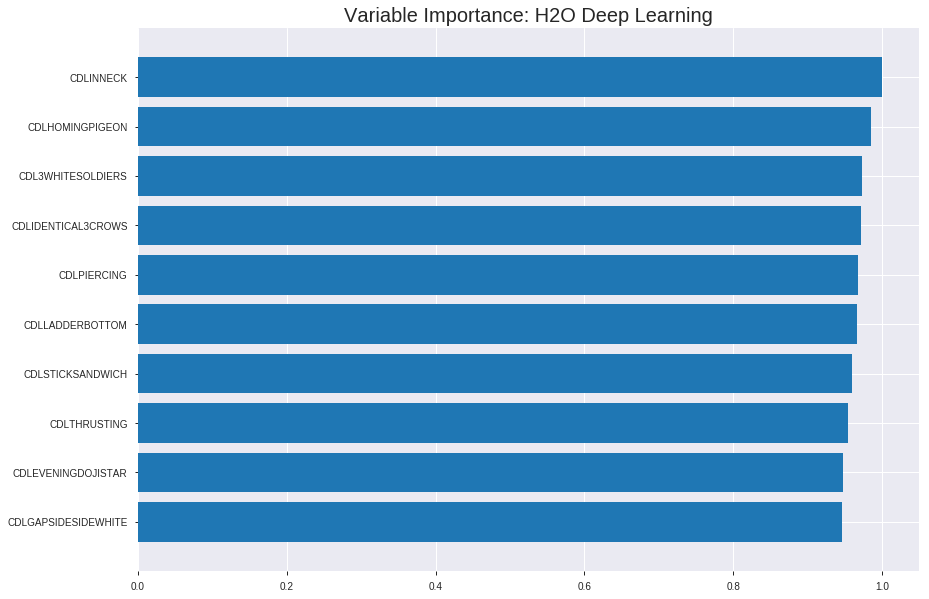

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_131932_model_4


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.18961844170785677
RMSE: 0.43545199701902476
LogLoss: 0.549425546024901
Mean Per-Class Error: 0.31266188778640025
AUC: 0.7791534217898064
pr_auc: 0.7908436491382625
Gini: 0.5583068435796128
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.48146398595307155: 


0     1     Error    Rate
-----  ----  ----  -------  ---------------
0      943   1181  0.556    (1181.0/2124.0)
1      229   1966  0.1043   (229.0/2195.0)
Total  1172  3147  0.3265   (1410.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.481464     0.736054  231
max f2                       0.228305     0.863723  323
max f0point5                 0.587017     0.708478  168
max accuracy                 0.515203     0.686733  210
max precision                0.998855     1         0
max recall                   0.0541801    1         380
max specificity              0.998855     1         0
max absolute_mcc             0.509866     0.390025  214
max min_per_class_accuracy   0.520811     0.653759  206
max mean_per_class_accuracy  0.530136     0.687338  200

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 54.22 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.990581           1.92293    1.92293            0.977273         0.994549   0.977273                    0.994549            0.01959         0.01959                    92.2934   92.2934
    2        0.0201436                   0.981266           1.96765    1.94504            1                0.985501   0.988506                    0.990077            0.01959         0.03918                    96.7654   94.5037
    3        0.0300996                   0.969073           1.96765    1.95252            1                0.97588    0.992308                    0.985381            0.01959         0.0587699                  96.7654   95.2518
    4        0.0400556                   0.955699           1.96765    1.95628            1                0.962547   0.99422                     0.979706            0.01959         0.0783599                  96.7654   95.628
    5        0.0500116                   0.939528           1.96765    1.95854            1                0.947201   0.99537                     0.973235            0.01959         0.0979499                  96.7654   95.8544
    6        0.100023                    0.86816            1.8219     1.89022            0.925926         0.903473   0.960648                    0.938354            0.0911162       0.189066                   82.1902   89.0223
    7        0.150035                    0.787421           1.65793    1.81279            0.842593         0.827088   0.921296                    0.901265            0.0829157       0.271982                   65.793    81.2792
    8        0.200046                    0.719404           1.39375    1.70803            0.708333         0.750317   0.868056                    0.863528            0.0697039       0.341686                   39.3755   70.8033
    9        0.300069                    0.623872           1.29355    1.56987            0.657407         0.672684   0.79784                     0.799913            0.129385        0.471071                   29.355    56.9872
    10       0.400093                    0.557989           1.12047    1.45752            0.569444         0.589133   0.740741                    0.747218            0.112073        0.583144                   12.047    45.7521
    11       0.643204                    0.519069           0.985701   1.27919            0.500952         0.524769   0.650108                    0.663139            0.239636        0.822779                   -1.42992  27.9187
    12       0.699931                    0.497618           0.883436   1.24711            0.44898          0.509406   0.633807                    0.65068             0.0501139       0.872893                   -11.6564  24.7114
    13       0.799954                    0.402652           0.701432   1.17888            0.356481         0.457752   0.599132                    0.626557            0.0701595       0.943052                   -29.8568  17.8884
    14       0.899977                    0.200649           0.510132   1.10456            0.259259         0.311101   0.561358                    0.591497            0.0510251       0.994077                   -48.9868  10.4559
    15       1                           0.000534079        0.0592118  1                  0.0300926        0.0986205  0.508219                    0.542198            0.00592255      1                          -94.0788  0



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2664534253903034
RMSE: 0.5161912682236144
LogLoss: 0.7339614099594761
Mean Per-Class Error: 0.48426769768940436
AUC: 0.4834418274351995
pr_auc: 0.4991603252347279
Gini: -0.033116345129601044
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.13140088157445695: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    592   0.995    (592.0/595.0)
1      0    639   0        (0.0/639.0)
Total  3    1231  0.4797   (592.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.131401     0.683422   396
max f2                       0.131401     0.843676   396
max f0point5                 0.395637     0.578481   350
max accuracy                 0.395637     0.531605   350
max precision                0.966856     1          0
max recall                   0.131401     1          396
max specificity              0.966856     1          0
max absolute_mcc             0.395637     0.0693838  350
max min_per_class_accuracy   0.528538     0.474178   245
max mean_per_class_accuracy  0.395637     0.515732   350

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 55.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.894028           1.03985   1.03985            0.538462         0.922741  0.538462                    0.922741            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.834513           0.321857  0.695211           0.166667         0.861959  0.36                        0.893566            0.00312989      0.0140845                  -67.8143  -30.4789
    3        0.0299838                   0.799602           1.1265    0.835089           0.583333         0.813679  0.432432                    0.867657            0.0109546       0.0250391                  12.65     -16.4911
    4        0.0405186                   0.786248           1.03985   0.888326           0.538462         0.793089  0.46                        0.848269            0.0109546       0.0359937                  3.98459   -11.1674
    5        0.0502431                   0.767421           1.28743   0.965571           0.666667         0.77367   0.5                         0.833831            0.0125196       0.0485133                  28.7428   -3.44288
    6        0.100486                    0.707667           0.903276  0.934424           0.467742         0.737697  0.483871                    0.785764            0.0453834       0.0938967                  -9.67237  -6.55763
    7        0.149919                    0.677105           1.04472   0.970791           0.540984         0.690433  0.502703                    0.75433             0.0516432       0.14554                    4.47164   -2.92095
    8        0.200162                    0.641258           0.716392  0.906933           0.370968         0.656733  0.469636                    0.729832            0.0359937       0.181534                   -28.3608  -9.30667
    9        0.299838                    0.599275           0.942021  0.918597           0.487805         0.617683  0.475676                    0.69255             0.0938967       0.27543                    -5.79793  -8.14025
    10       0.400324                    0.55589            1.01229   0.942116           0.524194         0.577549  0.487854                    0.663684            0.101721        0.377152                   1.22924   -5.7884
    11       0.5                         0.527859           0.989122  0.951487           0.512195         0.54092   0.492707                    0.63921             0.0985915       0.475743                   -1.08783  -4.85133
    12       0.73987                     0.519069           1.1091    1.00259            0.574324         0.519675  0.519168                    0.600456            0.266041        0.741784                   10.9102   0.258653
    13       0.799838                    0.50051            1.14825   1.01351            0.594595         0.511202  0.524823                    0.593765            0.0688576       0.810642                   14.8247   1.35074
    14       0.899514                    0.444918           0.989122  1.01081            0.512195         0.476943  0.523423                    0.580819            0.0985915       0.909233                   -1.08783  1.08052
    15       1                           0.0219404          0.903276  1                  0.467742         0.35621   0.517828                    0.558249            0.0907668       1                          -9.67237  0


Scoring History: 


timestamp            duration           training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  -----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 13:39:37  0.000 sec                            0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 13:39:42  10.467 sec         146 obs/sec       0.156286  1             675        0.647053         2.10074             -0.675165      0.502821        0.461882           0.894388         0.491781                         0.6302             1.51435               -0.590629        0.489502          0.504396             0.594198           0.482172
    2019-08-22 13:40:39  1 min  7.512 sec   165 obs/sec       2.1461    14            9269       0.631584         1.51795             -0.596024      0.546977        0.554429           1.3863           0.491781                         0.657225           1.53451               -0.729976        0.502777          0.525367             0.891296           0.480551
    2019-08-22 13:41:35  2 min  3.594 sec   179 obs/sec       4.43969   29            19175      0.564925         1.24502             -0.276905      0.547292        0.572586           1.47574          0.491781                         0.611488           1.15194               -0.497574        0.460378          0.485608             0.742747           0.482172
    2019-08-22 13:42:31  2 min 59.084 sec   189 obs/sec       6.89326   45            29772      0.512624         0.733267            -0.0514175     0.596613        0.593161           1.56518          0.471174                         0.53031            0.777041              -0.126345        0.509284          0.523133             1.1884             0.47812
    2019-08-22 13:43:27  3 min 55.649 sec   196 obs/sec       9.47233   62            40911      0.493705         0.685416            0.0247594      0.630457        0.635509           1.56518          0.459134                         0.546012           0.805102              -0.194033        0.45919           0.49505              1.1884             0.474878
    2019-08-22 13:44:24  4 min 52.225 sec   203 obs/sec       12.2183   80            52771      0.508487         0.735905            -0.0345163     0.630599        0.615393           1.56518          0.457282                         0.564231           0.932123              -0.275046        0.542614          0.545876             1.1884             0.474878
    2019-08-22 13:45:20  5 min 48.498 sec   210 obs/sec       15.1137   99            65276      0.469775         0.627267            0.117009       0.691978        0.703817           1.92293          0.402176                         0.523152           0.746711              -0.0961477       0.494574          0.516157             1.03985            0.47731
    2019-08-22 13:46:15  6 min 43.288 sec   218 obs/sec       18.2024   119           78616      0.466994         0.620324            0.127431       0.694623        0.714401           1.87821          0.41028                          0.5296             0.764658              -0.123332        0.474787          0.492256             0.594198           0.481361
    2019-08-22

Variable Importances: 


variable                  relative_importance    scaled_importance    percentage
------------------------  ---------------------  -------------------  ---------------------
CDLINNECK                 1.0                    1.0                  0.0034881902021836673
CDLHOMINGPIGEON           0.9846522808074951     0.9846522808074951   0.0034346544384705057
CDL3WHITESOLDIERS         0.9728009104728699     0.9728009104728699   0.0033933146045868156
CDLIDENTICAL3CROWS        0.971554696559906      0.971554696559906    0.00338896757342579
CDLPIERCING               0.9671912789344788     0.9671912789344788   0.003373747142816739
---                       ---                    ---                  ---
MAVP_20_1                 0.22277741134166718    0.22277741134166718  0.0007770899835098441
BBANDS_upperband_24_1_3   0.2223556488752365     0.2223556488752365   0.0007756187958067918
BBANDS_middleband_14_3_5  0.2222103476524353     0.2222103476524353   0.0007751119575050514
BBANDS_upperband_8_8_3    0.2219650149345398     0.2219650149345398   0.0007742561903222131
MA_24_7                   0.21832305192947388    0.21832305192947388  0.0007615523306512268


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5647249190938511)

('F1', 0.6248600223964166)

('auc', 0.5223531276415891)

('logloss', 0.7884086552807079)

('mean_per_class_error', 0.4730029585798816)

('rmse', 0.5283129075741171)

('mse', 0.27911452830941763)

deeplearning prediction progress: |███████████████████████████████████████| 100%


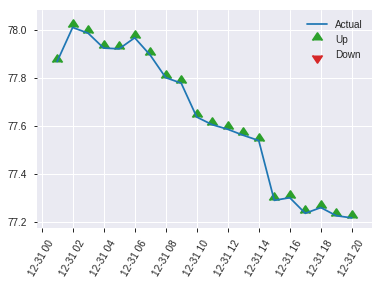


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.27911452830941763
RMSE: 0.5283129075741171
LogLoss: 0.7884086552807079
Mean Per-Class Error: 0.4730029585798816
AUC: 0.5223531276415891
pr_auc: 0.47541450460216006
Gini: 0.04470625528317829
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.0045177261811697456: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    334  0.9882   (334.0/338.0)
1      1    279  0.0036   (1.0/280.0)
Total  5    613  0.5421   (335.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.00451773   0.62486    396
max f2                       0.00223954   0.805987   398
max f0point5                 0.376273     0.514469   337
max accuracy                 0.737692     0.564725   51
max precision                0.946667     1          0
max recall                   0.00223954   1          398
max specificity              0.946667     1          0
max absolute_mcc             0.737692     0.0914643  51
max min_per_class_accuracy   0.566532     0.5        225
max mean_per_class_accuracy  0.737692     0.526997   51

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 55.45 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.885471           1.26122   1.26122            0.571429         0.919116  0.571429                    0.919116            0.0142857       0.0142857                  26.1224    26.1224
    2        0.0210356                   0.832053           0.735714  1.01868            0.333333         0.854458  0.461538                    0.889274            0.00714286      0.0214286                  -26.4286   1.86813
    3        0.0307443                   0.812501           1.10357   1.04549            0.5              0.822189  0.473684                    0.868089            0.0107143       0.0321429                  10.3571    4.54887
    4        0.0404531                   0.792068           0.367857  0.882857           0.166667         0.802852  0.4                         0.852432            0.00357143      0.0357143                  -63.2143   -11.7143
    5        0.0501618                   0.779606           1.10357   0.925576           0.5              0.785381  0.419355                    0.839455            0.0107143       0.0464286                  10.3571    -7.4424
    6        0.100324                    0.733093           1.56636   1.24597            0.709677         0.752941  0.564516                    0.796198            0.0785714       0.125                      56.6359    24.5968
    7        0.150485                    0.699766           0.996774  1.1629             0.451613         0.71783   0.526882                    0.770075            0.05            0.175                      -0.322581  16.2903
    8        0.200647                    0.671139           0.78318   1.06797            0.354839         0.685253  0.483871                    0.74887             0.0392857       0.214286                   -21.682    6.79724
    9        0.300971                    0.634083           0.961175  1.03237            0.435484         0.651943  0.467742                    0.716561            0.0964286       0.310714                   -3.88249   3.23733
    10       0.399676                    0.60248            0.940749  1.00975            0.42623          0.617135  0.45749                     0.692006            0.0928571       0.403571                   -5.92506   0.974552
    11       0.5                         0.566145           0.961175  1                  0.435484         0.584562  0.453074                    0.670448            0.0964286       0.5                        -3.88249   0
    12       0.600324                    0.53611            1.13917   1.02326            0.516129         0.550397  0.463612                    0.650385            0.114286        0.614286                   13.9171    2.32576
    13       0.776699                    0.519069           0.992202  1.01621            0.449541         0.521534  0.460417                    0.621125            0.175           0.789286                   -0.779817  1.62054
    14       0.799353                    0.507386           1.26122   1.02315            0.571429         0.513866  0.463563                    0.618086            0.0285714       0.817857                   26.1224    2.31492
    15       0.899676                    0.348246           0.996774  1.02021            0.451613         0.453424  0.46223                     0.599724            0.1             0.917857                   -0.322581  2.02081
    16       1                           0.000835941        0.818779  1                  0.370968         0.149229  0.453074                    0.55

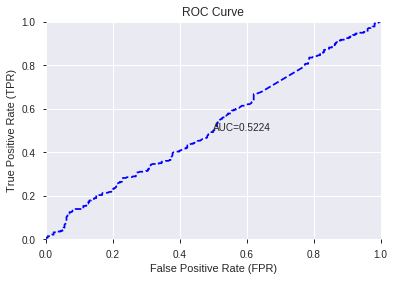

This function is available for GLM models only


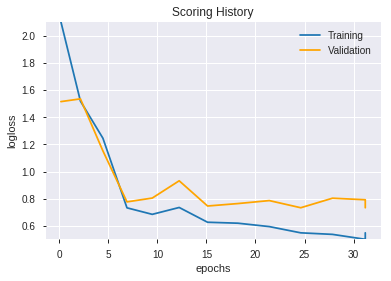

--2019-08-22 14:19:45--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.144.196
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.144.196|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_131932_model_4',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_131932_model_4',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_74_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['CDLINNECK',
 'CDLHOMINGPIGEON',
 'CDL3WHITESOLDIERS',
 'CDLIDENTICAL3CROWS',
 'CDLPIERCING',
 'CDLLADDERBOTTOM',
 'CDLSTICKSANDWICH',
 'CDLTHRUSTING',
 'CDLEVENINGDOJISTAR',
 'CDLGAPSIDESIDEWHITE',
 'CDLUNIQUE3RIVER',
 'CDLDARKCLOUDCOVER',
 'CDLONNECK',
 'is_quarter_start',
 'CDLTASUKIGAP',
 'CDLMORNINGDOJISTAR',
 'CDLMORNINGSTAR',
 'CDLEVENINGSTAR',
 'CDL3LINESTRIKE',
 'CDLSTALLEDPATTERN',
 'CDLSHOOTINGSTAR',
 'CDL3INSIDE',
 'CDLINVERTEDHAMMER',
 'CDLSEPARATINGLINES',
 'CDLADVANCEBLOCK',
 'CDLHANGINGMAN',
 'CDLGRAVESTONEDOJI',
 'CDLMATCHINGLOW',
 'CDLDOJISTAR',
 'CDLDRAGONFLYDOJI',
 'COSH',
 'CDLTAKURI',
 'EXP',
 'SINH',
 'CDLHAMMER',
 'BOP',
 'HT_PHASOR_quadrature',
 'is_month_end',
 'CDLHARAMICROSS',
 'BETA_8',
 'day',
 'is_month_start',
 'hour',
 'days_in_month',
 'Volume',
 'BETA_12',
 'HT_DCPERIOD',
 'SIN',
 'CORREL_8',
 'CDLXSIDEGAP3METHODS',
 'HT_TRENDMODE',
 'CDLDOJI',
 'dayofweek',
 'BETA_24',
 'CDLRICKSHAWMAN',
 'SUB',
 'CORREL_12',
 'BETA_30',
 'CDLSPINNINGTOP',
 'weekday

In [47]:
# DeepLearning with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse      mse
0  GLM_grid_1_AutoML_20190822_142042_model_1  0.499783  0.695974              0.494083  0.501408  0.25141

variable  relative_importance  scaled_importance  percentage
0          CDLXSIDEGAP3METHODS             0.007474           1.000000    0.017159
1                          BOP             0.006800           0.909881    0.015613
2                    CDLHARAMI             0.006739           0.901783    0.015474
3              CDLSHOOTINGSTAR             0.006617           0.885389    0.015193
4                 CDLSHORTLINE             0.005820           0.778771    0.013363
...                        ...                  ...                ...         ...
1035  BBANDS_middleband_24_2_4             0.000000           0.000000    0.000000
1036  BBANDS_middleband_24_2_5             0.000000           0.000000    0.000000
1037  BBANDS_middleband_30_2_3             0.000000           0.000000    0.000000
1038  BBANDS_middleband_30_2_4             0.000000           0.000000    0.000000
1039  BBANDS_middleband_30_2_5             0.000000           0.000000    0.000000

[1040 rows x 4 columns]

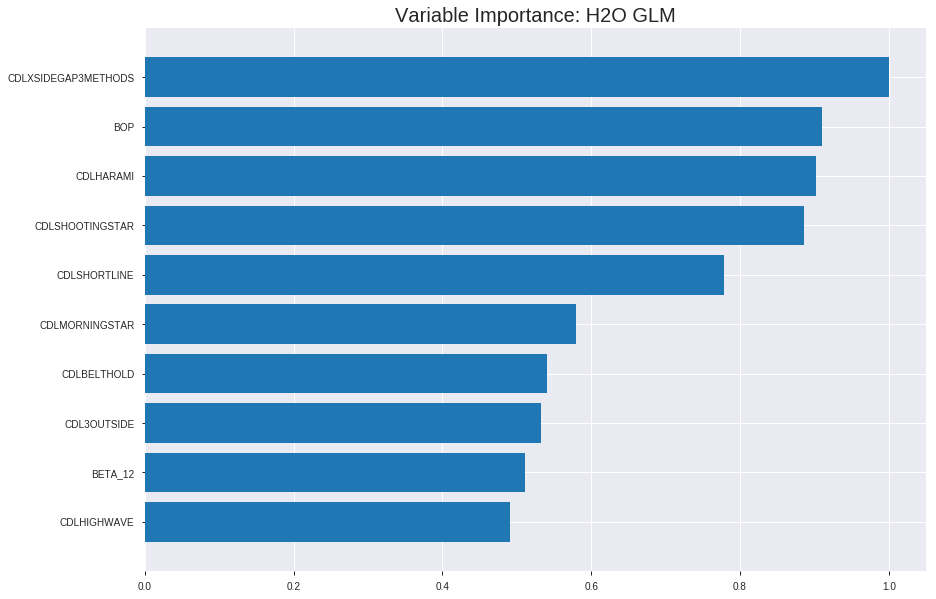

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_142042_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.2482246318375439
RMSE: 0.49822146866383016
LogLoss: 0.6895894835121869
Null degrees of freedom: 4318
Residual degrees of freedom: 3298
Null deviance: 5986.238124775795
Residual deviance: 5956.67395857827
AIC: 7998.67395857827
AUC: 0.5585322746011523
pr_auc: 0.5616284279901821
Gini: 0.11706454920230458
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4617277384903839: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      20   2104  0.9906   (2104.0/2124.0)
1      4    2191  0.0018   (4.0/2195.0)
Total  24   4295  0.4881   (2108.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.461728     0.675193   385
max f2                       0.454398     0.838044   392
max f0point5                 0.48415      0.571027   319
max accuracy                 0.513613     0.546886   175
max precision                0.583162     1          0
max recall                   0.440234     1          398
max specificity              0.583162     1          0
max absolute_mcc             0.513613     0.0987599  175
max min_per_class_accuracy   0.508681     0.54123    202
max mean_per_class_accuracy  0.513613     0.548473   175

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.555066           1.52046   1.52046            0.772727         0.562727  0.772727                    0.562727            0.0154897       0.0154897                  52.046    52.046
    2        0.0201436                   0.548845           1.05247   1.28915            0.534884         0.551663  0.655172                    0.557259            0.0104784       0.0259681                  5.2466    28.9152
    3        0.0300996                   0.545619           1.14398   1.24114            0.581395         0.547177  0.630769                    0.553924            0.0113895       0.0373576                  14.3985   24.1135
    4        0.0400556                   0.542374           1.14398   1.21699            0.581395         0.543963  0.618497                    0.551448            0.0113895       0.0487472                  14.3985   21.6988
    5        0.0500116                   0.540062           1.14398   1.20246            0.581395         0.541173  0.611111                    0.549403            0.0113895       0.0601367                  14.3985   20.2455
    6        0.100023                    0.53248            1.12047   1.16146            0.569444         0.536107  0.590278                    0.542755            0.0560364       0.116173                   12.047    16.1462
    7        0.150035                    0.528234           1.17513   1.16602            0.597222         0.530319  0.592593                    0.53861             0.0587699       0.174943                   17.5127   16.6017
    8        0.200046                    0.524324           1.10225   1.15008            0.560185         0.526358  0.584491                    0.535547            0.0551253       0.230068                   10.225    15.0075
    9        0.300069                    0.5189             1.08403   1.12806            0.550926         0.521587  0.573302                    0.530893            0.108428        0.338497                   8.40315   12.8061
    10       0.400093                    0.513763           1.09314   1.11933            0.555556         0.516276  0.568866                    0.527239            0.109339        0.447836                   9.3141    11.9331
    11       0.500116                    0.508506           0.942834  1.08403            0.479167         0.511169  0.550926                    0.524025            0.0943052       0.542141                   -5.71659  8.40315
    12       0.599907                    0.503266           0.949587  1.06167            0.482599         0.505975  0.53956                     0.521023            0.0947608       0.636902                   -5.0413   6.16673
    13       0.699931                    0.497765           0.92006   1.04143            0.467593         0.500673  0.529276                    0.518114            0.0920273       0.728929                   -7.99397  4.1431
    14       0.799954                    0.49154            0.942834  1.0291             0.479167         0.494608  0.52301                     0.515175            0.0943052       0.823235                   -5.71659  2.91028
    15       0.899977                    0.482033           0.974717  1.02306            0.49537          0.487249  0.519938                    0.512072            0.0974943       0.920729                   -2.52826  2.30585
    16       1                           0.432598           0.792527  1                  0.402778         0.473559  0.508219                    0.508219           



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.25010966776280236
RMSE: 0.5001096557384214
LogLoss: 0.6933656504237403
Null degrees of freedom: 1233
Residual degrees of freedom: 213
Null deviance: 1709.574001855587
Residual deviance: 1711.226425245791
AIC: 3753.226425245791
AUC: 0.4988203732197104
pr_auc: 0.5214548906483873
Gini: -0.0023592535605791998
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.458478137080364: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    590   0.9916   (590.0/595.0)
1      2    637   0.0031   (2.0/639.0)
Total  7    1227  0.4797   (592.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.458478     0.682744   392
max f2                       0.444047     0.843008   399
max f0point5                 0.471391     0.575089   357
max accuracy                 0.472101     0.525122   354
max precision                0.562138     1          0
max recall                   0.444047     1          399
max specificity              0.562138     1          0
max absolute_mcc             0.553588     0.0441356  5
max min_per_class_accuracy   0.50374      0.485714   197
max mean_per_class_accuracy  0.513406     0.512943   141

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 50.37 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.550385           1.03985   1.03985            0.538462         0.553677  0.538462                    0.553677            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.542146           1.44836   1.23593            0.75             0.545522  0.64                        0.549763            0.0140845       0.0250391                  44.8357   23.5931
    3        0.0299838                   0.539336           0.965571  1.14825            0.5              0.540899  0.594595                    0.546888            0.00938967      0.0344288                  -3.44288  14.8247
    4        0.0405186                   0.536293           1.03985   1.12006            0.538462         0.538111  0.58                        0.544606            0.0109546       0.0453834                  3.98459   12.0063
    5        0.0502431                   0.534703           0.804643  1.05901            0.416667         0.535255  0.548387                    0.542796            0.00782473      0.0532081                  -19.5357  5.90136
    6        0.100486                    0.52819            0.903276  0.981145           0.467742         0.530674  0.508065                    0.536735            0.0453834       0.0985915                  -9.67237  -1.88551
    7        0.149919                    0.523813           1.10803   1.02298            0.57377          0.525941  0.52973                     0.533176            0.0547731       0.153365                   10.8033   2.29835
    8        0.200162                    0.520448           0.903276  0.992936           0.467742         0.522109  0.51417                     0.530398            0.0453834       0.198748                   -9.67237  -0.706443
    9        0.299838                    0.51425            1.09902   1.0282             0.569106         0.517135  0.532432                    0.525989            0.109546        0.308294                   9.90241   2.82029
    10       0.400324                    0.508698           0.949997  1.00857            0.491935         0.511626  0.522267                    0.522384            0.0954617       0.403756                   -5.00025  0.857235
    11       0.5                         0.503721           0.847819  0.976526           0.439024         0.506266  0.505673                    0.519171            0.084507        0.488263                   -15.2181  -2.34742
    12       0.599676                    0.498795           0.942021  0.970791           0.487805         0.501352  0.502703                    0.516209            0.0938967       0.58216                    -5.79793  -2.92095
    13       0.700162                    0.493626           1.12131   0.992393           0.580645         0.496468  0.513889                    0.513376            0.112676        0.694836                   12.1308   -0.760737
    14       0.799838                    0.486969           1.08332   1.00372            0.560976         0.490144  0.519757                    0.510481            0.107981        0.802817                   8.33238   0.372447
    15       0.899514                    0.478785           1.05192   1.00907            0.544715         0.483143  0.522523                    0.507451            0.104851        0.907668                   5.19231   0.90654
    16       1                           0.444047           0.91885   1                  0.475806         0.469945  0.517828                    0.503682


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 14:20:50  0.000 sec   2            2.9       1021          1.37918           1.38673
    2019-08-22 14:20:55  4.827 sec   4            2.1       1027          1.37766           1.38746
    2019-08-22 14:21:00  9.676 sec   6            1.5       1030          1.37585           1.38835
    2019-08-22 14:21:05  14.771 sec  8            1.1       1034          1.37371           1.38954
    2019-08-22 14:21:10  19.704 sec  10           0.81      1035          1.37129           1.39123

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5501618122977346)

('F1', 0.6263982102908278)

('auc', 0.4997833896872359)

('logloss', 0.6959741824084548)

('mean_per_class_error', 0.47952240067624685)

('rmse', 0.5014082717237665)

('mse', 0.2514102549530144)

glm prediction progress: |████████████████████████████████████████████████| 100%


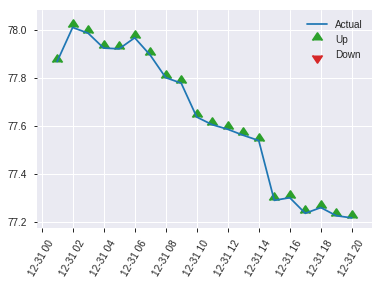


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2514102549530144
RMSE: 0.5014082717237665
LogLoss: 0.6959741824084548
Null degrees of freedom: 617
Residual degrees of freedom: -403
Null deviance: 858.8040410176391
Residual deviance: 860.2240894568502
AIC: 2902.2240894568504
AUC: 0.4997833896872359
pr_auc: 0.4487272123137639
Gini: -0.00043322062552819673
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4498667159388986: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      4    334  0.9882   (334.0/338.0)
1      0    280  0        (0.0/280.0)
Total  4    614  0.5405   (334.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.449867     0.626398   395
max f2                       0.449867     0.807382   395
max f0point5                 0.484937     0.513029   340
max accuracy                 0.550867     0.550162   9
max precision                0.554716     0.666667   2
max recall                   0.449867     1          395
max specificity              0.557156     0.997041   0
max absolute_mcc             0.449867     0.0734626  395
max min_per_class_accuracy   0.510198     0.497041   193
max mean_per_class_accuracy  0.499095     0.520478   263

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 50.95 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.551337           1.26122   1.26122            0.571429         0.553864  0.571429                    0.553864            0.0142857       0.0142857                  26.1224   26.1224
    2        0.0210356                   0.549892           1.10357   1.18846            0.5              0.550626  0.538462                    0.55237             0.0107143       0.025                      10.3571   18.8462
    3        0.0307443                   0.547868           0.735714  1.04549            0.333333         0.549238  0.473684                    0.551381            0.00714286      0.0321429                  -26.4286  4.54887
    4        0.0404531                   0.54608            1.10357   1.05943            0.5              0.546892  0.48                        0.550303            0.0107143       0.0428571                  10.3571   5.94286
    5        0.0501618                   0.544255           0.367857  0.925576           0.166667         0.545346  0.419355                    0.549344            0.00357143      0.0464286                  -63.2143  -7.4424
    6        0.100324                    0.538278           1.06797   0.996774           0.483871         0.540973  0.451613                    0.545159            0.0535714       0.1                        6.79724   -0.322581
    7        0.150485                    0.533433           0.925576  0.973041           0.419355         0.535797  0.44086                     0.542038            0.0464286       0.146429                   -7.4424   -2.69585
    8        0.200647                    0.527338           0.78318   0.925576           0.354839         0.530121  0.419355                    0.539059            0.0392857       0.185714                   -21.682   -7.4424
    9        0.300971                    0.520252           0.961175  0.937442           0.435484         0.523461  0.424731                    0.533859            0.0964286       0.282143                   -3.88249  -6.25576
    10       0.399676                    0.515434           1.12166   0.982938           0.508197         0.517647  0.445344                    0.529856            0.110714        0.392857                   12.1663   -1.70619
    11       0.5                         0.510182           1.03237   0.992857           0.467742         0.512962  0.449838                    0.526466            0.103571        0.496429                   3.23733   -0.714286
    12       0.600324                    0.504867           1.17477   1.02326            0.532258         0.507527  0.463612                    0.523301            0.117857        0.614286                   17.477    2.32576
    13       0.699029                    0.498954           1.08548   1.03204            0.491803         0.502169  0.467593                    0.520317            0.107143        0.721429                   8.54801   3.20437
    14       0.799353                    0.492219           0.925576  1.01868            0.419355         0.495362  0.461538                    0.517185            0.0928571       0.814286                   -7.4424   1.86813
    15       0.899676                    0.482055           0.961175  1.01227            0.435484         0.487585  0.458633                    0.513884            0.0964286       0.910714                   -3.88249  1.22688
    16       1                           0.444107           0.889977  1                  0.403226         0.46985   0.453074                    0.509467  

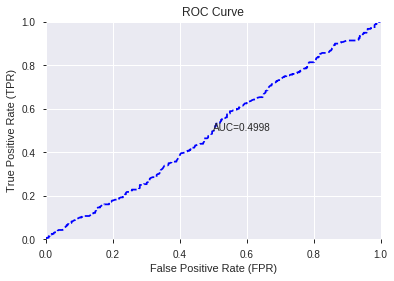

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


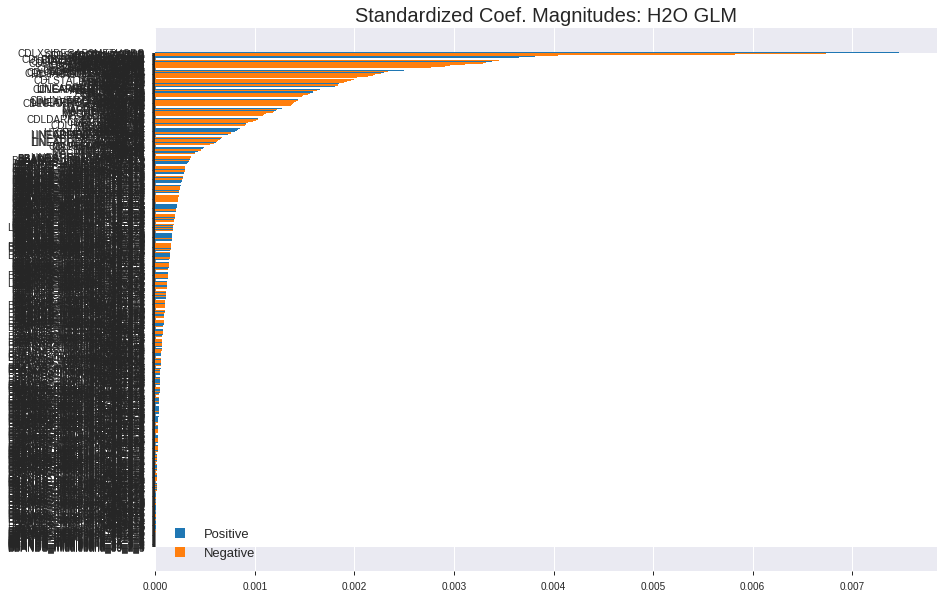

'log_likelihood'
--2019-08-22 14:21:37--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.8.139
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.8.139|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_142042_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_142042_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_82_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_82_s

['CDLXSIDEGAP3METHODS',
 'BOP',
 'CDLHARAMI',
 'CDLSHOOTINGSTAR',
 'CDLSHORTLINE',
 'CDLMORNINGSTAR',
 'CDLBELTHOLD',
 'CDL3OUTSIDE',
 'BETA_12',
 'CDLHIGHWAVE',
 'BETA_8',
 'is_month_start',
 'CDLRISEFALL3METHODS',
 'CDLSTICKSANDWICH',
 'CDLHIKKAKEMOD',
 'CDLLADDERBOTTOM',
 'CDLEVENINGDOJISTAR',
 'CDLMARUBOZU',
 'CDLHAMMER',
 'CDLPIERCING',
 'CDLIDENTICAL3CROWS',
 'AD',
 'CDLENGULFING',
 'STOCHF_fastk',
 'CDLMATCHINGLOW',
 'CDLDOJISTAR',
 'ULTOSC',
 'STOCHRSI_fastk',
 'CORREL_14',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'CDL3LINESTRIKE',
 'ADOSC',
 'HT_DCPERIOD',
 'CDL3WHITESOLDIERS',
 'MFI_8',
 'CDLONNECK',
 'CDLUNIQUE3RIVER',
 'CDLADVANCEBLOCK',
 'CDLMORNINGDOJISTAR',
 'VAR_12',
 'CDLTASUKIGAP',
 'CDLGAPSIDESIDEWHITE',
 'BETA_14',
 'HT_PHASOR_quadrature',
 'NATR_30',
 'dayofyear',
 'ATR_30',
 'week',
 'weekofyear',
 'aroondown_20',
 'CORREL_12',
 'MINUS_DI_30',
 'ROC_8',
 'month',
 'ROCP_8',
 'CDLSTALLEDPATTERN',
 'ROCR_8',
 'ROCR100_8',
 'MINUS_DI_24',
 'CORREL_30',
 'aroonup_8',
 'MIN

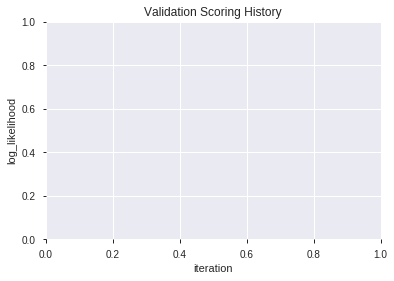

In [48]:
# GLM with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_142235_model_3  0.499583  0.726972              0.497041  0.515591  0.265834
1  XGBoost_grid_1_AutoML_20190822_142235_model_4  0.497158  0.712326              0.500000  0.509194  0.259279
2  XGBoost_grid_1_AutoML_20190822_142235_model_7  0.486655  0.742511              0.498521  0.522182  0.272674
3               XGBoost_2_AutoML_20190822_142235  0.486369  0.727284              0.492604  0.515771  0.266019
4  XGBoost_grid_1_AutoML_20190822_142235_model_5  0.485672  0.763836              0.495869  0.530196  0.281108
5  XGBoost_grid_1_AutoML_20190822_142235_model_1  0.485297  0.735663              0.482608  0.519276  0.269647
6               XGBoost_1_AutoML_20190822_142235  0.482544  0.741056              0.500000  0.521501  0.271963
7  XGBoost_grid_1_AutoML_20190822_142235_model_2  0.468190  0.719271              0.497041  0.512483  0.262638
8  XGBoost_grid_1_AutoML_20190822_142235_model_6  0.466394  0.722647              0.497041  0.513955  0.264149
9               XGBoost_3_AutoML_20190822_142235  0.465976  0.731142              0.500000  0.517716  0.268029

variable  relative_importance  scaled_importance  percentage
0                        BOP           160.774582           1.000000    0.022284
1                         AD           148.550629           0.923968    0.020589
2       HT_PHASOR_quadrature           118.537323           0.737289    0.016429
3                    BETA_12           118.457870           0.736795    0.016418
4                     MFI_20           108.637123           0.675711    0.015057
..                       ...                  ...                ...         ...
295   BBANDS_lowerband_8_7_4             2.360713           0.014683    0.000327
296   BBANDS_lowerband_8_2_5             2.134306           0.013275    0.000296
297            days_in_month             1.681822           0.010461    0.000233
298                 MAVP_8_5             0.630056           0.003919    0.000087
299  BBANDS_lowerband_14_0_3             0.387436           0.002410    0.000054

[300 rows x 4 columns]

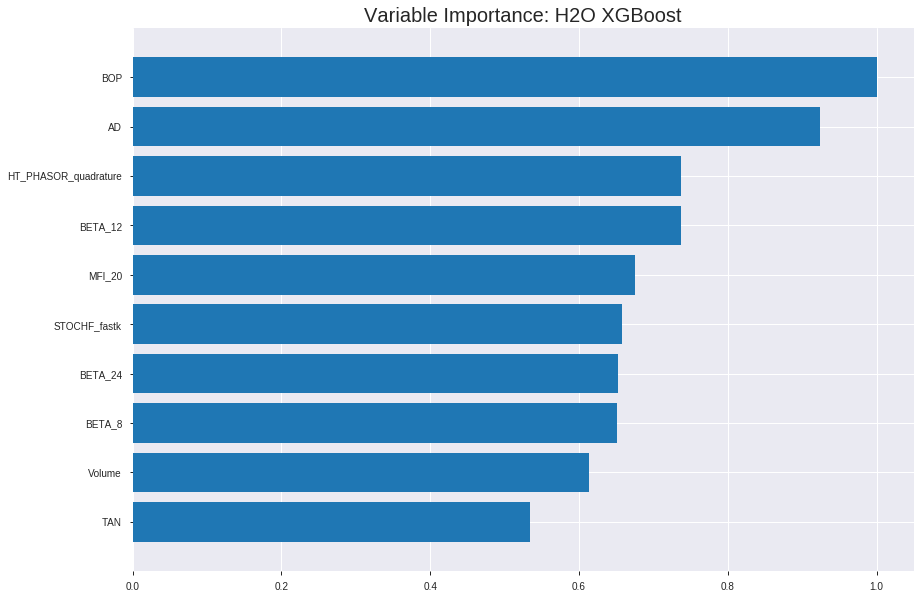

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_142235_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21348860669615918
RMSE: 0.46204827312323027
LogLoss: 0.6191699238452465
Mean Per-Class Error: 0.20651851708857227
AUC: 0.8781084170924331
pr_auc: 0.8804313593031119
Gini: 0.7562168341848663
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.491124144066935: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1438  686   0.323    (686.0/2124.0)
1      253   1942  0.1153   (253.0/2195.0)
Total  1691  2628  0.2174   (939.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.491124     0.805308  226
max f2                       0.45806      0.876399  277
max f0point5                 0.526569     0.818213  168
max accuracy                 0.501503     0.794165  209
max precision                0.807157     1         0
max recall                   0.381004     1         361
max specificity              0.807157     1         0
max absolute_mcc             0.501503     0.58943   209
max min_per_class_accuracy   0.507235     0.789548  198
max mean_per_class_accuracy  0.501503     0.793481  209

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.72 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.661057           1.96765    1.96765            1                0.688789  1                           0.688789            0.0200456       0.0200456                  96.7654   96.7654
    2        0.0201436                   0.642484           1.92189    1.94504            0.976744         0.650833  0.988506                    0.670029            0.0191344       0.03918                    92.1894   94.5037
    3        0.0300996                   0.629697           1.96765    1.95252            1                0.635608  0.992308                    0.658644            0.01959         0.0587699                  96.7654   95.2518
    4        0.0400556                   0.621654           1.87613    1.93353            0.953488         0.62497   0.982659                    0.650274            0.0186788       0.0774487                  87.6135   93.3533
    5        0.0500116                   0.615103           1.78462    1.90389            0.906977         0.618623  0.967593                    0.643973            0.0177677       0.0952164                  78.4616   90.3887
    6        0.100023                    0.591316           1.89478    1.89933            0.962963         0.602278  0.965278                    0.623126            0.0947608       0.189977                   89.4778   89.9332
    7        0.150035                    0.573367           1.89478    1.89781            0.962963         0.58215   0.964506                    0.609467            0.0947608       0.284738                   89.4778   89.7814
    8        0.200046                    0.559739           1.79457    1.872              0.912037         0.56624   0.951389                    0.59866             0.0897494       0.374487                   79.4573   87.2004
    9        0.300069                    0.538749           1.62605    1.79002            0.826389         0.549004  0.909722                    0.582108            0.162642        0.53713                    62.6047   79.0018
    10       0.400093                    0.523271           1.38465    1.68868            0.703704         0.530646  0.858218                    0.569243            0.138497        0.675626                   38.4645   68.8675
    11       0.500116                    0.507874           1.11591    1.57412            0.56713          0.515534  0.8                         0.558501            0.111617        0.787244                   11.5915   57.4123
    12       0.599907                    0.491768           0.894803   1.46112            0.454756         0.50016   0.74257                     0.548796            0.0892938       0.876538                   -10.5197  46.1122
    13       0.699931                    0.473951           0.601228   1.33824            0.305556         0.483282  0.680119                    0.539434            0.0601367       0.936674                   -39.8772  33.8239
    14       0.799954                    0.453238           0.391709   1.21989            0.199074         0.464016  0.619971                    0.530004            0.03918         0.975854                   -60.8291  21.9888
    15       0.899977                    0.425898           0.177635   1.10405            0.0902778        0.440571  0.561101                    0.520064            0.0177677       0.993622                   -82.2365  10.4053
    16       1                           0.279122           0.0637666  1                  0.0324074        0.391498  0.508219                   



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25532379484470435
RMSE: 0.5052957498779347
LogLoss: 0.7039268365795373
Mean Per-Class Error: 0.49321944740337453
AUC: 0.4836798569192935
pr_auc: 0.5038547760259502
Gini: -0.03264028616141301
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.3468325436115265: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      9    586   0.9849   (586.0/595.0)
1      1    638   0.0016   (1.0/639.0)
Total  10   1224  0.4757   (587.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.346833     0.684917   391
max f2                       0.346833     0.843915   391
max f0point5                 0.346833     0.576332   391
max accuracy                 0.346833     0.524311   391
max precision                0.670328     1          0
max recall                   0.334036     1          395
max specificity              0.670328     1          0
max absolute_mcc             0.346833     0.0755811  391
max min_per_class_accuracy   0.480878     0.494118   202
max mean_per_class_accuracy  0.346833     0.506781   391

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 47.96 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.599277           0.891296  0.891296           0.461538         0.621592  0.461538                    0.621592            0.00938967      0.00938967                 -10.8704   -10.8704
    2        0.0202593                   0.586383           0.965571  0.926948           0.5              0.592968  0.48                        0.607853            0.00938967      0.0187793                  -3.44288   -7.30516
    3        0.0299838                   0.576668           0.965571  0.939475           0.5              0.581257  0.486486                    0.599227            0.00938967      0.028169                   -3.44288   -6.05253
    4        0.0405186                   0.569206           1.1884    1.00419            0.615385         0.573408  0.52                        0.592514            0.0125196       0.0406886                  18.8395    0.419405
    5        0.0502431                   0.565167           1.1265    1.02787            0.583333         0.56772   0.532258                    0.587715            0.0109546       0.0516432                  12.65      2.78661
    6        0.100486                    0.547272           0.778686  0.903276           0.403226         0.556194  0.467742                    0.571955            0.0391236       0.0907668                  -22.1314   -9.67237
    7        0.149919                    0.536029           0.949742  0.918597           0.491803         0.541138  0.475676                    0.561794            0.0469484       0.137715                   -5.02578   -8.14025
    8        0.200162                    0.524852           0.934424  0.92257            0.483871         0.530939  0.477733                    0.554049            0.0469484       0.184664                   -6.55763   -7.74299
    9        0.299838                    0.506668           1.00482   0.949913           0.520325         0.515618  0.491892                    0.541273            0.100156        0.28482                    0.482207   -5.00867
    10       0.400324                    0.492178           1.07459   0.981208           0.556452         0.499031  0.508097                    0.53067             0.107981        0.392801                   7.45873    -1.8792
    11       0.5                         0.480677           1.02052   0.989045           0.528455         0.486529  0.512156                    0.52187             0.101721        0.494523                   2.05224    -1.09546
    12       0.599676                    0.466456           0.957721  0.983839           0.495935         0.473922  0.509459                    0.5139              0.0954617       0.589984                   -4.2279    -1.61612
    13       0.700162                    0.451692           0.996719  0.985687           0.516129         0.459086  0.510417                    0.506033            0.100156        0.690141                   -0.328134  -1.43127
    14       0.799838                    0.435137           1.02052   0.990028           0.528455         0.444341  0.512665                    0.498345            0.101721        0.791862                   2.05224    -0.997157
    15       0.899514                    0.411039           0.973421  0.988188           0.504065         0.425005  0.511712                    0.490218            0.0970266       0.888889                   -2.65786   -1.18118
    16       1                           0.295034           1.10573   1                  0.572581         0.384321  0.517828      


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 14:23:24  11.966 sec  0                  0.5              0.693147            0.5             0                  1                0.491781                         0.5                0.693147              0.5               0                    1                  0.482172
    2019-08-22 14:23:25  13.581 sec  5                  0.495003         0.683192            0.684881        0.686417           1.74903          0.408659                         0.499636           0.692418              0.526302          0.550476             1.48549            0.481361
    2019-08-22 14:23:26  14.272 sec  10                 0.490208         0.673703            0.742304        0.74238            1.74406          0.367446                         0.500192           0.693528              0.508096          0.531752             1.1884             0.47731
    2019-08-22 14:23:27  15.045 sec  15                 0.485597         0.664638            0.775077        0.776663           1.78878          0.321602                         0.500547           0.694235              0.502599          0.529089             1.37939            0.470016
    2019-08-22 14:23:27  15.764 sec  20                 0.481098         0.655852            0.806239        0.805804           1.87821          0.28502                          0.501041           0.695234              0.498435          0.520383             0.891296           0.474878
    2019-08-22 14:23:28  16.497 sec  25                 0.477923         0.649666            0.818296        0.81877            1.92293          0.267423                         0.501992           0.697159              0.494896          0.515884             1.03985            0.475689
    2019-08-22 14:23:29  17.202 sec  30                 0.475236         0.644458            0.830565        0.829861           1.92293          0.254226                         0.502073           0.697324              0.49767           0.514203             1.03985            0.475689
    2019-08-22 14:23:29  17.946 sec  35                 0.471301         0.636858            0.844911        0.846809           1.96765          0.247279                         0.50353            0.700304              0.492437          0.512596             1.03985            0.480551
    2019-08-22 14:23:30  18.650 sec  40                 0.468254         0.631004            0.854924        0.857134           1.96765          0.228294                         0.504511           0.702312              0.485977          0.507705             1.03985            0.480551
    2019-08-22 14:23:31  19.401 sec  45                 0.465002         0.624783            0.86713         0.867799           1.96765          0.218569                         0.505047           0.703419              0.486213          0.505564             0.891296           0.47812
    2019-08-22 14:23:32  20.192 sec  50                 0.462048         0.61917             0.878108        0.880431           1.96765          0.217411                         0.505296           0.703927              0.48368           0.503855             0.891296           0.475689

Variable Importances: 


variable                 relative_importance    scaled_importance     percentage
-----------------------  ---------------------  --------------------  ----------------------
BOP                      160.7745819091797      1.0                   0.022283526138816706
AD                       148.55062866210938     0.9239683717294596    0.020589273362873323
HT_PHASOR_quadrature     118.53732299804688     0.7372889519626161    0.016429397632919732
BETA_12                  118.45787048339844     0.7367947661671692    0.01641838543082946
MFI_20                   108.63712310791016     0.675710810862369     0.01505721951613263
---                      ---                    ---                   ---
BBANDS_lowerband_8_7_4   2.360713005065918      0.01468337206685735   0.00032719730525778687
BBANDS_lowerband_8_2_5   2.134305953979492      0.013275145415617657  0.00029581704986550883
days_in_month            1.6818222999572754     0.01046074746384552   0.00023310233954216224
MAVP_8_5                 0.6300563812255859     0.003918880545318413  8.732647706650312e-05
BBANDS_lowerband_14_0_3  0.3874359130859375     0.002409808245091858  5.369902501904044e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5501618122977346)

('F1', 0.625)

('auc', 0.499582628909552)

('logloss', 0.7269718889407045)

('mean_per_class_error', 0.48051563820794585)

('rmse', 0.5155909357443309)

('mse', 0.2658340130217148)

xgboost prediction progress: |████████████████████████████████████████████| 100%


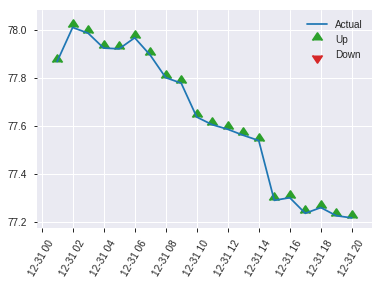


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.2658340130217148
RMSE: 0.5155909357443309
LogLoss: 0.7269718889407045
Mean Per-Class Error: 0.48051563820794585
AUC: 0.499582628909552
pr_auc: 0.4446543237260995
Gini: -0.0008347421808959643
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.31809866428375244: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    336  0.9941   (336.0/338.0)
1      0    280  0        (0.0/280.0)
Total  2    616  0.5437   (336.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.318099     0.625      397
max f2                       0.318099     0.806452   397
max f0point5                 0.452202     0.511905   350
max accuracy                 0.770217     0.550162   3
max precision                0.780942     1          0
max recall                   0.318099     1          397
max specificity              0.780942     1          0
max absolute_mcc             0.730046     0.0609938  15
max min_per_class_accuracy   0.542125     0.511834   208
max mean_per_class_accuracy  0.547249     0.519484   196

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 55.31 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.756165           0.945918  0.945918           0.428571         0.768575  0.428571                    0.768575            0.0107143       0.0107143                  -5.40816   -5.40816
    2        0.0210356                   0.734577           0.367857  0.679121           0.166667         0.745774  0.307692                    0.758052            0.00357143      0.0142857                  -63.2143   -32.0879
    3        0.0307443                   0.728381           0.735714  0.696992           0.333333         0.731549  0.315789                    0.749683            0.00714286      0.0214286                  -26.4286   -30.3008
    4        0.0404531                   0.712051           1.47143   0.882857           0.666667         0.716984  0.4                         0.741835            0.0142857       0.0357143                  47.1429    -11.7143
    5        0.0501618                   0.707588           1.47143   0.996774           0.666667         0.710344  0.451613                    0.73574             0.0142857       0.05                       47.1429    -0.322581
    6        0.100324                    0.680067           1.06797   1.03237            0.483871         0.692699  0.467742                    0.71422             0.0535714       0.103571                   6.79724    3.23733
    7        0.150485                    0.658112           0.640783  0.901843           0.290323         0.6684    0.408602                    0.698947            0.0321429       0.135714                   -35.9217   -9.81567
    8        0.200647                    0.631444           0.925576  0.907776           0.419355         0.643817  0.41129                     0.685164            0.0464286       0.182143                   -7.4424    -9.22235
    9        0.300971                    0.589081           0.996774  0.937442           0.451613         0.607846  0.424731                    0.659391            0.1             0.282143                   -0.322581  -6.25576
    10       0.399676                    0.563776           1.08548   0.974002           0.491803         0.575575  0.441296                    0.638692            0.107143        0.389286                   8.54801    -2.59977
    11       0.5                         0.541999           1.24597   1.02857            0.564516         0.551418  0.466019                    0.621181            0.125           0.514286                   24.5968    2.85714
    12       0.600324                    0.518399           0.996774  1.02326            0.451613         0.530536  0.463612                    0.606032            0.1             0.614286                   -0.322581  2.32576
    13       0.699029                    0.502488           0.904567  1.0065             0.409836         0.510492  0.456019                    0.592542            0.0892857       0.703571                   -9.54333   0.649802
    14       0.799353                    0.484448           0.996774  1.00528            0.451613         0.494158  0.455466                    0.580194            0.1             0.803571                   -0.322581  0.527762
    15       0.899676                    0.454264           1.06797   1.01227            0.483871         0.46881   0.458633                    0.567773            0.107143        0.910714                   6.79724    1.22688
    16       1                           0.314181           0.889977  1                  0.403226         0.42111   0.453074        

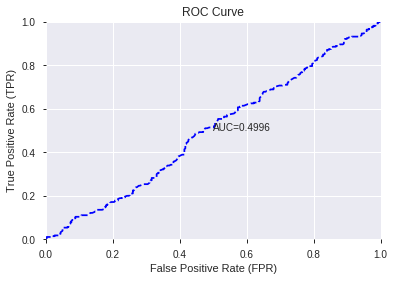

This function is available for GLM models only


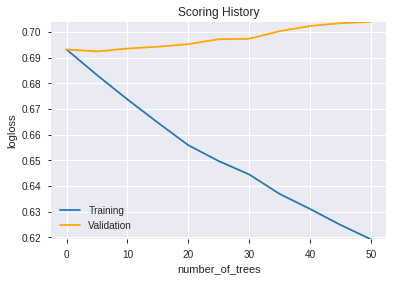

--2019-08-22 14:24:23--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.206.19
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.206.19|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at hex.

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_142235_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_142235_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_90_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training

['BOP',
 'AD',
 'HT_PHASOR_quadrature',
 'BETA_12',
 'MFI_20',
 'STOCHF_fastk',
 'BETA_24',
 'BETA_8',
 'Volume',
 'TAN',
 'HT_DCPERIOD',
 'SAREXT',
 'BETA_20',
 'BETA_14',
 'CORREL_30',
 'OBV',
 'CORREL_14',
 'MINUS_DI_8',
 'BETA_30',
 'CCI_8',
 'ADX_8',
 'ADXR_14',
 'MINUS_DI_30',
 'HT_PHASOR_inphase',
 'DX_20',
 'LINEARREG_ANGLE_8',
 'MINUS_DI_12',
 'CORREL_24',
 'CORREL_8',
 'STOCH_slowd',
 'ULTOSC',
 'STOCH_slowk',
 'STDDEV_8',
 'PLUS_DM_24',
 'PLUS_DI_30',
 'DX_8',
 'LINEARREG_ANGLE_14',
 'MACDFIX_hist_12',
 'MACDFIX_hist_20',
 'MACDFIX_hist_8',
 'STDDEV_12',
 'STDDEV_24',
 'MFI_14',
 'dayofyear',
 'ADX_12',
 'ADX_20',
 'day',
 'hour',
 'CORREL_20',
 'CCI_14',
 'COS',
 'MINUS_DM_8',
 'ROC_8',
 'MACDFIX_8',
 'TRANGE',
 'CCI_20',
 'SUB',
 'SIN',
 'PLUS_DM_12',
 'ATR_20',
 'CCI_24',
 'DX_14',
 'DIV',
 'WILLR_12',
 'MFI_8',
 'PLUS_DI_12',
 'ATR_8',
 'MACDFIX_signal_14',
 'TRIX_8',
 'WILLR_30',
 'LINEARREG_ANGLE_20',
 'ADOSC',
 'MACDFIX_signal_24',
 'WILLR_24',
 'CORREL_12',
 'VAR_8',

In [49]:
# XGBoost with Select Family-wise error features
model_train(feature_name='Fwe',model_algo="XGBoost",features_list=features_list)

In [50]:
# recursive feature elimination with cross validation
try:
  del features_list
except:
  pass
gc.collect()

if features_to_include is True or 'RFE' in features_to_include:
  from sklearn.feature_selection import RFECV
  from sklearn.svm import LinearSVC
  from sklearn.tree import DecisionTreeClassifier,ExtraTreeClassifier
  from sklearn.linear_model import LogisticRegression, LinearRegression

  bestfeatures = RFECV(ExtraTreeClassifier(random_state=1,criterion='entropy'), min_features_to_select=select_rfe, step=1,cv=5).fit(pd.read_pickle('scaled_df')[:index_splits[0]].drop(data_label_name,axis=1)
                                                              ,pd.read_pickle('scaled_df')[:index_splits[0]][data_label_name])

  features_list = list(np.array(train_hf.columns)[:-1][bestfeatures.get_support()])

  del bestfeatures, RFECV, LinearSVC, DecisionTreeClassifier,ExtraTreeClassifier, LogisticRegression, LinearRegression
  gc.collect()
  display(len(features_list),features_list)
else:
  features_list = []

216

['BBANDS_upperband_8_2_5',
 'BBANDS_lowerband_8_3_2',
 'BBANDS_middleband_8_3_3',
 'BBANDS_upperband_8_3_4',
 'BBANDS_middleband_8_3_4',
 'BBANDS_middleband_8_3_5',
 'MAVP_8_4',
 'BBANDS_upperband_8_4_2',
 'BBANDS_upperband_8_4_3',
 'BBANDS_lowerband_8_4_4',
 'BBANDS_upperband_8_5_3',
 'BBANDS_lowerband_8_5_4',
 'BBANDS_lowerband_8_5_5',
 'BBANDS_lowerband_8_6_5',
 'BBANDS_lowerband_8_7_3',
 'BBANDS_upperband_8_7_5',
 'BBANDS_upperband_12_0_3',
 'BBANDS_middleband_12_0_5',
 'BBANDS_lowerband_12_1_5',
 'BBANDS_lowerband_12_2_5',
 'MA_12_3',
 'MAVP_12_3',
 'BBANDS_lowerband_12_4_4',
 'BBANDS_lowerband_12_7_3',
 'TEMA_14',
 'BBANDS_upperband_14_1_3',
 'BBANDS_lowerband_14_3_3',
 'BBANDS_upperband_14_4_3',
 'BBANDS_upperband_14_5_4',
 'BBANDS_lowerband_14_7_4',
 'BBANDS_upperband_14_7_5',
 'BBANDS_lowerband_14_7_5',
 'WMA_20',
 'BBANDS_upperband_20_2_4',
 'BBANDS_lowerband_20_2_4',
 'BBANDS_lowerband_20_2_5',
 'BBANDS_lowerband_20_3_5',
 'BBANDS_upperband_20_5_5',
 'BBANDS_middleband_24_7_

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  DeepLearning_grid_1_AutoML_20190822_143011_model_7  0.507840  0.883656              0.498521  0.553857  0.306758
1  DeepLearning_grid_1_AutoML_20190822_143011_model_5  0.501405  0.744178              0.497041  0.516972  0.267260
2  DeepLearning_grid_1_AutoML_20190822_143011_model_9  0.501072  0.693615              0.500000  0.500234  0.250234
3  DeepLearning_grid_1_AutoML_20190822_143011_model_8  0.500000  0.699609              0.500000  0.503217  0.253227
4  DeepLearning_grid_1_AutoML_20190822_143011_model_2  0.497934  0.732461              0.494696  0.517042  0.267332
5  DeepLearning_grid_1_AutoML_20190822_143011_model_3  0.493380  0.890225              0.486433  0.566591  0.321025
6  DeepLearning_grid_1_AutoML_20190822_143011_model_4  0.490210  0.909870              0.498521  0.568331  0.323001
7  DeepLearning_grid_1_AutoML_20190822_143011_model_6  0.488493  0.718436              0.498521  0.511926  0.262068
8               DeepLearning_1_AutoML_20190822_143011  0.485244  1.186265              0.500000  0.600094  0.360113
9  DeepLearning_grid_1_AutoML_20190822_143011_model_1  0.482555  1.138794              0.471999  0.604805  0.365789

variable  relative_importance  scaled_importance  percentage
0                HT_DCPERIOD             1.000000           1.000000    0.005193
1               aroondown_24             0.998941           0.998941    0.005187
2                     BETA_8             0.989582           0.989582    0.005139
3                  CORREL_12             0.980366           0.980366    0.005091
4                  CORREL_20             0.979958           0.979958    0.005089
..                       ...                  ...                ...         ...
211               PLUS_DM_12             0.835100           0.835100    0.004337
212  BBANDS_middleband_8_3_5             0.831095           0.831095    0.004316
213               MACDFIX_20             0.830530           0.830530    0.004313
214                   MOM_14             0.823175           0.823175    0.004275
215  BBANDS_lowerband_14_7_4             0.819169           0.819169    0.004254

[216 rows x 4 columns]

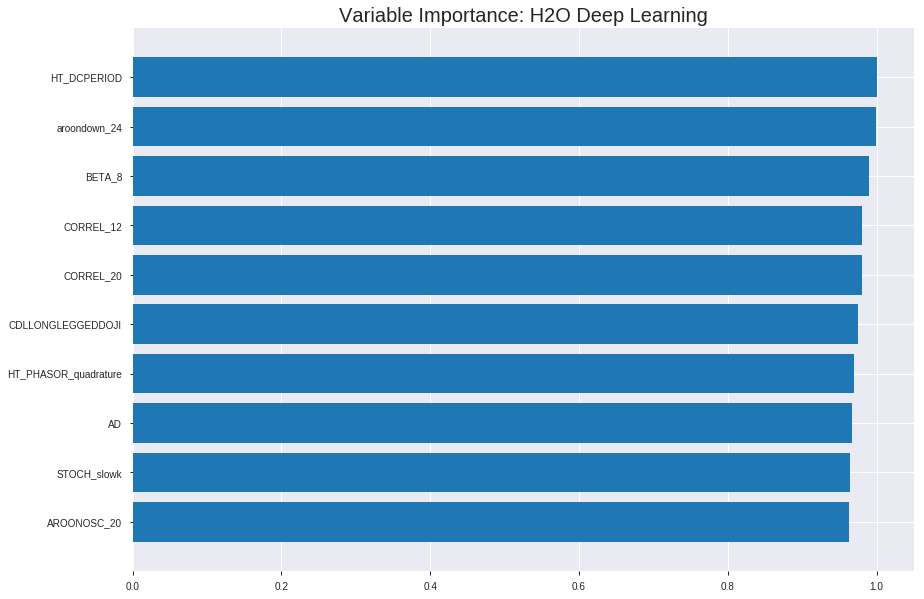

Model Details
H2ODeepLearningEstimator :  Deep Learning
Model Key:  DeepLearning_grid_1_AutoML_20190822_143011_model_7


ModelMetricsBinomial: deeplearning
** Reported on train data. **

MSE: 0.23453450385891877
RMSE: 0.48428762513502116
LogLoss: 0.6714992912080855
Mean Per-Class Error: 0.37505995049526186
AUC: 0.6759748658352959
pr_auc: 0.6973595752962142
Gini: 0.35194973167059174
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.19509078444559996: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      399  1725  0.8121   (1725.0/2124.0)
1      148  2047  0.0674   (148.0/2195.0)
Total  547  3772  0.4337   (1873.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.195091     0.686107  334
max f2                       0.0113129    0.838234  398
max f0point5                 0.612655     0.629832  155
max accuracy                 0.531501     0.622829  194
max precision                0.997613     1         0
max recall                   0.0113129    1         398
max specificity              0.997613     1         0
max absolute_mcc             0.7373       0.267188  96
max min_per_class_accuracy   0.526911     0.620527  196
max mean_per_class_accuracy  0.612655     0.62494   155

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.64 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score      cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  ---------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.981738           1.96765   1.96765            1                0.990743   1                           0.990743            0.0200456       0.0200456                  96.7654   96.7654
    2        0.0201436                   0.970978           1.83038   1.8998             0.930233         0.976032   0.965517                    0.983472            0.0182232       0.0382688                  83.0376   89.9804
    3        0.0300996                   0.954486           1.83038   1.87684            0.930233         0.962789   0.953846                    0.976631            0.0182232       0.056492                   83.0376   87.6839
    4        0.0400556                   0.936264           1.60158   1.80842            0.813953         0.945014   0.919075                    0.968772            0.0159453       0.0724374                  60.1579   80.8422
    5        0.0500116                   0.922127           1.64734   1.77635            0.837209         0.929529   0.902778                    0.96096             0.0164009       0.0888383                  64.7338   77.6354
    6        0.100023                    0.849468           1.57594   1.67615            0.800926         0.886014   0.851852                    0.923487            0.0788155       0.167654                   57.5945   67.6149
    7        0.150035                    0.782658           1.36643   1.57291            0.694444         0.815223   0.799383                    0.887399            0.0683371       0.235991                   36.6426   57.2908
    8        0.200046                    0.723305           1.32999   1.51218            0.675926         0.751442   0.768519                    0.85341             0.0665148       0.302506                   32.9988   51.2178
    9        0.300069                    0.64322            1.15235   1.39224            0.585648         0.681201   0.707562                    0.796007            0.115262        0.417768                   15.2353   39.2236
    10       0.400093                    0.589124           1.01116   1.29697            0.513889         0.616791   0.659144                    0.751203            0.101139        0.518907                   1.11554   29.6966
    11       0.500116                    0.529077           1.01571   1.24072            0.516204         0.562853   0.630556                    0.713533            0.101595        0.620501                   1.57102   24.0715
    12       0.599907                    0.43745            0.890238  1.18241            0.452436         0.483652   0.600926                    0.675293            0.0888383       0.709339                   -10.9762  18.2415
    13       0.699931                    0.355394           0.860849  1.13646            0.4375           0.394013   0.577572                    0.635097            0.0861048       0.795444                   -13.9151  13.6462
    14       0.799954                    0.263179           0.778863  1.09175            0.395833         0.308964   0.554848                    0.594319            0.0779043       0.873349                   -22.1137  9.17488
    15       0.899977                    0.166274           0.73787   1.05242            0.375            0.215915   0.53486                     0.552263            0.0738041       0.947153                   -26.213   5.24189
    16       1                           0.00409428         0.528351  1                  0.268519         0.0934803  0.508219                   



ModelMetricsBinomial: deeplearning
** Reported on validation data. **

MSE: 0.2817120546181621
RMSE: 0.5307655363888674
LogLoss: 0.7857275520355693
Mean Per-Class Error: 0.4719677542378454
AUC: 0.5252021935534777
pr_auc: 0.5385442540686028
Gini: 0.050404387106955495
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.08226435444942456: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      5    590   0.9916   (590.0/595.0)
1      1    638   0.0016   (1.0/639.0)
Total  6    1228  0.4789   (591.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0822644    0.683449   394
max f2                       0.074378     0.843453   397
max f0point5                 0.249167     0.579309   350
max accuracy                 0.28306      0.534846   333
max precision                0.986303     0.75       1
max recall                   0.074378     1          397
max specificity              0.994443     0.998319   0
max absolute_mcc             0.249167     0.0740327  350
max min_per_class_accuracy   0.538073     0.514286   192
max mean_per_class_accuracy  0.416714     0.528032   257

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 52.70 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.966599           1.03985   1.03985            0.538462         0.977256  0.538462                    0.977256            0.0109546       0.0109546                  3.98459   3.98459
    2        0.0202593                   0.954767           1.44836   1.23593            0.75             0.960818  0.64                        0.969366            0.0140845       0.0250391                  44.8357   23.5931
    3        0.0299838                   0.929542           1.1265    1.20044            0.583333         0.939815  0.621622                    0.959782            0.0109546       0.0359937                  12.65     20.044
    4        0.0405186                   0.910746           1.33694   1.23593            0.692308         0.918728  0.64                        0.949108            0.0140845       0.0500782                  33.6945   23.5931
    5        0.0502431                   0.900516           1.28743   1.2459             0.666667         0.904127  0.645161                    0.940402            0.0125196       0.0625978                  28.7428   24.5898
    6        0.100486                    0.819532           0.903276  1.07459            0.467742         0.855547  0.556452                    0.897974            0.0453834       0.107981                   -9.67237  7.45873
    7        0.149919                    0.766015           0.918084  1.02298            0.47541          0.792871  0.52973                     0.863319            0.0453834       0.153365                   -8.19159  2.29835
    8        0.200162                    0.702541           1.15246   1.05548            0.596774         0.737089  0.546559                    0.831634            0.057903        0.211268                   15.2456   5.54827
    9        0.299838                    0.615133           0.942021  1.01776            0.487805         0.657867  0.527027                    0.773868            0.0938967       0.305164                   -5.79793  1.77642
    10       0.400324                    0.574122           1.02787   1.0203             0.532258         0.590501  0.52834                     0.727841            0.103286        0.408451                   2.78661   2.02999
    11       0.5                         0.537953           1.06762   1.02973            0.552846         0.561513  0.533225                    0.694683            0.106416        0.514867                   6.76234   2.9734
    12       0.599676                    0.455722           0.957721  1.01776            0.495935         0.494841  0.527027                    0.661466            0.0954617       0.610329                   -4.2279   1.77642
    13       0.700162                    0.397797           1.12131   1.03262            0.580645         0.427682  0.534722                    0.627914            0.112676        0.723005                   12.1308   3.26248
    14       0.799838                    0.33477            0.92632   1.01938            0.479675         0.367786  0.527862                    0.595497            0.0923318       0.815336                   -7.36797  1.93771
    15       0.899514                    0.272311           0.989122  1.01602            0.512195         0.305431  0.526126                    0.563354            0.0985915       0.913928                   -1.08783  1.60245
    16       1                           0.0639695          0.856555  1                  0.443548         0.201985  0.517828                    0.527042           


Scoring History: 


timestamp            duration          training_speed    epochs    iterations    samples    training_rmse    training_logloss    training_r2    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_r2    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------------  ----------------  --------  ------------  ---------  ---------------  ------------------  -------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ---------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 14:43:06  0.000 sec                           0         0             0          nan              nan                 nan            nan             nan                nan              nan                              nan                nan                   nan              nan               nan                  nan                nan
    2019-08-22 14:43:11  9.058 sec         196 obs/sec       0.240333  1             1038       0.6015           1.13595             -0.447601      0.508504        0.513032           1.11799          0.490391                         0.567943           0.930213              -0.291879        0.523909          0.536994             0.891296           0.482172
    2019-08-22 14:43:51  49.074 sec        375 obs/sec       3.5837    15            15478      0.582264         0.924167            -0.356491      0.629255        0.64023            1.78878          0.455198                         0.601387           0.987226              -0.448507        0.495965          0.512623             0.891296           0.480551
    2019-08-22 14:44:34  1 min 31.666 sec  422 obs/sec       7.84024   33            33862      0.484288         0.671499            0.0616084      0.675975        0.69736            1.96765          0.433665                         0.530766           0.785728              -0.128283        0.525202          0.538544             1.03985            0.47893
    2019-08-22 14:45:12  2 min 10.162 sec  446 obs/sec       11.8502   50            51181      0.487288         0.688611            0.0499453      0.74191         0.733627           1.92293          0.366057                         0.571939           0.985165              -0.310124        0.524718          0.532764             1.03985            0.482172
    2019-08-22 14:45:50  2 min 48.246 sec  459 obs/sec       15.8731   67            68556      0.422535         0.518847            0.285662       0.831336        0.819513           1.96765          0.277379                         0.564383           1.03405               -0.275736        0.512391          0.518948             1.63404            0.480551
    2019-08-22 14:46:28  3 min 25.862 sec  469 obs/sec       19.8777   84            85852      0.408684         0.495644            0.33173        0.862619        0.82578            1.96765          0.254226                         0.580335           1.23467               -0.34887         0.510021          0.509265             1.33694            0.482172
    2019-08-22 14:46:32  3 min 29.807 sec  469 obs/sec       19.8777   84            85852      0.484288         0.671499            0.0616084      0.675975        0.69736            1.96765          0.433665                         0.530766           0.785728              -0.128283        0.525202          0.538544             1.03985            0.47893

Variable Importances: 


variable                 relative_importance    scaled_importance    percentage
-----------------------  ---------------------  -------------------  ---------------------
HT_DCPERIOD              1.0                    1.0                  0.005192826724550272
aroondown_24             0.9989407062530518     0.9989407062530518   0.005187325995671971
BETA_8                   0.9895824193954468     0.9895824193954468   0.005138730033581792
CORREL_12                0.9803661108016968     0.9803661108016968   0.005090871340014465
CORREL_20                0.9799582958221436     0.9799582958221436   0.0050887536274899685
---                      ---                    ---                  ---
PLUS_DM_12               0.8351004123687744     0.8351004123687744   0.004336531739031525
BBANDS_middleband_8_3_5  0.8310947418212891     0.8310947418212891   0.004315730985962799
MACDFIX_20               0.8305295705795288     0.8305295705795288   0.004312796149634639
MOM_14                   0.8231751322746277     0.8231751322746277   0.004274605825860893
BBANDS_lowerband_14_7_4  0.8191691040992737     0.8191691040992737   0.004253803215692613


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5453074433656958)

('F1', 0.6243032329988851)

('auc', 0.5078402366863906)

('logloss', 0.8836564884241097)

('mean_per_class_error', 0.4706043956043956)

('rmse', 0.5538569328900915)

('mse', 0.3067575021104193)

deeplearning prediction progress: |███████████████████████████████████████| 100%


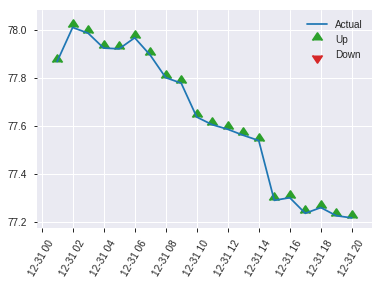


ModelMetricsBinomial: deeplearning
** Reported on test data. **

MSE: 0.3067575021104193
RMSE: 0.5538569328900915
LogLoss: 0.8836564884241097
Mean Per-Class Error: 0.4706043956043956
AUC: 0.5078402366863906
pr_auc: 0.4427090307529556
Gini: 0.015680473372781112
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.04629930945990506: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      1    337  0.997    (337.0/338.0)
1      0    280  0        (0.0/280.0)
Total  1    617  0.5453   (337.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.0462993    0.624303   398
max f2                       0.0462993    0.805987   398
max f0point5                 0.180924     0.512673   366
max accuracy                 0.996687     0.545307   0
max precision                0.641028     0.486239   151
max recall                   0.0462993    1          398
max specificity              0.996687     0.997041   0
max absolute_mcc             0.877606     0.0811286  46
max min_per_class_accuracy   0.58221      0.510714   195
max mean_per_class_accuracy  0.535695     0.529396   223

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 55.81 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0113269                   0.984219           0.630612  0.630612           0.285714         0.991165  0.285714                    0.991165            0.00714286      0.00714286                 -36.9388  -36.9388
    2        0.0210356                   0.96254            0.367857  0.509341           0.166667         0.971396  0.230769                    0.982041            0.00357143      0.0107143                  -63.2143  -49.0659
    3        0.0307443                   0.952511           0.735714  0.580827           0.333333         0.957404  0.263158                    0.974261            0.00714286      0.0178571                  -26.4286  -41.9173
    4        0.0404531                   0.935957           0.735714  0.618              0.333333         0.946841  0.28                        0.96768             0.00714286      0.025                      -26.4286  -38.2
    5        0.0501618                   0.920123           1.47143   0.78318            0.666667         0.928485  0.354839                    0.960094            0.0142857       0.0392857                  47.1429   -21.682
    6        0.100324                    0.869997           0.854378  0.818779           0.387097         0.897218  0.370968                    0.928656            0.0428571       0.0821429                  -14.5622  -18.1221
    7        0.150485                    0.799043           1.06797   0.901843           0.483871         0.838365  0.408602                    0.898559            0.0535714       0.135714                   6.79724   -9.81567
    8        0.200647                    0.755823           1.06797   0.943376           0.483871         0.775503  0.427419                    0.867795            0.0535714       0.189286                   6.79724   -5.66244
    9        0.300971                    0.66189            1.17477   1.02051            0.532258         0.699906  0.462366                    0.811832            0.117857        0.307143                   17.477    2.05069
    10       0.399676                    0.616261           1.01311   1.01868            0.459016         0.641258  0.461538                    0.769707            0.1             0.407143                   1.31148   1.86813
    11       0.5                         0.581281           1.03237   1.02143            0.467742         0.598312  0.462783                    0.735317            0.103571        0.510714                   3.23733   2.14286
    12       0.600324                    0.53944            1.17477   1.04705            0.532258         0.565861  0.474394                    0.706998            0.117857        0.628571                   17.477    4.70543
    13       0.699029                    0.428567           0.723653  1.00139            0.327869         0.480864  0.453704                    0.675067            0.0714286       0.7                        -27.6347  0.138889
    14       0.799353                    0.351679           1.06797   1.00975            0.483871         0.397984  0.45749                     0.640291            0.107143        0.807143                   6.79724   0.974552
    15       0.899676                    0.253584           0.889977  0.99639            0.403226         0.305345  0.451439                    0.602941            0.0892857       0.896429                   -11.0023  -0.360997
    16       1                           0.0229479          1.03237   1                  0.467742         0.155916  0.453074                    0.558094 

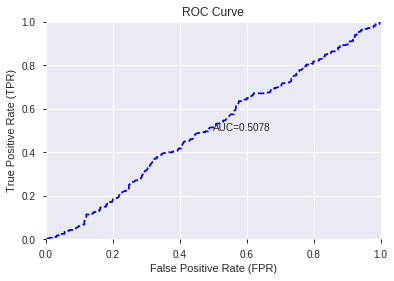

This function is available for GLM models only


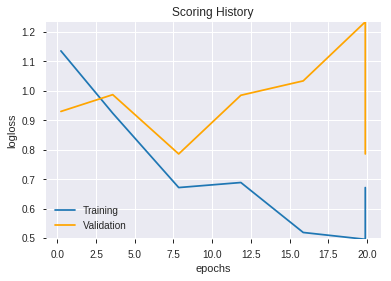

--2019-08-22 14:56:35--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.217.36.60
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.217.36.60|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/DeepLearning_grid_1_AutoML_20190822_143011_model_7',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'DeepLearning_grid_1_AutoML_20190822_143011_model_7',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_98_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'autom

['HT_DCPERIOD',
 'aroondown_24',
 'BETA_8',
 'CORREL_12',
 'CORREL_20',
 'CDLLONGLEGGEDDOJI',
 'HT_PHASOR_quadrature',
 'AD',
 'STOCH_slowk',
 'AROONOSC_20',
 'OBV',
 'STOCHRSI_fastk',
 'CORREL_14',
 'aroondown_20',
 'aroondown_8',
 'CDLRICKSHAWMAN',
 'CDLBELTHOLD',
 'CORREL_8',
 'STDDEV_12',
 'aroonup_8',
 'DX_14',
 'LINEARREG_ANGLE_20',
 'MINUS_DI_12',
 'AROONOSC_8',
 'WILLR_30',
 'aroonup_14',
 'TRANGE',
 'CDLHIKKAKE',
 'HT_PHASOR_inphase',
 'MFI_24',
 'MACDFIX_12',
 'aroonup_24',
 'CDLSPINNINGTOP',
 'ADX_8',
 'PLUS_DI_30',
 'ADX_24',
 'STDDEV_8',
 'ADOSC',
 'PLUS_DI_20',
 'ADXR_14',
 'PLUS_DM_24',
 'AROONOSC_30',
 'CORREL_30',
 'MOM_30',
 'CDLLONGLINE',
 'MOM_12',
 'VAR_8',
 'BBANDS_lowerband_8_5_5',
 'AROONOSC_24',
 'MFI_8',
 'PLUS_DI_12',
 'LINEARREG_ANGLE_8',
 'BETA_12',
 'MFI_20',
 'MFI_30',
 'MACDFIX_14',
 'BOP',
 'DX_24',
 'ROCR_20',
 'LINEARREG_SLOPE_20',
 'MINUS_DI_30',
 'CCI_20',
 'CMO_24',
 'aroondown_14',
 'STOCHF_fastd',
 'DX_30',
 'ADXR_8',
 'ROCP_14',
 'MINUS_DM_8',
 

In [51]:
# DeepLearning with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="DeepLearning",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error     rmse       mse
0  GLM_grid_1_AutoML_20190822_145732_model_1  0.493306  0.697345              0.497041  0.50209  0.252095

variable  relative_importance  scaled_importance  percentage
0                        BOP             0.007106           1.000000    0.031196
1               CDLSHORTLINE             0.005903           0.830737    0.025916
2                CDLBELTHOLD             0.004221           0.594057    0.018532
3                CDL3OUTSIDE             0.004055           0.570624    0.017801
4                    BETA_12             0.003972           0.559029    0.017440
..                       ...                  ...                ...         ...
211  BBANDS_lowerband_20_2_4             0.000032           0.004508    0.000141
212  BBANDS_lowerband_14_3_3             0.000028           0.003879    0.000121
213   BBANDS_lowerband_8_5_5             0.000028           0.003873    0.000121
214  BBANDS_lowerband_20_2_5             0.000024           0.003315    0.000103
215   BBANDS_lowerband_8_6_5             0.000024           0.003308    0.000103

[216 rows x 4 columns]

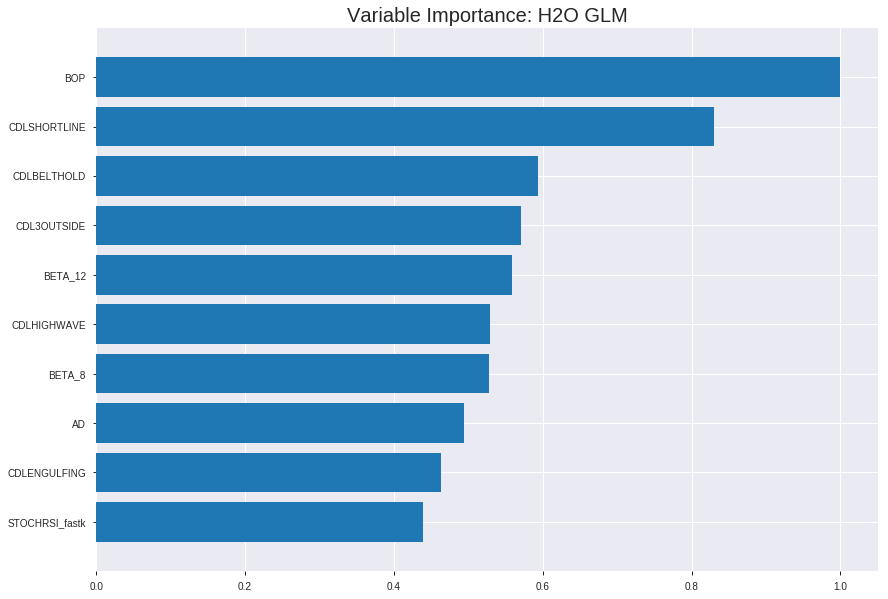

Model Details
H2OGeneralizedLinearEstimator :  Generalized Linear Modeling
Model Key:  GLM_grid_1_AutoML_20190822_145732_model_1


ModelMetricsBinomialGLM: glm
** Reported on train data. **

MSE: 0.24889816341437165
RMSE: 0.498896946687762
LogLoss: 0.6909398565107369
Null degrees of freedom: 4318
Residual degrees of freedom: 4102
Null deviance: 5986.238124775795
Residual deviance: 5968.338480539744
AIC: 6402.338480539744
AUC: 0.5408490234182292
pr_auc: 0.5448208899314452
Gini: 0.08169804683645832
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.46017257232199416: 


0    1     Error    Rate
-----  ---  ----  -------  ---------------
0      7    2117  0.9967   (2117.0/2124.0)
1      0    2195  0        (0.0/2195.0)
Total  7    4312  0.4902   (2117.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.460173     0.674658  394
max f2                       0.460173     0.838298  394
max f0point5                 0.475791     0.567657  358
max accuracy                 0.514832     0.534151  164
max precision                0.581872     1         0
max recall                   0.460173     1         394
max specificity              0.581872     1         0
max absolute_mcc             0.514832     0.074774  164
max min_per_class_accuracy   0.508638     0.527778  199
max mean_per_class_accuracy  0.514832     0.536211  164

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.82 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.551307           1.20742   1.20742            0.613636         0.558879  0.613636                    0.558879            0.0123007       0.0123007                  20.7424   20.7424
    2        0.0201436                   0.546373           1.4643    1.33439            0.744186         0.548757  0.678161                    0.553876            0.0145786       0.0268793                  46.43     33.4386
    3        0.0300996                   0.542952           0.960947  1.21086            0.488372         0.544515  0.615385                    0.55078             0.0095672       0.0364465                  -3.90528  21.0864
    4        0.0400556                   0.540406           0.915188  1.13737            0.465116         0.541651  0.578035                    0.548511            0.00911162      0.0455581                  -8.48122  13.7372
    5        0.0500116                   0.537853           1.05247   1.12047            0.534884         0.539008  0.569444                    0.546619            0.0104784       0.0560364                  5.2466    12.047
    6        0.100023                    0.531205           1.16602   1.14324            0.592593         0.534233  0.581019                    0.540426            0.0583144       0.114351                   16.6017   14.3243
    7        0.150035                    0.527089           1.02026   1.10225            0.518519         0.528951  0.560185                    0.536601            0.0510251       0.165376                   2.02649   10.225
    8        0.200046                    0.523403           1.11136   1.10453            0.564815         0.525171  0.561343                    0.533744            0.0555809       0.220957                   11.136    10.4528
    9        0.300069                    0.518106           1.04759   1.08555            0.532407         0.520717  0.551698                    0.529401            0.104784        0.32574                    4.75934   8.55497
    10       0.400093                    0.513402           1.07037   1.08175            0.543981         0.515754  0.549769                    0.52599             0.107062        0.432802                   7.03672   8.17541
    11       0.500116                    0.508629           0.961053  1.05761            0.488426         0.511004  0.5375                      0.522993            0.0961276       0.528929                   -3.89469  5.76139
    12       0.599907                    0.503349           0.940456  1.03813            0.477958         0.50607   0.527596                    0.520178            0.0938497       0.622779                   -5.95437  3.81253
    13       0.699931                    0.498378           0.974717  1.02906            0.49537          0.501034  0.52299                     0.517442            0.0974943       0.720273                   -2.52826  2.9064
    14       0.799954                    0.49236            0.915506  1.01487            0.465278         0.495411  0.515774                    0.514687            0.0915718       0.811845                   -8.44944  1.48651
    15       0.899977                    0.483669           1.04304   1.018              0.530093         0.488379  0.517366                    0.511763            0.104328        0.916173                   4.30387   1.79963
    16       1                           0.449476           0.838075  1                  0.425926         0.476333  0.508219                    0.508219            



ModelMetricsBinomialGLM: glm
** Reported on validation data. **

MSE: 0.24990601347318442
RMSE: 0.49990600463805634
LogLoss: 0.6929577542794301
Null degrees of freedom: 1233
Residual degrees of freedom: 1017
Null deviance: 1709.574001855587
Residual deviance: 1710.2197375616333
AIC: 2144.2197375616333
AUC: 0.5017503715101064
pr_auc: 0.5247809788605957
Gini: 0.0035007430202127487
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4613937924207518: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      3    592   0.995    (592.0/595.0)
1      0    639   0        (0.0/639.0)
Total  3    1231  0.4797   (592.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.461394     0.683422   396
max f2                       0.461394     0.843676   396
max f0point5                 0.475313     0.576816   368
max accuracy                 0.477037     0.527553   360
max precision                0.562557     1          0
max recall                   0.461394     1          396
max specificity              0.562557     1          0
max absolute_mcc             0.475313     0.0575041  368
max min_per_class_accuracy   0.506589     0.492437   196
max mean_per_class_accuracy  0.490273     0.513551   298

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 50.62 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0105348                   0.547269           1.33694   1.33694            0.692308         0.552778  0.692308                    0.552778            0.0140845       0.0140845                  33.6945    33.6945
    2        0.0202593                   0.540549           1.28743   1.31318            0.666667         0.542724  0.68                        0.547952            0.0125196       0.0266041                  28.7428    31.3177
    3        0.0299838                   0.538084           0.804643  1.14825            0.416667         0.53904   0.594595                    0.545062            0.00782473      0.0344288                  -19.5357   14.8247
    4        0.0405186                   0.536362           0.891296  1.08144            0.461538         0.537066  0.56                        0.542983            0.00938967      0.0438185                  -10.8704   8.14397
    5        0.0502431                   0.534929           0.804643  1.02787            0.416667         0.535874  0.532258                    0.541607            0.00782473      0.0516432                  -19.5357   2.78661
    6        0.100486                    0.528996           1.02787   1.02787            0.532258         0.531469  0.532258                    0.536538            0.0516432       0.103286                   2.78661    2.78661
    7        0.149919                    0.5254             0.949742  1.00211            0.491803         0.527289  0.518919                    0.533488            0.0469484       0.150235                   -5.02578   0.210633
    8        0.200162                    0.521761           0.996719  1.00075            0.516129         0.523587  0.518219                    0.531003            0.0500782       0.200313                   -0.328134  0.0753961
    9        0.299838                    0.516065           1.06762   1.02298            0.552846         0.518653  0.52973                     0.526897            0.106416        0.306729                   6.76234    2.29835
    10       0.400324                    0.511172           0.949997  1.00466            0.491935         0.513627  0.520243                    0.523566            0.0954617       0.402191                   -5.00025   0.466316
    11       0.5                         0.506543           0.91062   0.985915           0.471545         0.508863  0.510535                    0.520635            0.0907668       0.492958                   -8.938     -1.40845
    12       0.599676                    0.501812           0.989122  0.986448           0.512195         0.50423   0.510811                    0.517908            0.0985915       0.591549                   -1.08783   -1.35516
    13       0.700162                    0.496631           1.07459   0.999098           0.556452         0.499197  0.517361                    0.515223            0.107981        0.699531                   7.45873    -0.0902017
    14       0.799838                    0.490296           1.11472   1.01351            0.577236         0.493294  0.524823                    0.51249             0.111111        0.810642                   11.4724    1.35074
    15       0.899514                    0.483              0.973421  1.00907            0.504065         0.487118  0.522523                    0.509679            0.0970266       0.907668                   -2.65786   0.90654
    16       1                           0.449942           0.91885   1                  0.475806         0.475483  0.517828           


Scoring History: 


timestamp            duration    iteration    lambda    predictors    deviance_train    deviance_test
--  -------------------  ----------  -----------  --------  ------------  ----------------  ---------------
    2019-08-22 14:57:33  0.000 sec   2            2.9       217           1.38188           1.38592
    2019-08-22 14:57:34  0.248 sec   4            1.8       217           1.38074           1.38627
    2019-08-22 14:57:34  0.492 sec   6            1.1       217           1.37927           1.38676
    2019-08-22 14:57:34  0.743 sec   8            0.69      217           1.37751           1.38759
    2019-08-22 14:57:34  1.032 sec   10           0.43      217           1.37548           1.38886

/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5501618122977346)

('F1', 0.625)

('auc', 0.4933062130177515)

('logloss', 0.6973449209802635)

('mean_per_class_error', 0.4790997464074387)

('rmse', 0.5020901326760135)

('mse', 0.2520945013306169)

glm prediction progress: |████████████████████████████████████████████████| 100%


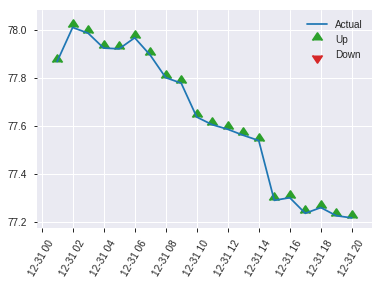


ModelMetricsBinomialGLM: glm
** Reported on test data. **

MSE: 0.2520945013306169
RMSE: 0.5020901326760135
LogLoss: 0.6973449209802635
Null degrees of freedom: 617
Residual degrees of freedom: 401
Null deviance: 858.8040410176391
Residual deviance: 861.9183223316056
AIC: 1295.9183223316056
AUC: 0.4933062130177515
pr_auc: 0.4486997896105712
Gini: -0.013387573964496968
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.45765764786057866: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      2    336  0.9941   (336.0/338.0)
1      0    280  0        (0.0/280.0)
Total  2    616  0.5437   (336.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.457658     0.625      397
max f2                       0.457658     0.806452   397
max f0point5                 0.494306     0.512712   324
max accuracy                 0.556797     0.550162   3
max precision                0.556797     0.75       3
max recall                   0.457658     1          397
max specificity              0.560149     0.997041   0
max absolute_mcc             0.494306     0.0569645  324
max min_per_class_accuracy   0.514409     0.492857   198
max mean_per_class_accuracy  0.494306     0.5209     324

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 51.43 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.554715           0.945918  0.945918           0.428571         0.557258  0.428571                    0.557258            0.0107143       0.0107143                  -5.40816   -5.40816
    2        0.0210356                   0.551477           1.10357   1.01868            0.5              0.552487  0.461538                    0.555056            0.0107143       0.0214286                  10.3571    1.86813
    3        0.0307443                   0.548854           1.10357   1.04549            0.5              0.549994  0.473684                    0.553458            0.0107143       0.0321429                  10.3571    4.54887
    4        0.0404531                   0.547987           0.735714  0.971143           0.333333         0.548362  0.44                        0.552235            0.00714286      0.0392857                  -26.4286   -2.88571
    5        0.0501618                   0.546967           1.47143   1.06797            0.666667         0.547545  0.483871                    0.551327            0.0142857       0.0535714                  47.1429    6.79724
    6        0.100324                    0.540877           0.996774  1.03237            0.451613         0.543635  0.467742                    0.547481            0.05            0.103571                   -0.322581  3.23733
    7        0.150485                    0.536632           0.925576  0.996774           0.419355         0.539044  0.451613                    0.544669            0.0464286       0.15                       -7.4424    -0.322581
    8        0.200647                    0.53126            0.925576  0.978975           0.419355         0.533836  0.443548                    0.54196             0.0464286       0.196429                   -7.4424    -2.10253
    9        0.300971                    0.524915           0.818779  0.925576           0.370968         0.52774   0.419355                    0.53722             0.0821429       0.278571                   -18.1221   -7.4424
    10       0.399676                    0.519356           1.0493    0.956131           0.47541          0.521986  0.433198                    0.533458            0.103571        0.382143                   4.92974    -4.38693
    11       0.5                         0.514335           1.10357   0.985714           0.5              0.517124  0.446602                    0.530181            0.110714        0.492857                   10.3571    -1.42857
    12       0.600324                    0.510216           1.03237   0.993512           0.467742         0.512354  0.450135                    0.527202            0.103571        0.596429                   3.23733    -0.648826
    13       0.699029                    0.504414           1.15785   1.01672            0.52459          0.507395  0.460648                    0.524405            0.114286        0.710714                   15.7845    1.67163
    14       0.799353                    0.497322           0.996774  1.01421            0.451613         0.500995  0.459514                    0.521467            0.1             0.810714                   -0.322581  1.42134
    15       0.899676                    0.488541           0.925576  1.00433            0.419355         0.493704  0.455036                    0.518371            0.0928571       0.903571                   -7.4424    0.432939
    16       1                           0.453575           0.961175  1                  0.435484         0.477316  0.453074          

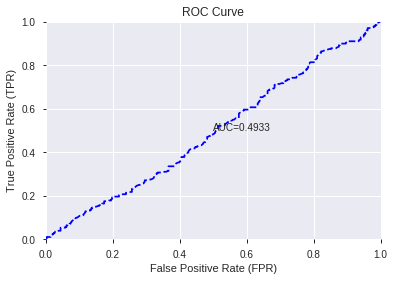

/usr/local/lib/python3.6/dist-packages/matplotlib/cbook/__init__.py:424: MatplotlibDeprecationWarning: 
Passing one of 'on', 'true', 'off', 'false' as a boolean is deprecated; use an actual boolean (True/False) instead.
  warn_deprecated("2.2", "Passing one of 'on', 'true', 'off', 'false' as a "


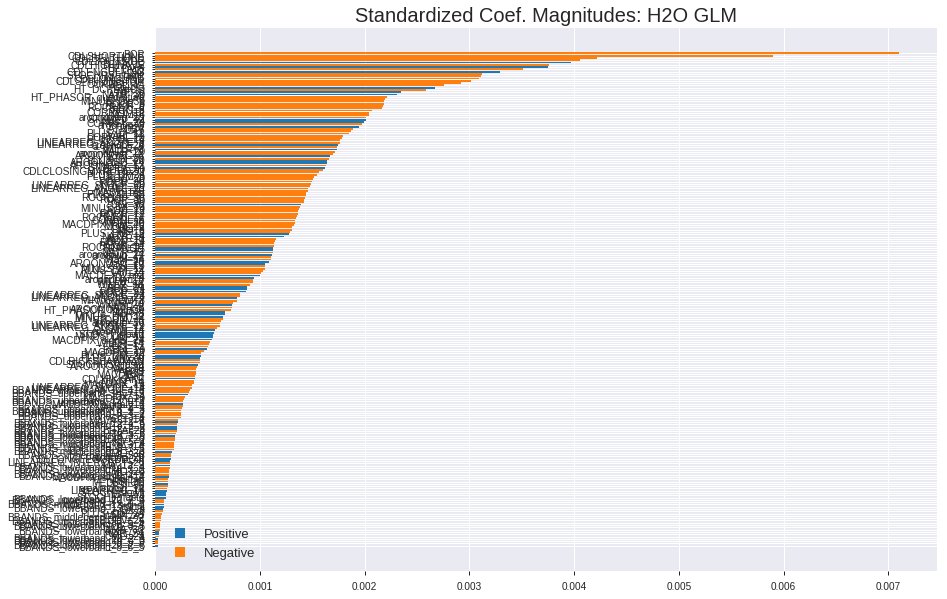

'log_likelihood'
--2019-08-22 14:57:47--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.139.147
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.139.147|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
ERROR: Unknown MOJO type


[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/GLM_grid_1_AutoML_20190822_145732_model_1',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'GLM_grid_1_AutoML_20190822_145732_model_1',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_106_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_training_py_106

['BOP',
 'CDLSHORTLINE',
 'CDLBELTHOLD',
 'CDL3OUTSIDE',
 'BETA_12',
 'CDLHIGHWAVE',
 'BETA_8',
 'AD',
 'CDLENGULFING',
 'STOCHRSI_fastk',
 'ULTOSC',
 'CDLLONGLINE',
 'CDLSPINNINGTOP',
 'CORREL_14',
 'ADOSC',
 'HT_DCPERIOD',
 'MFI_8',
 'NATR_30',
 'ATR_30',
 'HT_PHASOR_quadrature',
 'MINUS_DI_30',
 'ROCP_8',
 'ROCR_8',
 'ROCR100_8',
 'ROC_8',
 'CORREL_12',
 'MOM_8',
 'aroondown_20',
 'STDDEV_12',
 'NATR_24',
 'CORREL_30',
 'aroonup_8',
 'ATR_24',
 'OBV',
 'PLUS_DI_12',
 'VAR_14',
 'CORREL_20',
 'PLUS_DI_14',
 'LINEARREG_SLOPE_8',
 'LINEARREG_ANGLE_8',
 'aroonup_24',
 'WILLR_8',
 'NATR_20',
 'aroondown_12',
 'AROONOSC_8',
 'ATR_20',
 'PLUS_DI_20',
 'AROONOSC_24',
 'AROONOSC_12',
 'STDDEV_14',
 'BETA_30',
 'CDLCLOSINGMARUBOZU',
 'PLUS_DI_24',
 'PLUS_DM_8',
 'ROC_20',
 'ROCR_20',
 'ROCP_20',
 'LINEARREG_SLOPE_20',
 'LINEARREG_ANGLE_20',
 'MFI_20',
 'MACD_hist',
 'PLUS_DI_30',
 'ROCR100_30',
 'ROCP_30',
 'ROC_30',
 'CCI_30',
 'DX_30',
 'MINUS_DI_14',
 'ROC_12',
 'ROCP_12',
 'ROCR_12',
 'RO

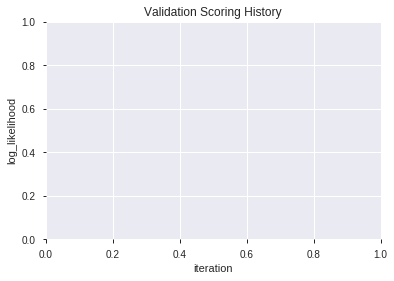

In [52]:
# GLM with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="GLM",features_list=features_list)

AutoML progress: |████████████████████████████████████████████████████████| 100%


model_id       auc   logloss  mean_per_class_error      rmse       mse
0  XGBoost_grid_1_AutoML_20190822_145844_model_3  0.488932  0.728395              0.500000  0.516225  0.266488
1  XGBoost_grid_1_AutoML_20190822_145844_model_6  0.479242  0.724310              0.498521  0.514417  0.264624
2  XGBoost_grid_1_AutoML_20190822_145844_model_1  0.474947  0.739177              0.497041  0.520805  0.271238
3               XGBoost_1_AutoML_20190822_145844  0.471777  0.737495              0.493523  0.520121  0.270526
4  XGBoost_grid_1_AutoML_20190822_145844_model_5  0.471260  0.780192              0.491177  0.536142  0.287448
5               XGBoost_3_AutoML_20190822_145844  0.471191  0.724938              0.492044  0.514891  0.265113
6               XGBoost_2_AutoML_20190822_145844  0.470124  0.730141              0.494083  0.517060  0.267351
7  XGBoost_grid_1_AutoML_20190822_145844_model_4  0.466906  0.717091              0.492910  0.511518  0.261650
8  XGBoost_grid_1_AutoML_20190822_145844_model_7  0.465939  0.745704              0.495562  0.523710  0.274272
9  XGBoost_grid_1_AutoML_20190822_145844_model_2  0.460366  0.713953              0.500000  0.510092  0.260194

variable  relative_importance  scaled_importance  percentage
0                        BOP           220.219742           1.000000    0.029461
1                    BETA_12           176.757217           0.802640    0.023647
2                    BETA_20           126.164383           0.572902    0.016879
3                         AD           117.622971           0.534116    0.015736
4                        OBV           116.825287           0.530494    0.015629
..                       ...                  ...                ...         ...
186   BBANDS_lowerband_8_4_4             4.286185           0.019463    0.000573
187  BBANDS_lowerband_14_3_3             3.813305           0.017316    0.000510
188              aroondown_8             3.519142           0.015980    0.000471
189   BBANDS_upperband_8_2_5             1.092884           0.004963    0.000146
190                  TEMA_14             0.077545           0.000352    0.000010

[191 rows x 4 columns]

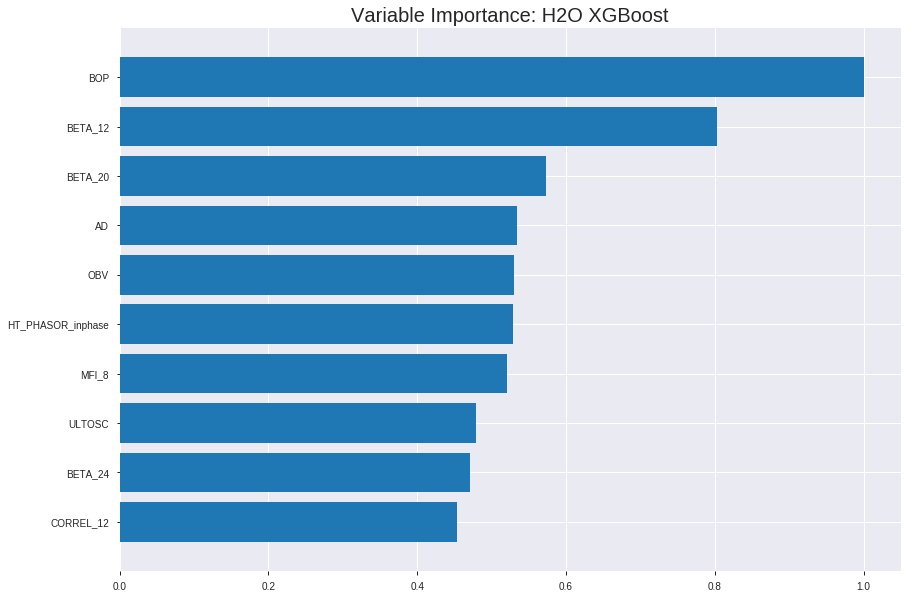

Model Details
H2OXGBoostEstimator :  XGBoost
Model Key:  XGBoost_grid_1_AutoML_20190822_145844_model_3


ModelMetricsBinomial: xgboost
** Reported on train data. **

MSE: 0.21173075588241116
RMSE: 0.4601421040096322
LogLoss: 0.6154426670868971
Mean Per-Class Error: 0.21026022161306512
AUC: 0.8712518607175184
pr_auc: 0.8737125295156812
Gini: 0.7425037214350367
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.4885624547799428: 


0     1     Error    Rate
-----  ----  ----  -------  --------------
0      1389  735   0.346    (735.0/2124.0)
1      240   1955  0.1093   (240.0/2195.0)
Total  1629  2690  0.2257   (975.0/4319.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value     idx
---------------------------  -----------  --------  -----
max f1                       0.488562     0.800409  229
max f2                       0.450722     0.873585  281
max f0point5                 0.528671     0.805828  167
max accuracy                 0.507937     0.789766  197
max precision                0.763478     1         0
max recall                   0.330261     1         382
max specificity              0.763478     1         0
max absolute_mcc             0.507937     0.579448  197
max min_per_class_accuracy   0.508408     0.78861   196
max mean_per_class_accuracy  0.507937     0.78974   197

Gains/Lift Table: Avg response rate: 50.82 %, avg score: 50.89 %



group    cumulative_data_fraction    lower_threshold    lift       cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  ---------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0101875                   0.675462           1.96765    1.96765            1                0.701371  1                           0.701371            0.0200456       0.0200456                  96.7654   96.7654
    2        0.0201436                   0.652313           1.87613    1.92242            0.953488         0.662246  0.977011                    0.682033            0.0186788       0.0387244                  87.6135   92.242
    3        0.0300996                   0.640758           1.96765    1.93738            1                0.646035  0.984615                    0.670126            0.01959         0.0583144                  96.7654   93.7382
    4        0.0400556                   0.62954            1.96765    1.94491            1                0.634855  0.988439                    0.661359            0.01959         0.0779043                  96.7654   94.4906
    5        0.0500116                   0.621875           1.96765    1.94943            1                0.626159  0.990741                    0.654352            0.01959         0.0974943                  96.7654   94.9435
    6        0.100023                    0.596732           1.89478    1.92211            0.962963         0.607513  0.976852                    0.630933            0.0947608       0.192255                   89.4778   92.2106
    7        0.150035                    0.578978           1.75814    1.86745            0.893519         0.588022  0.949074                    0.616629            0.0879271       0.280182                   75.8135   86.7449
    8        0.200046                    0.565727           1.78546    1.84695            0.907407         0.572802  0.938657                    0.605672            0.0892938       0.369476                   78.5464   84.6953
    9        0.300069                    0.545604           1.59416    1.76269            0.810185         0.555374  0.895833                    0.588906            0.159453        0.528929                   59.4164   76.269
    10       0.400093                    0.527407           1.39375    1.67046            0.708333         0.536345  0.848958                    0.575766            0.139408        0.668337                   39.3755   67.0456
    11       0.500116                    0.508674           1.15235    1.56684            0.585648         0.517939  0.796296                    0.5642              0.115262        0.783599                   15.2353   56.6835
    12       0.599907                    0.49179            0.871976   1.45125            0.443155         0.500325  0.737553                    0.553575            0.0870159       0.870615                   -12.8024  45.1249
    13       0.699931                    0.473541           0.637666   1.33498            0.324074         0.483239  0.678465                    0.543524            0.0637813       0.934396                   -36.2334  33.4984
    14       0.799954                    0.452507           0.382599   1.2159             0.194444         0.463534  0.617945                    0.533522            0.0382688       0.972665                   -61.7401  21.5902
    15       0.899977                    0.419821           0.214073   1.10456            0.108796         0.43723   0.561358                    0.52282             0.0214123       0.994077                   -78.5927  10.4559
    16       1                           0.258647           0.0592118  1                  0.0300926        0.383518  0.508219                    0



ModelMetricsBinomial: xgboost
** Reported on validation data. **

MSE: 0.25489440502199695
RMSE: 0.5048706814838796
LogLoss: 0.7031937727902736
Mean Per-Class Error: 0.4859404794781762
AUC: 0.4906695072395155
pr_auc: 0.5261236619283323
Gini: -0.018660985520968953
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.24940335750579834: 


0    1     Error    Rate
-----  ---  ----  -------  --------------
0      1    594   0.9983   (594.0/595.0)
1      0    639   0        (0.0/639.0)
Total  1    1233  0.4814   (594.0/1234.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.249403     0.682692   398
max f2                       0.249403     0.84323    398
max f0point5                 0.249403     0.573506   398
max accuracy                 0.322025     0.519449   388
max precision                0.743105     1          0
max recall                   0.249403     1          398
max specificity              0.743105     1          0
max absolute_mcc             0.624996     0.0654378  19
max min_per_class_accuracy   0.491156     0.480672   196
max mean_per_class_accuracy  0.573573     0.51406    60

Gains/Lift Table: Avg response rate: 51.78 %, avg score: 48.94 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain      cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  --------  -----------------
    1        0.0105348                   0.648846           1.33694   1.33694            0.692308         0.681051  0.692308                    0.681051            0.0140845       0.0140845                  33.6945   33.6945
    2        0.0202593                   0.623268           1.44836   1.39042            0.75             0.631812  0.72                        0.657416            0.0140845       0.028169                   44.8357   39.0423
    3        0.0299838                   0.606724           0.804643  1.20044            0.416667         0.616796  0.621622                    0.644242            0.00782473      0.0359937                  -19.5357  20.044
    4        0.0405186                   0.598986           1.1884    1.19731            0.615385         0.602848  0.62                        0.633479            0.0125196       0.0485133                  18.8395   19.7308
    5        0.0502431                   0.588037           0.965571  1.15246            0.5              0.593047  0.596774                    0.625654            0.00938967      0.057903                   -3.44288  15.2456
    6        0.100486                    0.565037           1.02787   1.09016            0.532258         0.575563  0.564516                    0.600608            0.0516432       0.109546                   2.78661   9.0161
    7        0.149919                    0.549927           0.918084  1.03342            0.47541          0.558091  0.535135                    0.586589            0.0453834       0.15493                    -8.19159  3.34222
    8        0.200162                    0.539823           1.02787   1.03203            0.532258         0.544856  0.534413                    0.576114            0.0516432       0.206573                   2.78661   3.20275
    9        0.299838                    0.522373           0.957721  1.00733            0.495935         0.530419  0.521622                    0.560923            0.0954617       0.302034                   -4.2279   0.732564
    10       0.400324                    0.506005           0.887703  0.977299           0.459677         0.513629  0.506073                    0.549052            0.0892019       0.391236                   -11.2297  -2.27012
    11       0.5                         0.491139           0.92632   0.967136           0.479675         0.498469  0.50081                     0.538968            0.0923318       0.483568                   -7.36797  -3.28638
    12       0.599676                    0.476445           1.02052   0.97601            0.528455         0.484397  0.505405                    0.529897            0.101721        0.58529                    2.05224   -2.39902
    13       0.700162                    0.460121           1.10573   0.994628           0.572581         0.468302  0.515046                    0.521057            0.111111        0.696401                   10.5735   -0.537225
    14       0.799838                    0.441793           0.91062   0.984159           0.471545         0.451361  0.509625                    0.512372            0.0907668       0.787167                   -8.938    -1.58413
    15       0.899514                    0.406686           1.06762   0.993407           0.552846         0.426081  0.514414                    0.50281             0.106416        0.893584                   6.76234   -0.659251
    16       1                           0.232759           1.05901   1                  0.548387         0.369393  0.517828                    0.489403  


Scoring History: 


timestamp            duration    number_of_trees    training_rmse    training_logloss    training_auc    training_pr_auc    training_lift    training_classification_error    validation_rmse    validation_logloss    validation_auc    validation_pr_auc    validation_lift    validation_classification_error
--  -------------------  ----------  -----------------  ---------------  ------------------  --------------  -----------------  ---------------  -------------------------------  -----------------  --------------------  ----------------  -------------------  -----------------  ---------------------------------
    2019-08-22 14:59:01  5.002 sec   0                  0.5              0.693147            0.5             0                  1                0.491781                         0.5                0.693147              0.5               0                    1                  0.482172
    2019-08-22 14:59:01  5.358 sec   5                  0.494568         0.682329            0.692041        0.688966           1.78878          0.391989                         0.500134           0.693417              0.511815          0.520035             1.03985            0.479741
    2019-08-22 14:59:02  5.546 sec   10                 0.489729         0.672763            0.74666         0.746774           1.79275          0.324612                         0.500638           0.694426              0.500084          0.520121             1.03985            0.475689
    2019-08-22 14:59:02  5.748 sec   15                 0.484592         0.662671            0.775968        0.778806           1.92293          0.324381                         0.500366           0.693881              0.512019          0.539665             1.48549            0.480551
    2019-08-22 14:59:02  5.948 sec   20                 0.481229         0.656095            0.793743        0.797541           1.92293          0.306321                         0.500983           0.695119              0.503878          0.530108             1.33694            0.47731
    2019-08-22 14:59:02  6.161 sec   25                 0.477354         0.64854             0.809494        0.81107            1.92293          0.273906                         0.50177            0.696718              0.49575           0.528828             1.48549            0.47893
    2019-08-22 14:59:02  6.382 sec   30                 0.474056         0.642131            0.824167        0.827727           1.87821          0.263024                         0.502101           0.697408              0.500913          0.535972             1.48549            0.47893
    2019-08-22 14:59:03  6.606 sec   35                 0.470542         0.635336            0.836903        0.842432           1.92293          0.26395                          0.502908           0.699067              0.496452          0.531034             1.33694            0.480551
    2019-08-22 14:59:03  6.837 sec   40                 0.466909         0.628354            0.84835         0.851981           1.96765          0.246816                         0.503747           0.700838              0.496398          0.531662             1.33694            0.480551
    2019-08-22 14:59:03  7.066 sec   45                 0.463599         0.622035            0.860132        0.864348           1.96765          0.229914                         0.504607           0.702597              0.489933          0.525044             1.33694            0.47893
    2019-08-22 14:59:03  7.309 sec   50                 0.460142         0.615443            0.871252        0.873713           1.96765          0.225747                         0.504871           0.703194              0.49067           0.526124             1.33694            0.481361

Variable Importances: 


variable                 relative_importance    scaled_importance       percentage
-----------------------  ---------------------  ----------------------  ----------------------
BOP                      220.21974182128906     1.0                     0.029461450346182725
BETA_12                  176.75721740722656     0.8026401990365929      0.0236469443697668
BETA_20                  126.16438293457031     0.572902237969901       0.0168785308371672
AD                       117.62297058105469     0.5341163767075303      0.01573584311145193
OBV                      116.82528686523438     0.5304941596019102      0.01562912734205161
---                      ---                    ---                     ---
BBANDS_lowerband_8_4_4   4.286184787750244      0.019463217749244907    0.0005734146232963211
BBANDS_lowerband_14_3_3  3.813305377960205      0.01731591067368859     0.0005101518425118119
aroondown_8              3.5191421508789062     0.015980139299839574    0.0004707980805073068
BBANDS_upperband_8_2_5   1.0928840637207031     0.004962697961055606    0.00014620827956274198
TEMA_14                  0.077545166015625      0.00035212631426365863  1.0374151923263113e-05


See the whole table with table.as_data_frame()


/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:7116: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  sort=sort,


('accuracy', 0.5485436893203883)

('F1', 0.623608017817372)

('auc', 0.48893174133558753)

('logloss', 0.7283946301717958)

('mean_per_class_error', 0.47857142857142865)

('rmse', 0.5162252027145066)

('mse', 0.26648845991763337)

xgboost prediction progress: |████████████████████████████████████████████| 100%


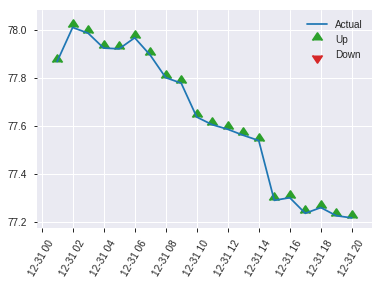


ModelMetricsBinomial: xgboost
** Reported on test data. **

MSE: 0.26648845991763337
RMSE: 0.5162252027145066
LogLoss: 0.7283946301717958
Mean Per-Class Error: 0.47857142857142865
AUC: 0.48893174133558753
pr_auc: 0.42814810209094545
Gini: -0.022136517328824934
Confusion Matrix (Act/Pred) for max f1 @ threshold = 0.331860214471817: 


0    1    Error    Rate
-----  ---  ---  -------  -------------
0      0    338  1        (338.0/338.0)
1      0    280  0        (0.0/280.0)
Total  0    618  0.5469   (338.0/618.0)

Maximum Metrics: Maximum metrics at their respective thresholds



metric                       threshold    value      idx
---------------------------  -----------  ---------  -----
max f1                       0.33186      0.623608   399
max f2                       0.33186      0.805524   399
max f0point5                 0.398414     0.51009    380
max accuracy                 0.807906     0.548544   0
max precision                0.807906     1          0
max recall                   0.33186      1          399
max specificity              0.807906     1          0
max absolute_mcc             0.667723     0.0895324  49
max min_per_class_accuracy   0.535662     0.505917   206
max mean_per_class_accuracy  0.531037     0.521429   213

Gains/Lift Table: Avg response rate: 45.31 %, avg score: 54.56 %



group    cumulative_data_fraction    lower_threshold    lift      cumulative_lift    response_rate    score     cumulative_response_rate    cumulative_score    capture_rate    cumulative_capture_rate    gain       cumulative_gain
--  -------  --------------------------  -----------------  --------  -----------------  ---------------  --------  --------------------------  ------------------  --------------  -------------------------  ---------  -----------------
    1        0.0113269                   0.752044           0.315306  0.315306           0.142857         0.767692  0.142857                    0.767692            0.00357143      0.00357143                 -68.4694   -68.4694
    2        0.0210356                   0.732866           0.735714  0.509341           0.333333         0.737406  0.230769                    0.753714            0.00714286      0.0107143                  -26.4286   -49.0659
    3        0.0307443                   0.712984           1.10357   0.696992           0.5              0.718999  0.315789                    0.742752            0.0107143       0.0214286                  10.3571    -30.3008
    4        0.0404531                   0.708437           0.735714  0.706286           0.333333         0.710996  0.32                        0.73513             0.00714286      0.0285714                  -26.4286   -29.3714
    5        0.0501618                   0.697347           0.367857  0.640783           0.166667         0.702375  0.290323                    0.72879             0.00357143      0.0321429                  -63.2143   -35.9217
    6        0.100324                    0.669463           0.78318   0.711982           0.354839         0.682374  0.322581                    0.705582            0.0392857       0.0714286                  -21.682    -28.8018
    7        0.150485                    0.637163           0.925576  0.78318            0.419355         0.652662  0.354839                    0.687942            0.0464286       0.117857                   -7.4424    -21.682
    8        0.200647                    0.619247           0.996774  0.836578           0.451613         0.628822  0.379032                    0.673162            0.05            0.167857                   -0.322581  -16.3422
    9        0.300971                    0.587537           1.31717   0.996774           0.596774         0.601556  0.451613                    0.649293            0.132143        0.3                        31.7166    -0.322581
    10       0.399676                    0.556235           0.868384  0.965067           0.393443         0.572367  0.437247                    0.630295            0.0857143       0.385714                   -13.1616   -3.49335
    11       0.5                         0.535464           1.21037   1.01429            0.548387         0.546211  0.459547                    0.613424            0.121429        0.507143                   21.0369    1.42857
    12       0.600324                    0.515784           0.889977  0.993512           0.403226         0.525704  0.450135                    0.598765            0.0892857       0.596429                   -11.0023   -0.648826
    13       0.699029                    0.493392           1.0493    1.00139            0.47541          0.505561  0.453704                    0.585604            0.103571        0.7                        4.92974    0.138889
    14       0.799353                    0.476522           0.925576  0.991874           0.419355         0.486047  0.449393                    0.573109            0.0928571       0.792857                   -7.4424    -0.812608
    15       0.899676                    0.447354           1.06797   1.00036            0.483871         0.464501  0.453237                    0.560998            0.107143        0.9                        6.79724    0.0359712
    16       1                           0.33186            0.996774  1                  0.451613         0.407462  0.453074   

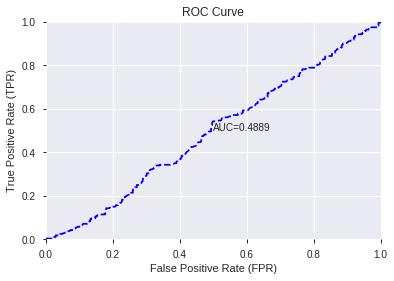

This function is available for GLM models only


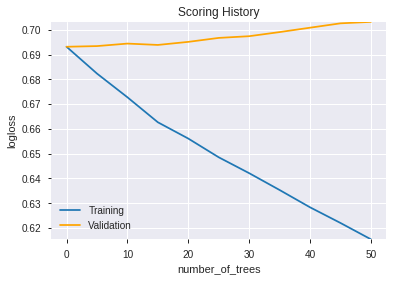

--2019-08-22 14:59:29--  https://h2o-release.s3.amazonaws.com/h2o/rel-yates/5/h2o-3.24.0.5.zip
Resolving h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)... 52.216.237.211
Connecting to h2o-release.s3.amazonaws.com (h2o-release.s3.amazonaws.com)|52.216.237.211|:443... connected.
HTTP request sent, awaiting response... 416 Requested Range Not Satisfiable

    The file is already fully retrieved; nothing to do.

Archive:  h2o-3.24.0.5.zip
log4j:WARN No appenders could be found for logger (ml.dmlc.xgboost4j.java.Booster).
log4j:WARN Please initialize the log4j system properly.
log4j:WARN See http://logging.apache.org/log4j/1.2/faq.html#noconfig for more info.
Exception in thread "main" java.lang.StackOverflowError
	at java.base/java.lang.String.substring(String.java:1874)
	at java.base/java.lang.String.split(String.java:2289)
	at java.base/java.lang.String.split(String.java:2364)
	at hex.genmodel.algos.xgboost.XGBoostMojoModel.constructSubgraph(XGBoostMojoModel.java:101)
	at he

[{'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Models/XGBoost_grid_1_AutoML_20190822_145844_model_3',
   '__meta': {'schema_name': 'ModelKeyV3',
    'schema_type': 'Key<Model>',
    'schema_version': 3},
   'name': 'XGBoost_grid_1_AutoML_20190822_145844_model_3',
   'type': 'Key<Model>'},
  'default_value': None,
  'gridable': False,
  'help': 'Destination id for this model; auto-generated if not specified.',
  'is_member_of_frames': [],
  'is_mutually_exclusive_with': [],
  'label': 'model_id',
  'level': 'critical',
  'name': 'model_id',
  'required': False,
  'type': 'Key<Model>',
  'values': []},
 {'__meta': {'schema_name': 'ModelParameterSchemaV3',
   'schema_type': 'Iced',
   'schema_version': 3},
  'actual_value': {'URL': '/3/Frames/automl_training_py_114_sid_848c',
   '__meta': {'schema_name': 'FrameKeyV3',
    'schema_type': 'Key<Frame>',
    'schema_version': 3},
   'name': 'automl_trainin

['BOP',
 'BETA_12',
 'BETA_20',
 'AD',
 'OBV',
 'HT_PHASOR_inphase',
 'MFI_8',
 'ULTOSC',
 'BETA_24',
 'CORREL_12',
 'HT_PHASOR_quadrature',
 'MFI_12',
 'BETA_8',
 'MACDEXT_hist',
 'MFI_14',
 'HT_DCPERIOD',
 'STOCH_slowd',
 'TRANGE',
 'DX_24',
 'STDDEV_12',
 'ADXR_14',
 'MINUS_DI_30',
 'WILLR_8',
 'CORREL_14',
 'CORREL_30',
 'MINUS_DI_12',
 'PLUS_DI_30',
 'MFI_30',
 'PLUS_DM_30',
 'BETA_30',
 'MINUS_DI_14',
 'ADOSC',
 'BBANDS_lowerband_30_5_5',
 'CORREL_8',
 'MFI_20',
 'ADX_24',
 'ATR_30',
 'MOM_14',
 'MINUS_DM_8',
 'CCI_30',
 'WILLR_12',
 'STOCHF_fastd',
 'CCI_20',
 'PLUS_DI_12',
 'LINEARREG_ANGLE_12',
 'STOCH_slowk',
 'BBANDS_lowerband_20_2_4',
 'MACDFIX_hist_20',
 'MOM_8',
 'ROC_20',
 'ROC_12',
 'WILLR_30',
 'CORREL_20',
 'VAR_24',
 'BBANDS_lowerband_30_5_4',
 'MINUS_DM_24',
 'STDDEV_8',
 'CMO_14',
 'STOCHRSI_fastd',
 'ADX_8',
 'WILLR_14',
 'ROC_24',
 'PLUS_DI_24',
 'PLUS_DM_24',
 'ATR_24',
 'ROC_14',
 'MFI_24',
 'CCI_12',
 'DX_8',
 'MACDFIX_signal_24',
 'LINEARREG_ANGLE_8',
 'CMO_2

In [53]:
# XGBoost with recursive feature elimination with cross validation
model_train(feature_name='RFE',model_algo="XGBoost",features_list=features_list)

In [54]:
# Experiment Summary
pd.set_option('precision', 3) 

for k in models_summary:
  print(k)
  display(models_summary[k].max())
  print('\n'*3)
  display(models_summary[k].groupby(models_summary[k].index).max())
  print('\n'*3)
  
display(models_summary)

pd.set_option('precision', 6) 

accuracy


DeepLearning    0.565
GLM             0.560
XGBoost         0.550
dtype: float64

DeepLearning   GLM  XGBoost
All          0.549  0.55    0.550
DLF          0.565  0.56    0.547
Fwe          0.565  0.55    0.550
RFE          0.545  0.55    0.549
XGBF         0.557  0.56    0.547





F1


DeepLearning    0.628
GLM             0.626
XGBoost         0.625
dtype: float64

DeepLearning    GLM  XGBoost
All          0.628  0.626    0.625
DLF          0.626  0.625    0.625
Fwe          0.625  0.626    0.625
RFE          0.624  0.625    0.624
XGBF         0.624  0.625    0.625





auc


DeepLearning    0.523
GLM             0.510
XGBoost         0.516
dtype: float64

DeepLearning    GLM  XGBoost
All          0.518  0.500    0.500
DLF          0.522  0.510    0.516
Fwe          0.522  0.500    0.500
RFE          0.508  0.493    0.489
XGBF         0.523  0.510    0.516





logloss


DeepLearning    0.916
GLM             0.697
XGBoost         0.728
dtype: float64

DeepLearning    GLM  XGBoost
All          0.916  0.696    0.727
DLF          0.700  0.694    0.704
Fwe          0.788  0.696    0.727
RFE          0.884  0.697    0.728
XGBF         0.728  0.694    0.704





mean_per_class_error


DeepLearning    0.473
GLM             0.480
XGBoost         0.481
dtype: float64

DeepLearning    GLM  XGBoost
All          0.464  0.480    0.481
DLF          0.454  0.476    0.472
Fwe          0.473  0.480    0.481
RFE          0.471  0.479    0.479
XGBF         0.468  0.476    0.472





rmse


DeepLearning    0.558
GLM             0.502
XGBoost         0.516
dtype: float64

DeepLearning    GLM  XGBoost
All          0.558  0.501    0.516
DLF          0.503  0.501    0.505
Fwe          0.528  0.501    0.516
RFE          0.554  0.502    0.516
XGBF         0.512  0.501    0.505





mse


DeepLearning    0.311
GLM             0.252
XGBoost         0.266
dtype: float64

DeepLearning    GLM  XGBoost
All          0.311  0.251    0.266
DLF          0.253  0.251    0.255
Fwe          0.279  0.251    0.266
RFE          0.307  0.252    0.266
XGBF         0.263  0.251    0.255

{'F1':       DeepLearning    GLM  XGBoost
 All          0.628    NaN      NaN
 DLF          0.626    NaN      NaN
 DLF            NaN  0.625      NaN
 DLF            NaN    NaN    0.625
 All            NaN  0.626      NaN
 All            NaN    NaN    0.625
 XGBF         0.624    NaN      NaN
 XGBF           NaN  0.625      NaN
 XGBF           NaN    NaN    0.625
 Fwe          0.625    NaN      NaN
 Fwe            NaN  0.626      NaN
 Fwe            NaN    NaN    0.625
 RFE          0.624    NaN      NaN
 RFE            NaN  0.625      NaN
 RFE            NaN    NaN    0.624,
 'accuracy':       DeepLearning   GLM  XGBoost
 All          0.549   NaN      NaN
 DLF          0.565   NaN      NaN
 DLF            NaN  0.56      NaN
 DLF            NaN   NaN    0.547
 All            NaN  0.55      NaN
 All            NaN   NaN    0.550
 XGBF         0.557   NaN      NaN
 XGBF           NaN  0.56      NaN
 XGBF           NaN   NaN    0.547
 Fwe          0.565   NaN      NaN
 Fwe            NaN 